In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [3]:
from dask.distributed import Client

# for virga
client = Client(n_workers=28, threads_per_worker=2, processes=True)

client

<Client: 'tcp://127.0.0.1:38779' processes=28 threads=56, memory=1.48 TiB>

In [4]:
epoch_key = 'Jaq', 3, 12

In [198]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=30,
                 min_distance_traveled=50,
                 )

07-Dec-21 12:03:28 Loading position info...
07-Dec-21 12:05:06 Loading multiunit...
07-Dec-21 12:05:35 Loading spikes...
07-Dec-21 12:06:54 Finding ripple times...


In [ ]:
import numpy as np

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'spike_model_knot_spacing': 8.0,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk',
    'multiunit_model_kwargs': {
        'bandwidth': np.array([20.0, 20.0, 20.0, 20.0, 8.0])},
    'multiunit_occupancy_kwargs': {'bandwidth': np.array([8.0])},
    'discrete_state_transition_type': 'constant',
    'discrete_diagonal': np.array([0.00003, 0.968])
}

In [176]:
from replay_identification import ReplayDetector
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING


def refit_detector(detector_parameters, data, n_refits=1):

    replay_detector = ReplayDetector(**detector_parameters)
    logging.info(replay_detector)

    replay_detector.fit(
        is_ripple=data['is_ripple'],
        is_training=~data['is_ripple'].values.squeeze(),
        speed=data['position_info'].nose_vel,
        position=data['position_info'].linear_position,
        spikes=data['spikes'],
        track_graph=data['track_graph'],
        edge_order=WTRACK_EDGE_ORDER,
        edge_spacing=WTRACK_EDGE_SPACING,
    )

    detector_results = replay_detector.predict(
        speed=data['position_info'].nose_vel,
        position=data['position_info'].linear_position,
        spikes=data['spikes'],
        time=data['position_info'].index / np.timedelta64(1, 's'),
        use_likelihoods=['spikes'],
        use_acausal=True)

    detector = [replay_detector]
    results = [detector_results]

    for fit_ind in range(n_refits):
        logging.info(f'refit #{fit_ind + 2}')
        replay_detector2 = ReplayDetector(**detector_parameters)
        replay_detector2.fit(
            is_ripple=results[-1].non_local_probability >= 0.80,
            is_training=results[-1].non_local_probability < 0.80,
            speed=data['position_info'].nose_vel,
            position=data['position_info'].linear_position,
            spikes=data['spikes'],
            track_graph=data['track_graph'],
            edge_order=WTRACK_EDGE_ORDER,
            edge_spacing=WTRACK_EDGE_SPACING,
        )
        detector_results2 = replay_detector2.predict(
            speed=data['position_info'].nose_vel,
            position=data['position_info'].linear_position,
            spikes=data['spikes'],
            time=data['position_info'].index / np.timedelta64(1, 's'),
            use_likelihoods=['spikes'],
            use_acausal=True)

        detector.append(replay_detector2)
        results.append(detector_results2)

    return detector, results

In [ ]:
detectors, results = refit_detector(detector_parameters, data, n_refits=10)

03-Dec-21 14:54:37 ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
               discrete_state_transition_type='constant',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6...
               multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
               multiunit_occupancy_kwargs={'bandwidth': array([8.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.5, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=8.0,
               spike_model_penalty

In [10]:
detectors

[ReplayDetector(discrete_diagonal=array([3.00e-05, 9.68e-01]),
                discrete_state_transition_type='constant',
                infer_track_interior=True, is_track_interior=None,
                lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
                lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                  'tol': 1e-06},
                movement_state_transition_type='random_walk', movement_var=6...
                multiunit_model_kwargs={'bandwidth': array([20., 20., 20., 20.,  8.])},
                multiunit_occupancy_kwargs={'bandwidth': array([8.])},
                multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
                place_bin_size=2.5, position_range=None, replay_speed=1,
                replay_state_transition_penalty=1e-05, speed_knots=None,
                speed_threshold=4.0, spike_model_knot_spacing=8.0,
                spike_model_penalty=0.5)

In [287]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from scipy.stats import zscore


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]},
                            dpi=100)
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    # max_consensus = np.ceil(zscore(data['ripple_consensus_trace'], nan_policy='omit').values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = zscore(data['ripple_consensus_trace'], nan_policy='omit').loc[start_time:end_time]
    
    max_consensus = max(int(np.ceil(ripple_consensus_trace.max())), 5)
    min_consensus = min(int(np.ceil(ripple_consensus_trace.min())), -1)
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((min_consensus, max_consensus))
    axes[0].set_yticks((min_consensus, max_consensus))
    axes[0].set_ylabel("Ripple\nSTd.")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = np.ceil(data["multiunit_firing_rate"].values.max()).astype(int)
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.argmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).non_local_probability >= 0.80,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).non_local_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    max_speed = np.ceil(speed.max()).astype(int)
    max_speed = max(5, max_speed)
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, max_speed))
    axes[5].set_ylim((0.0, max_speed))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

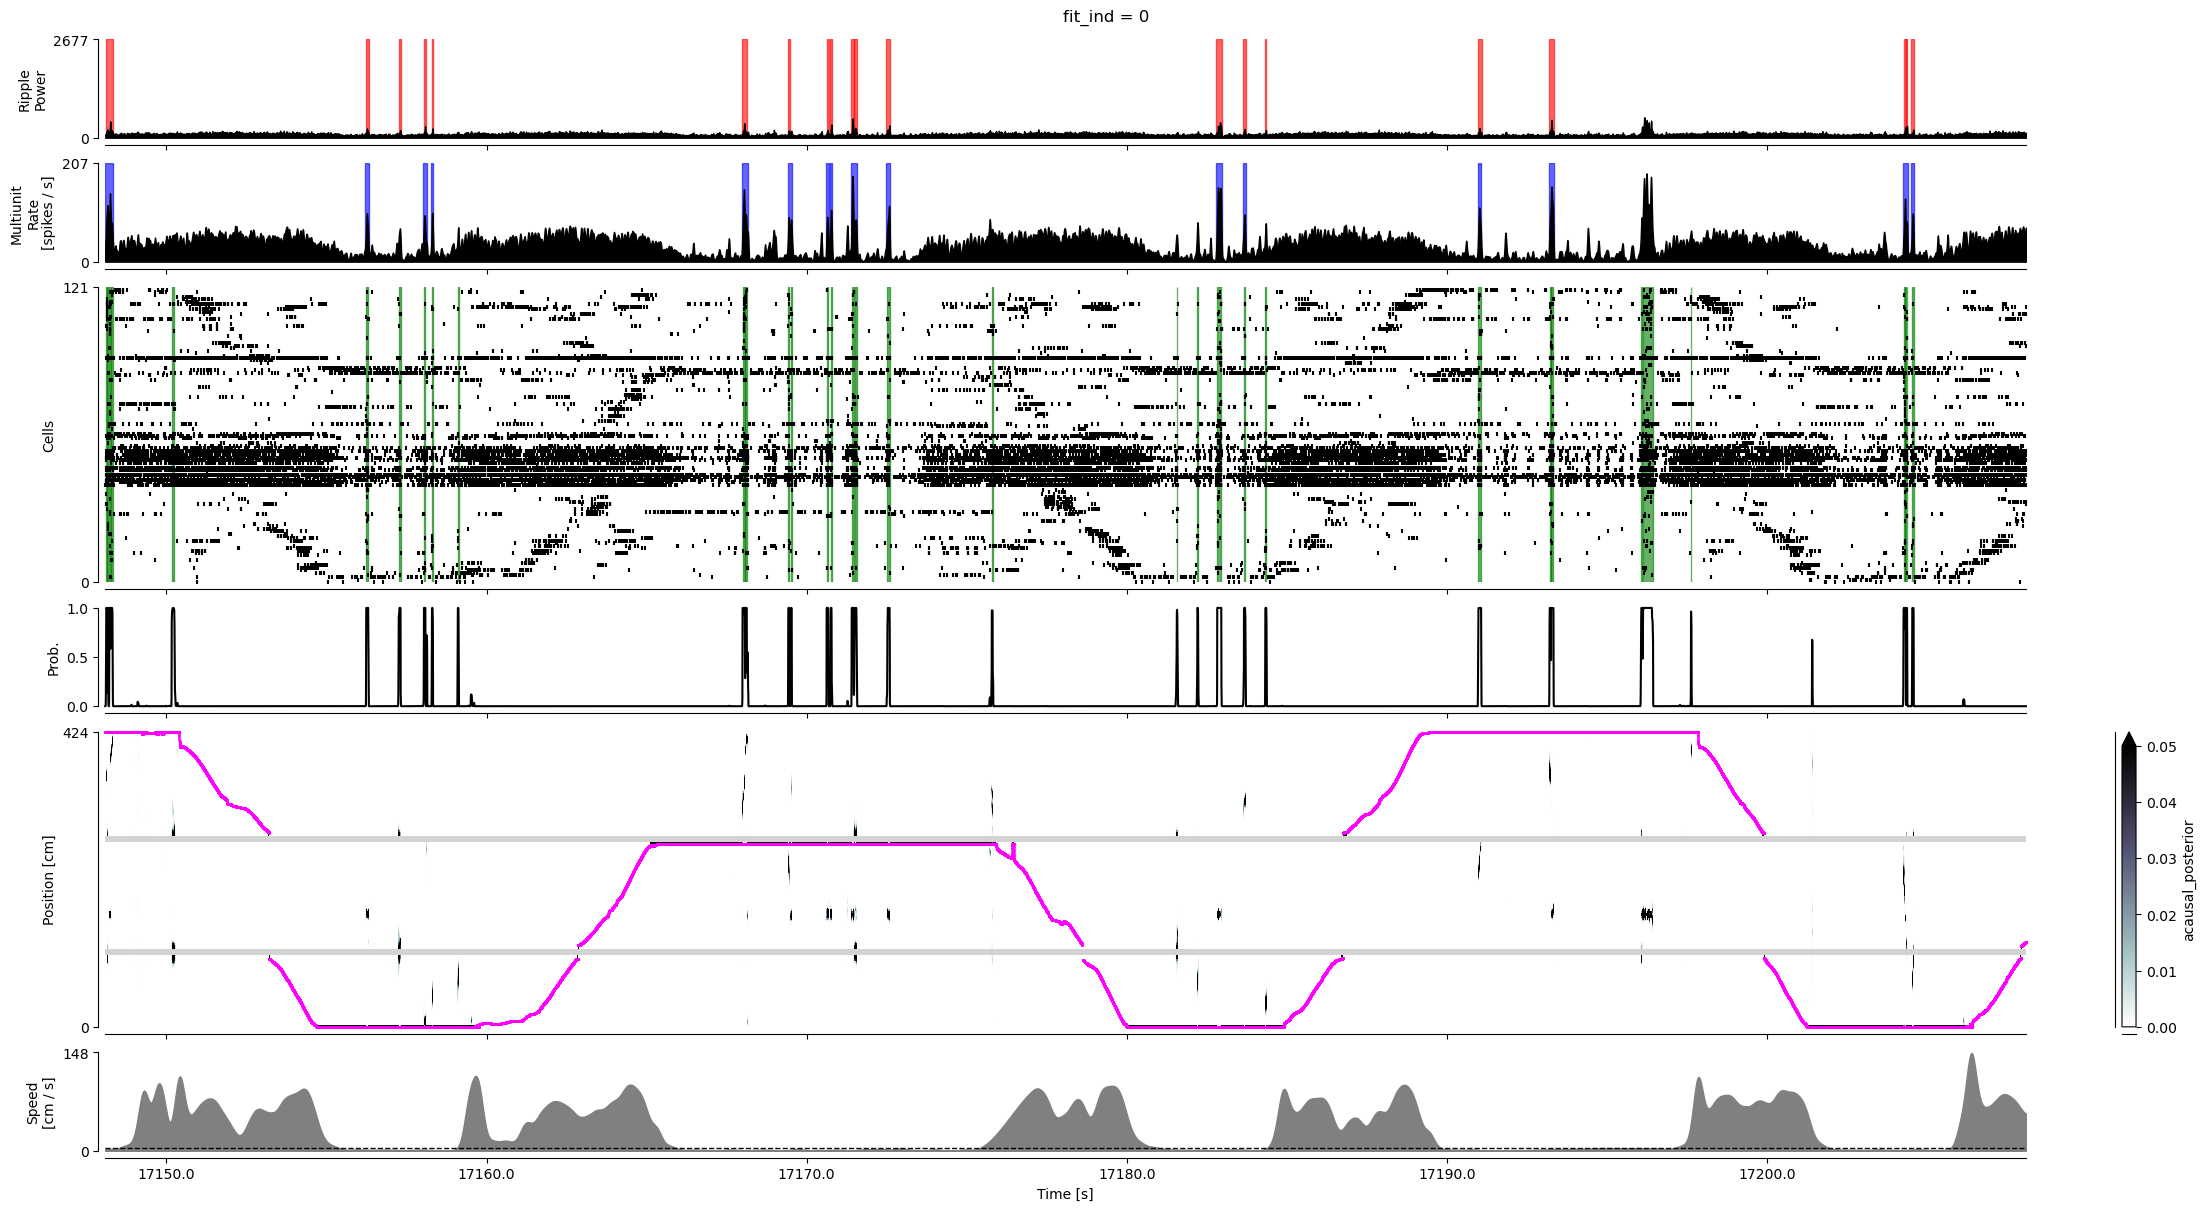

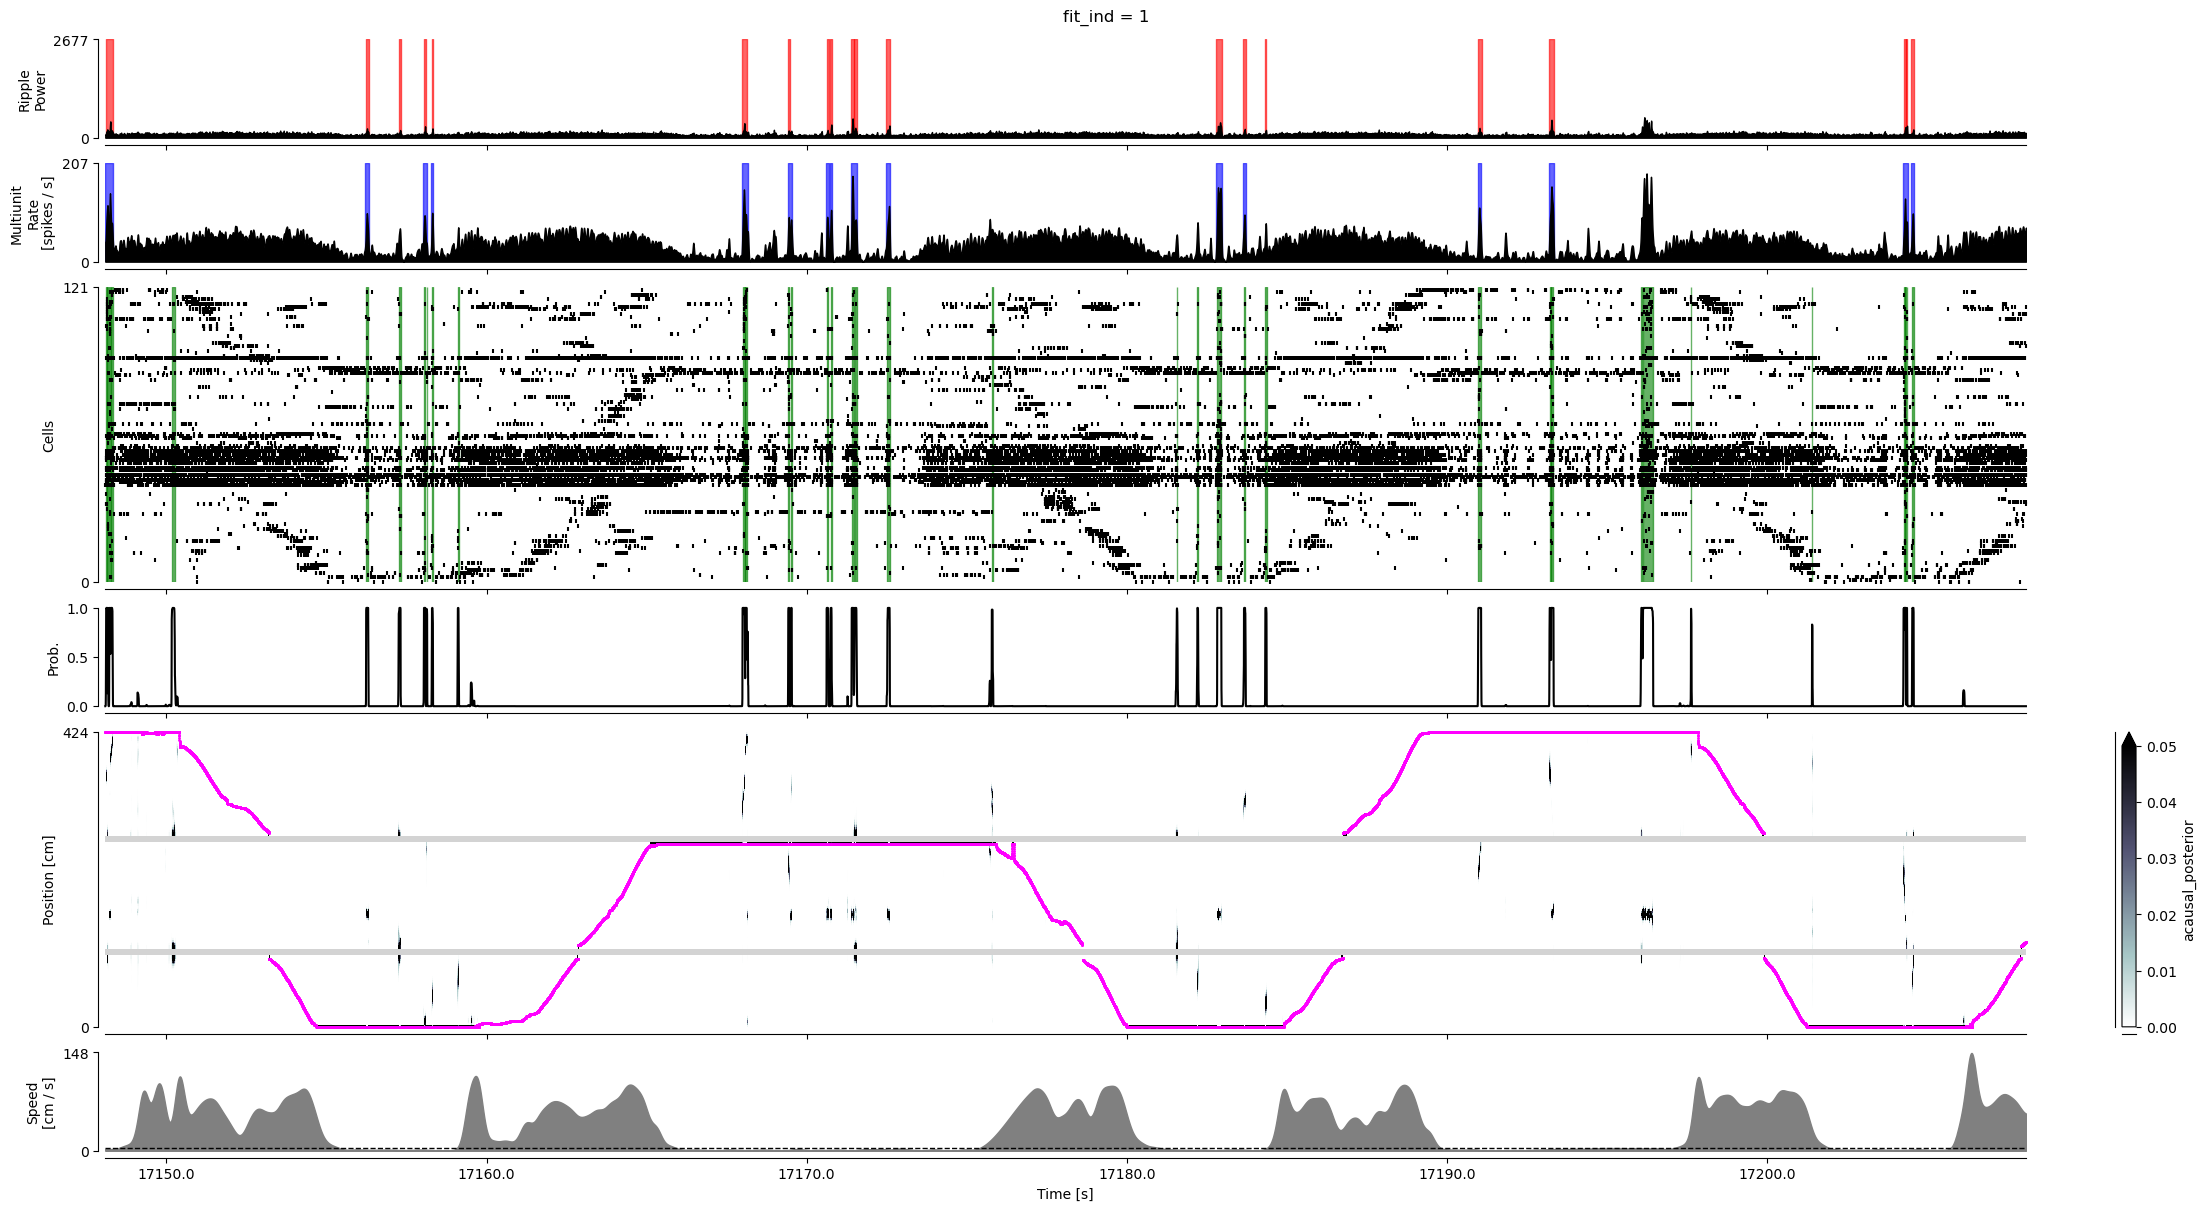

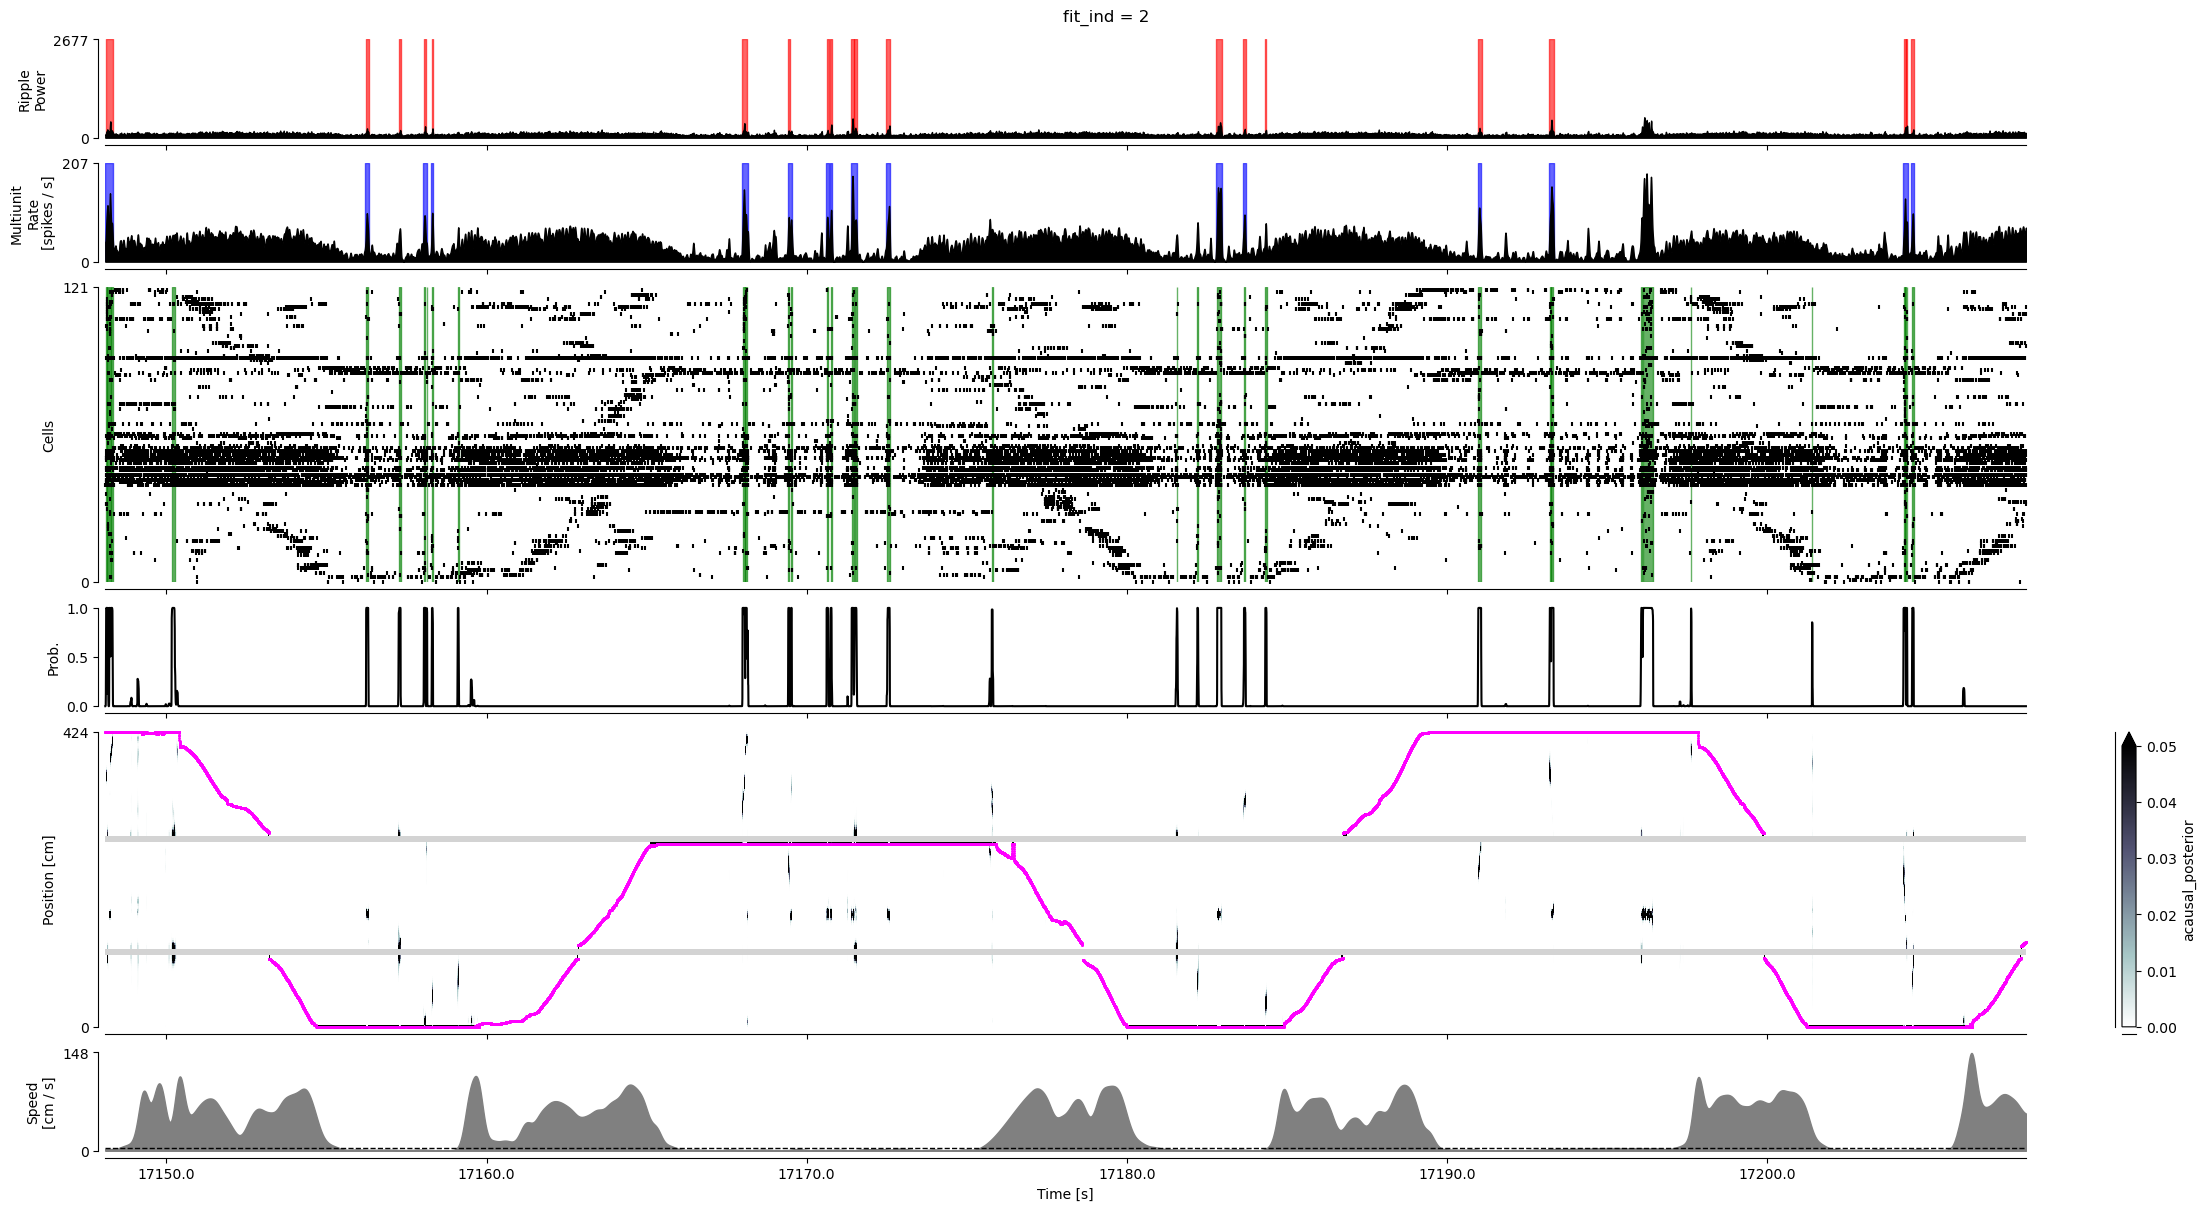

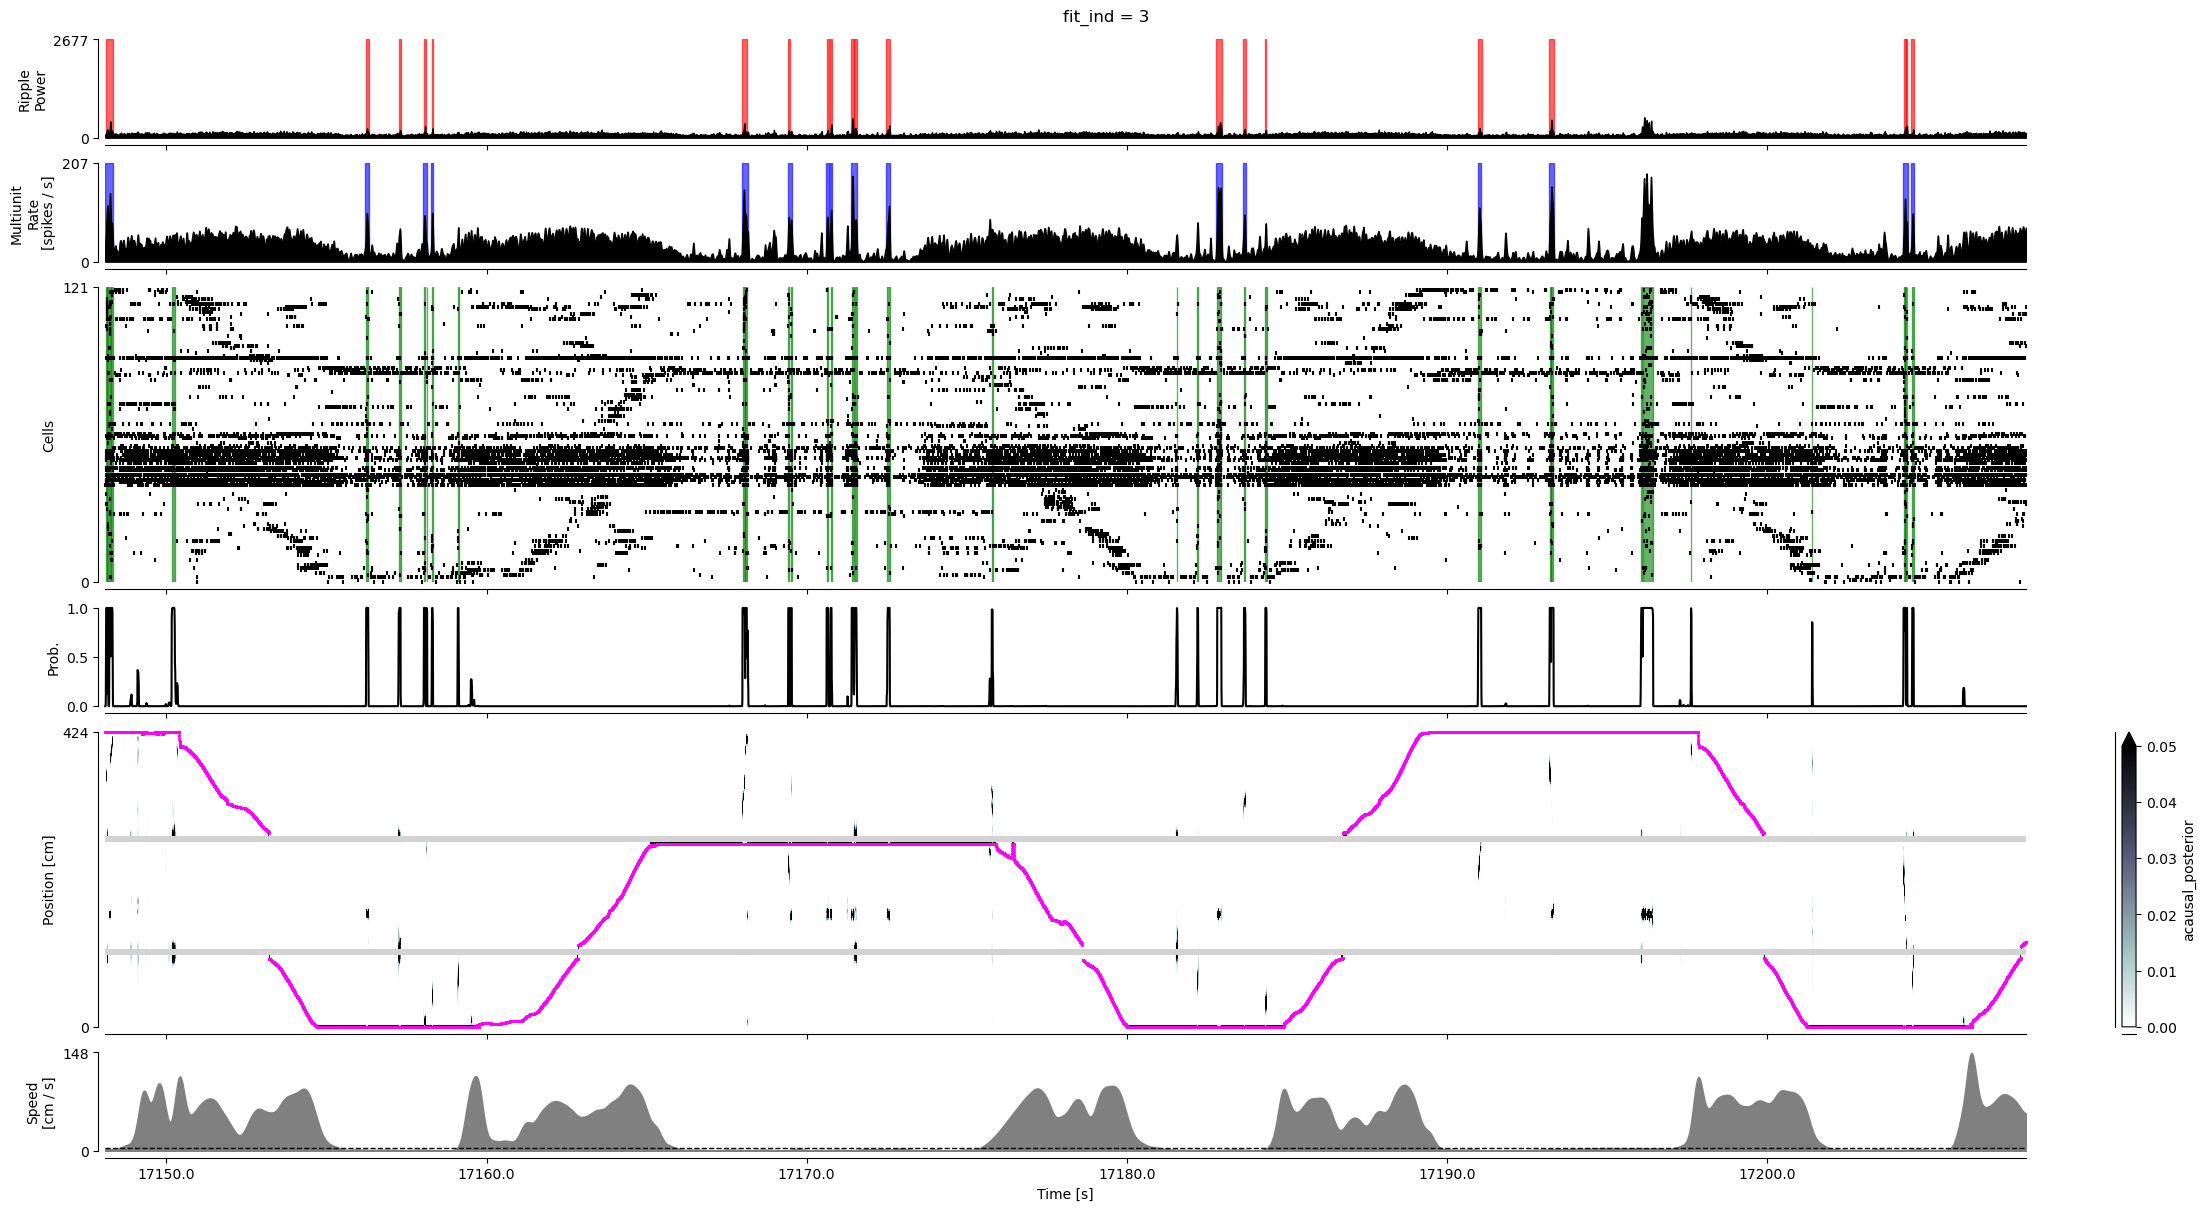

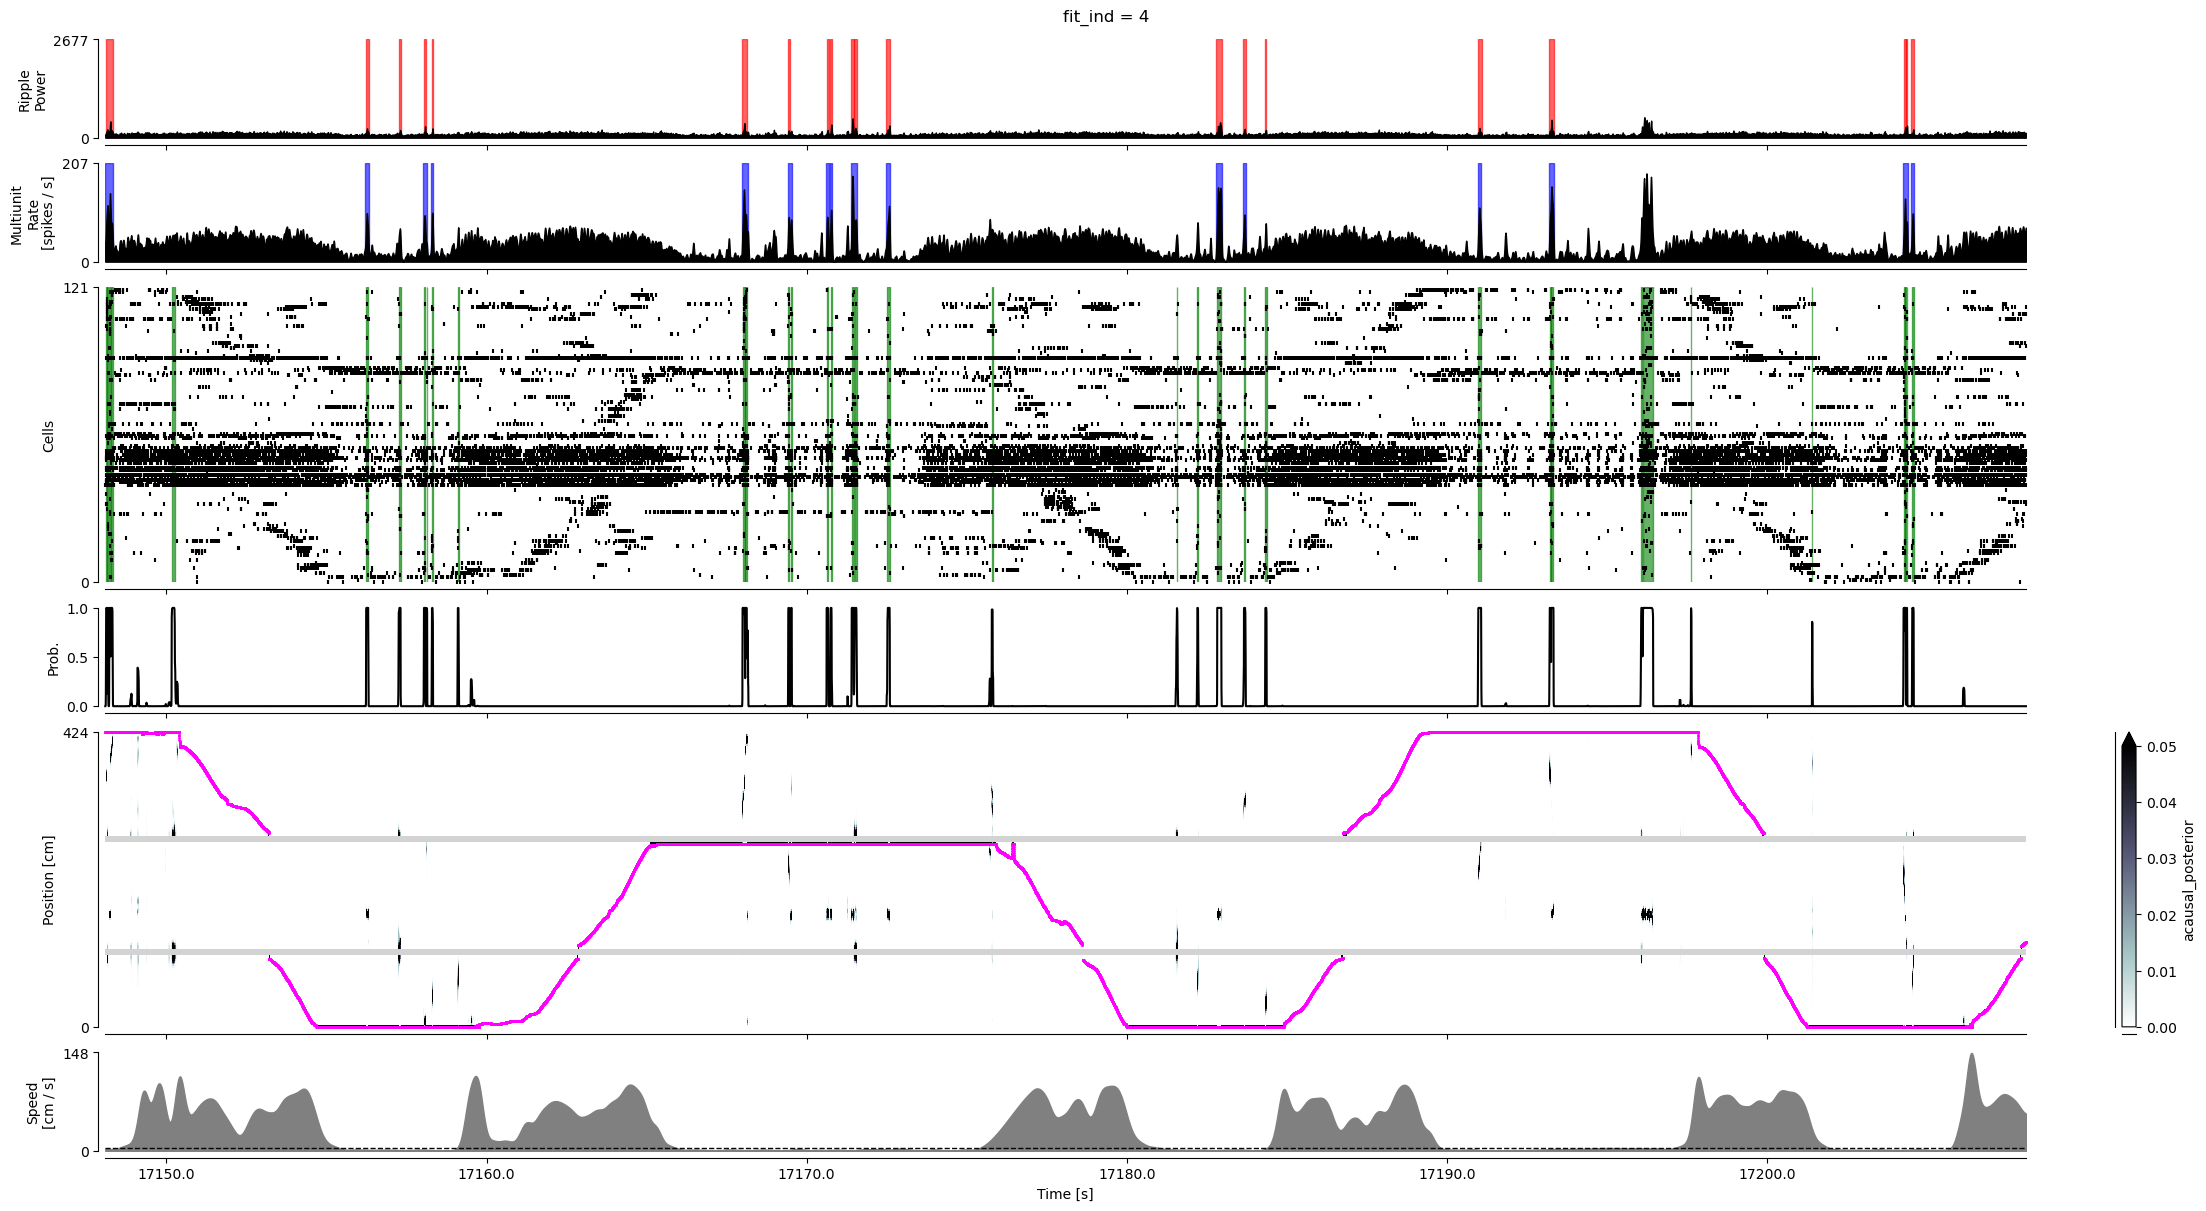

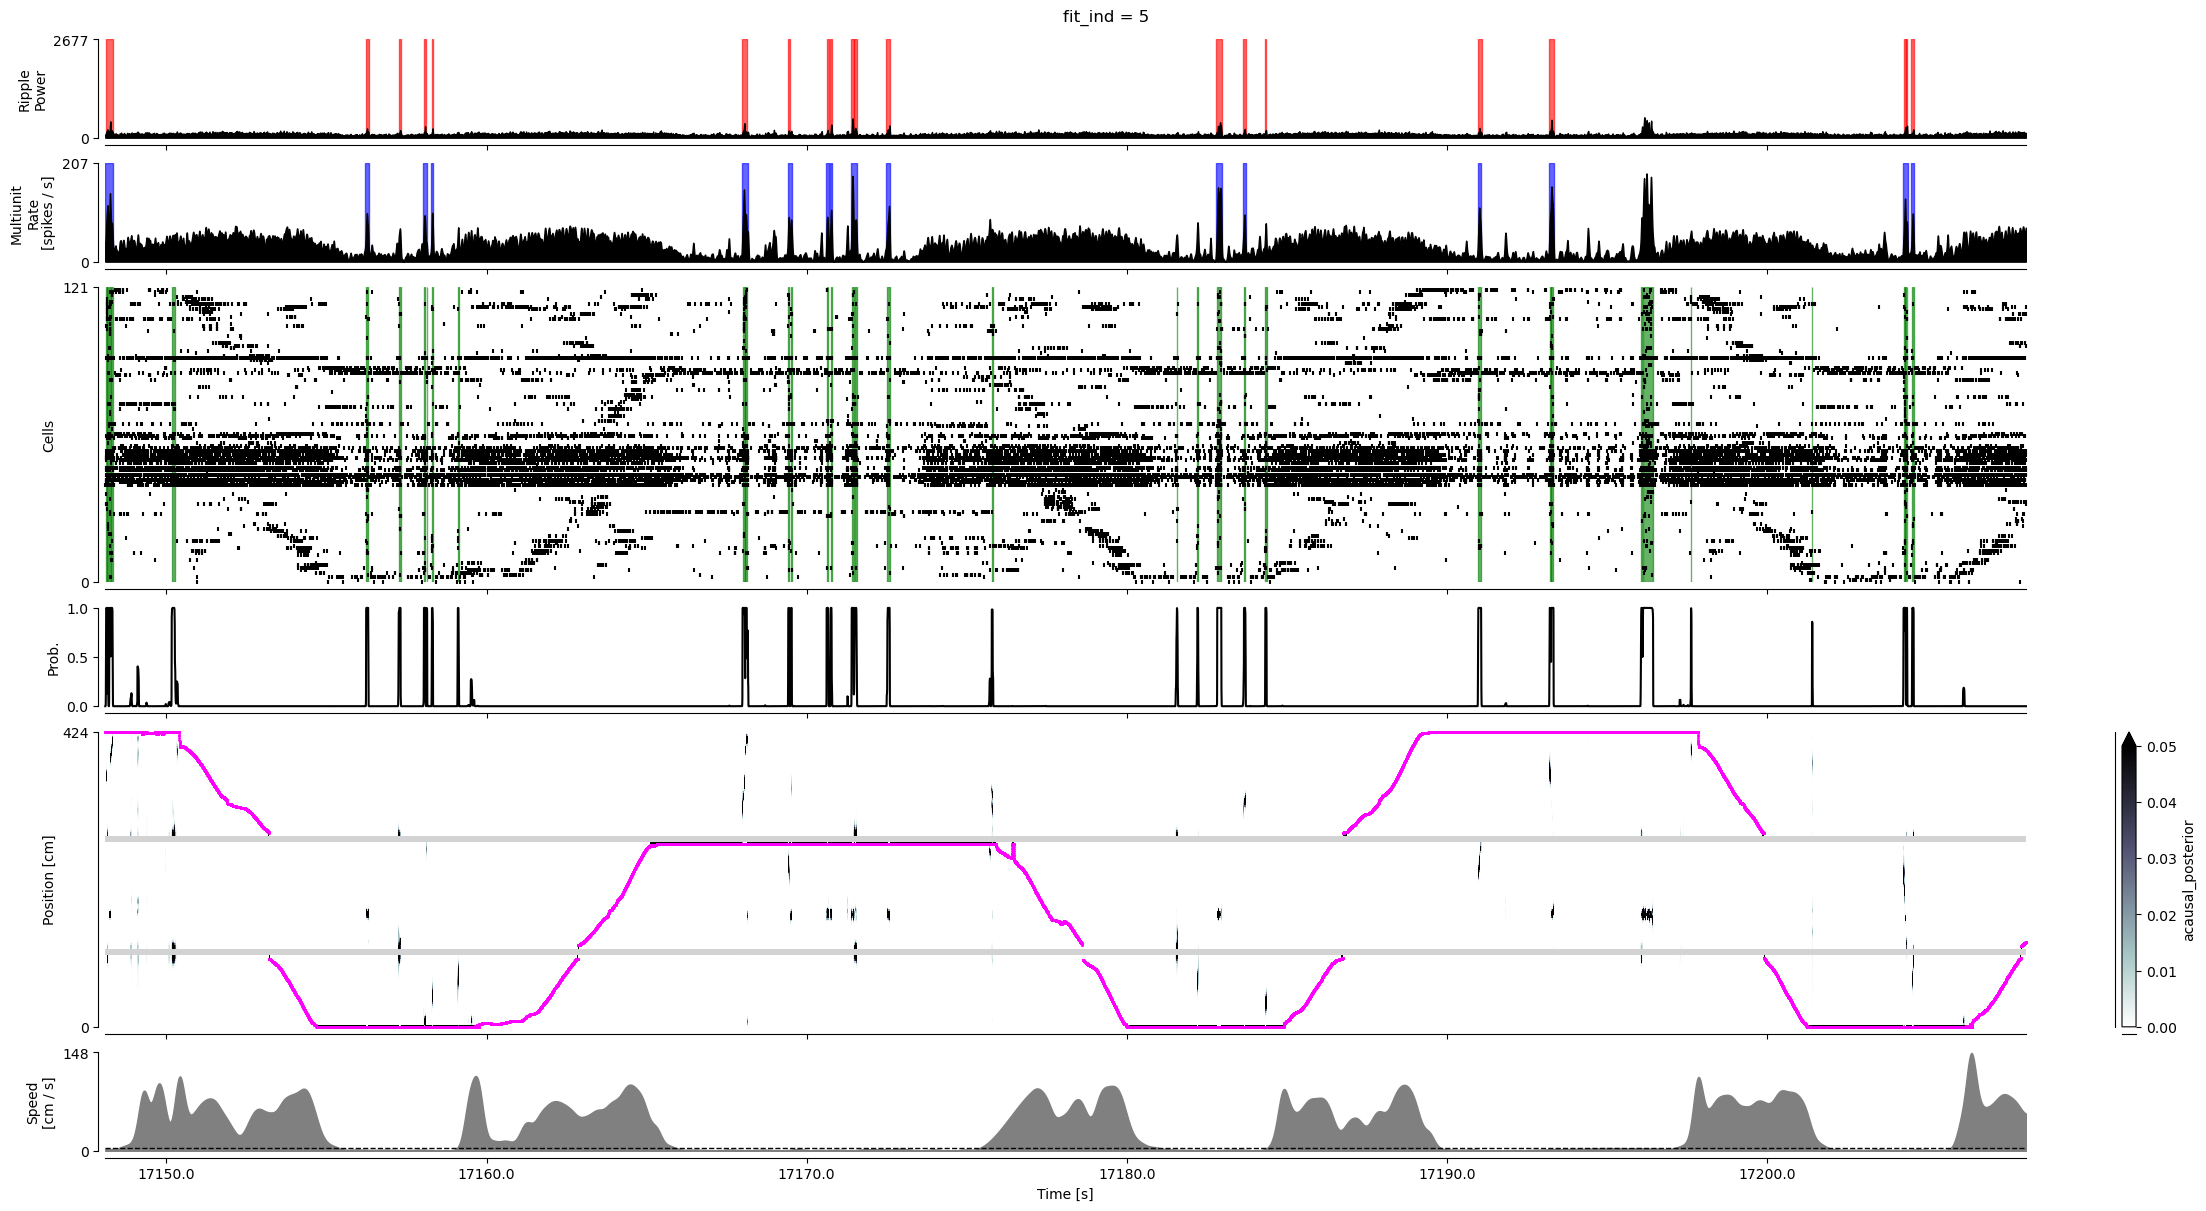

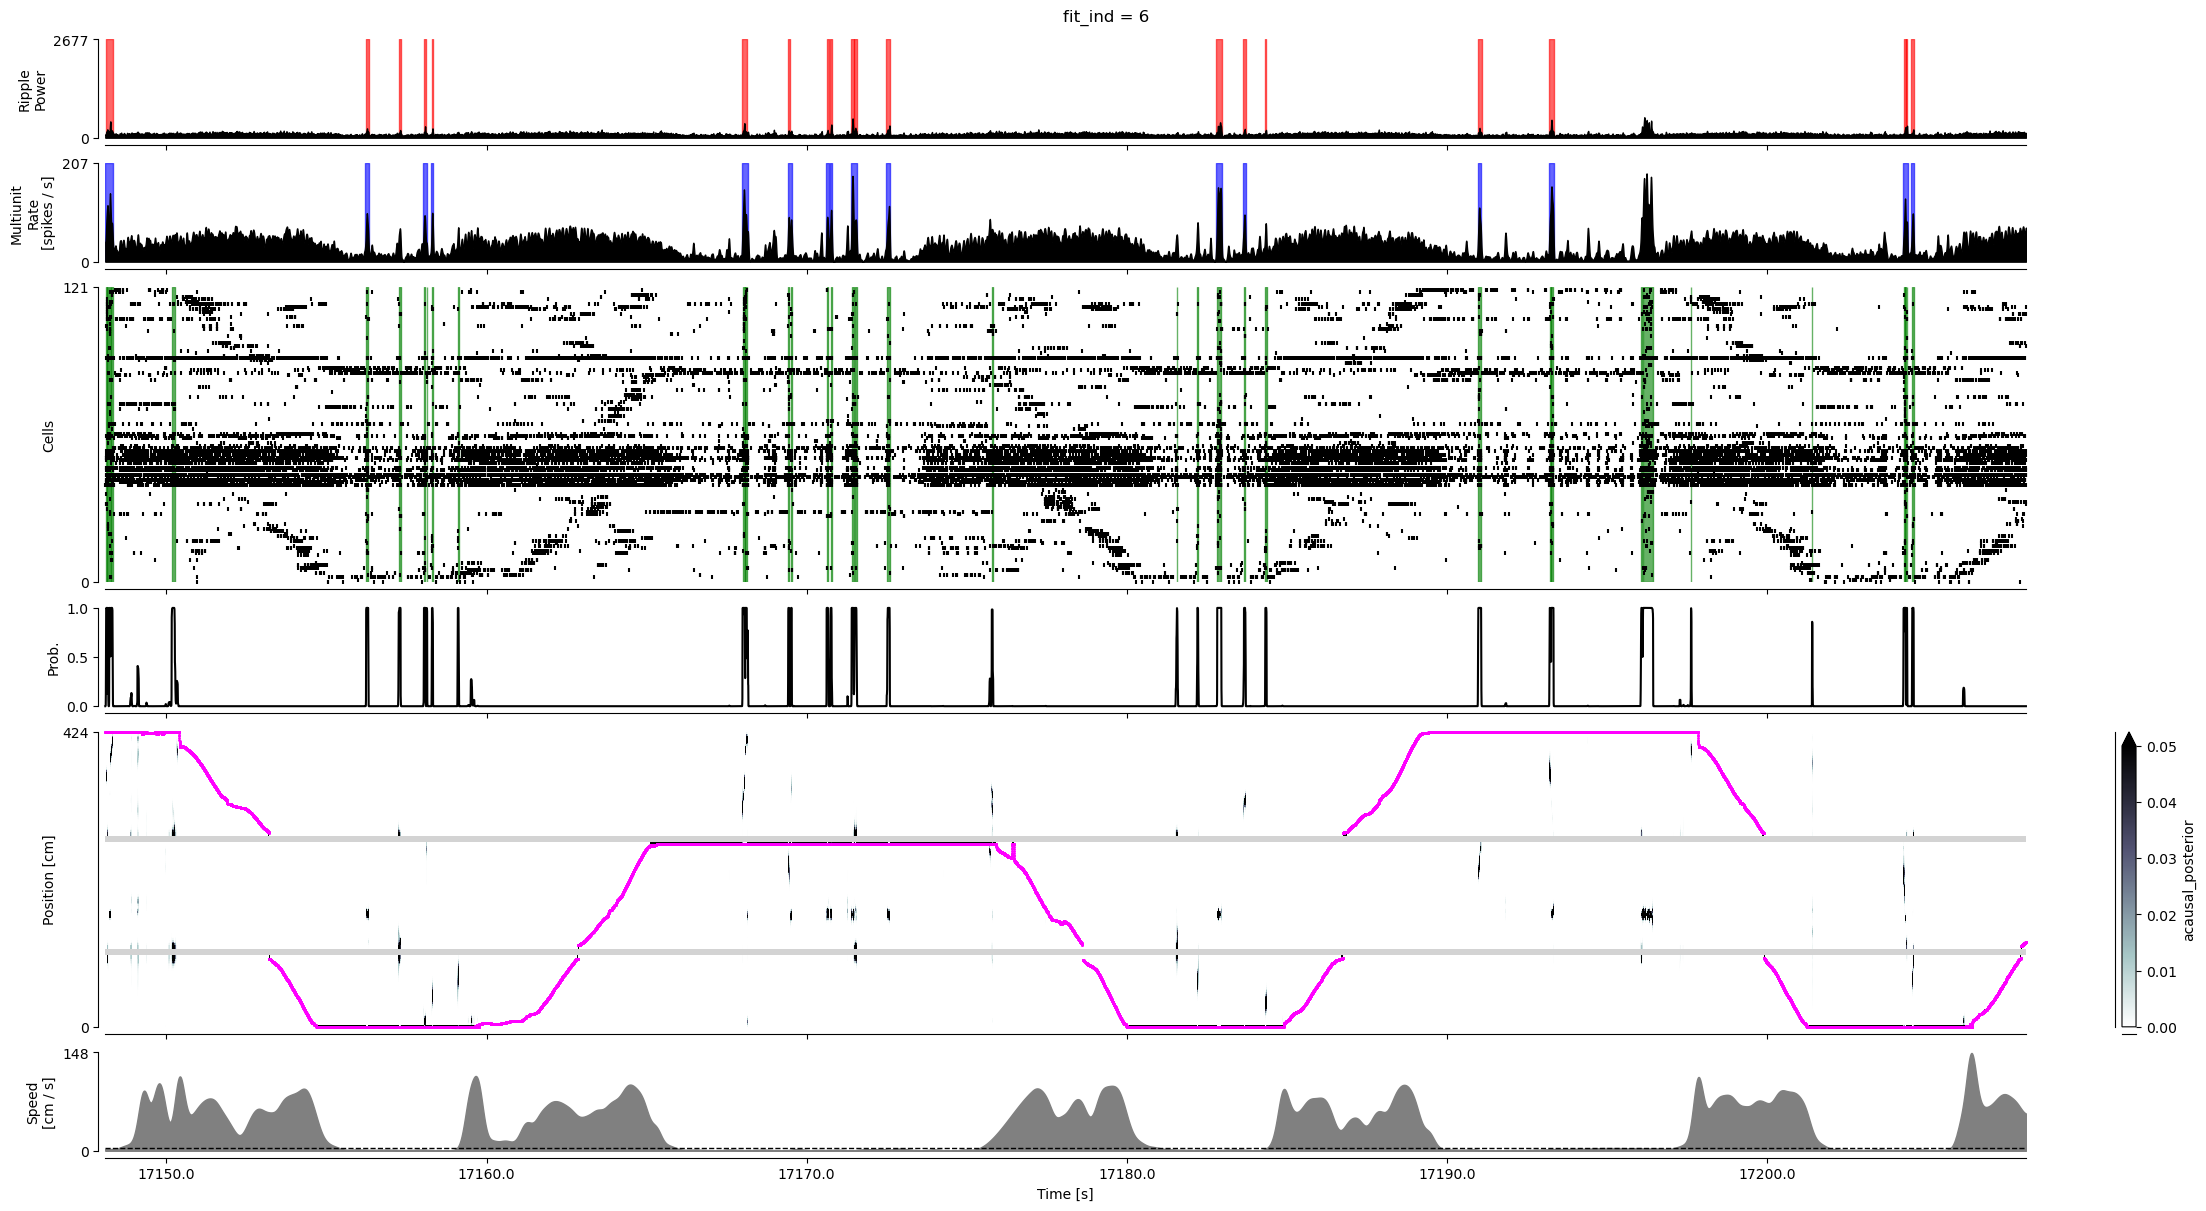

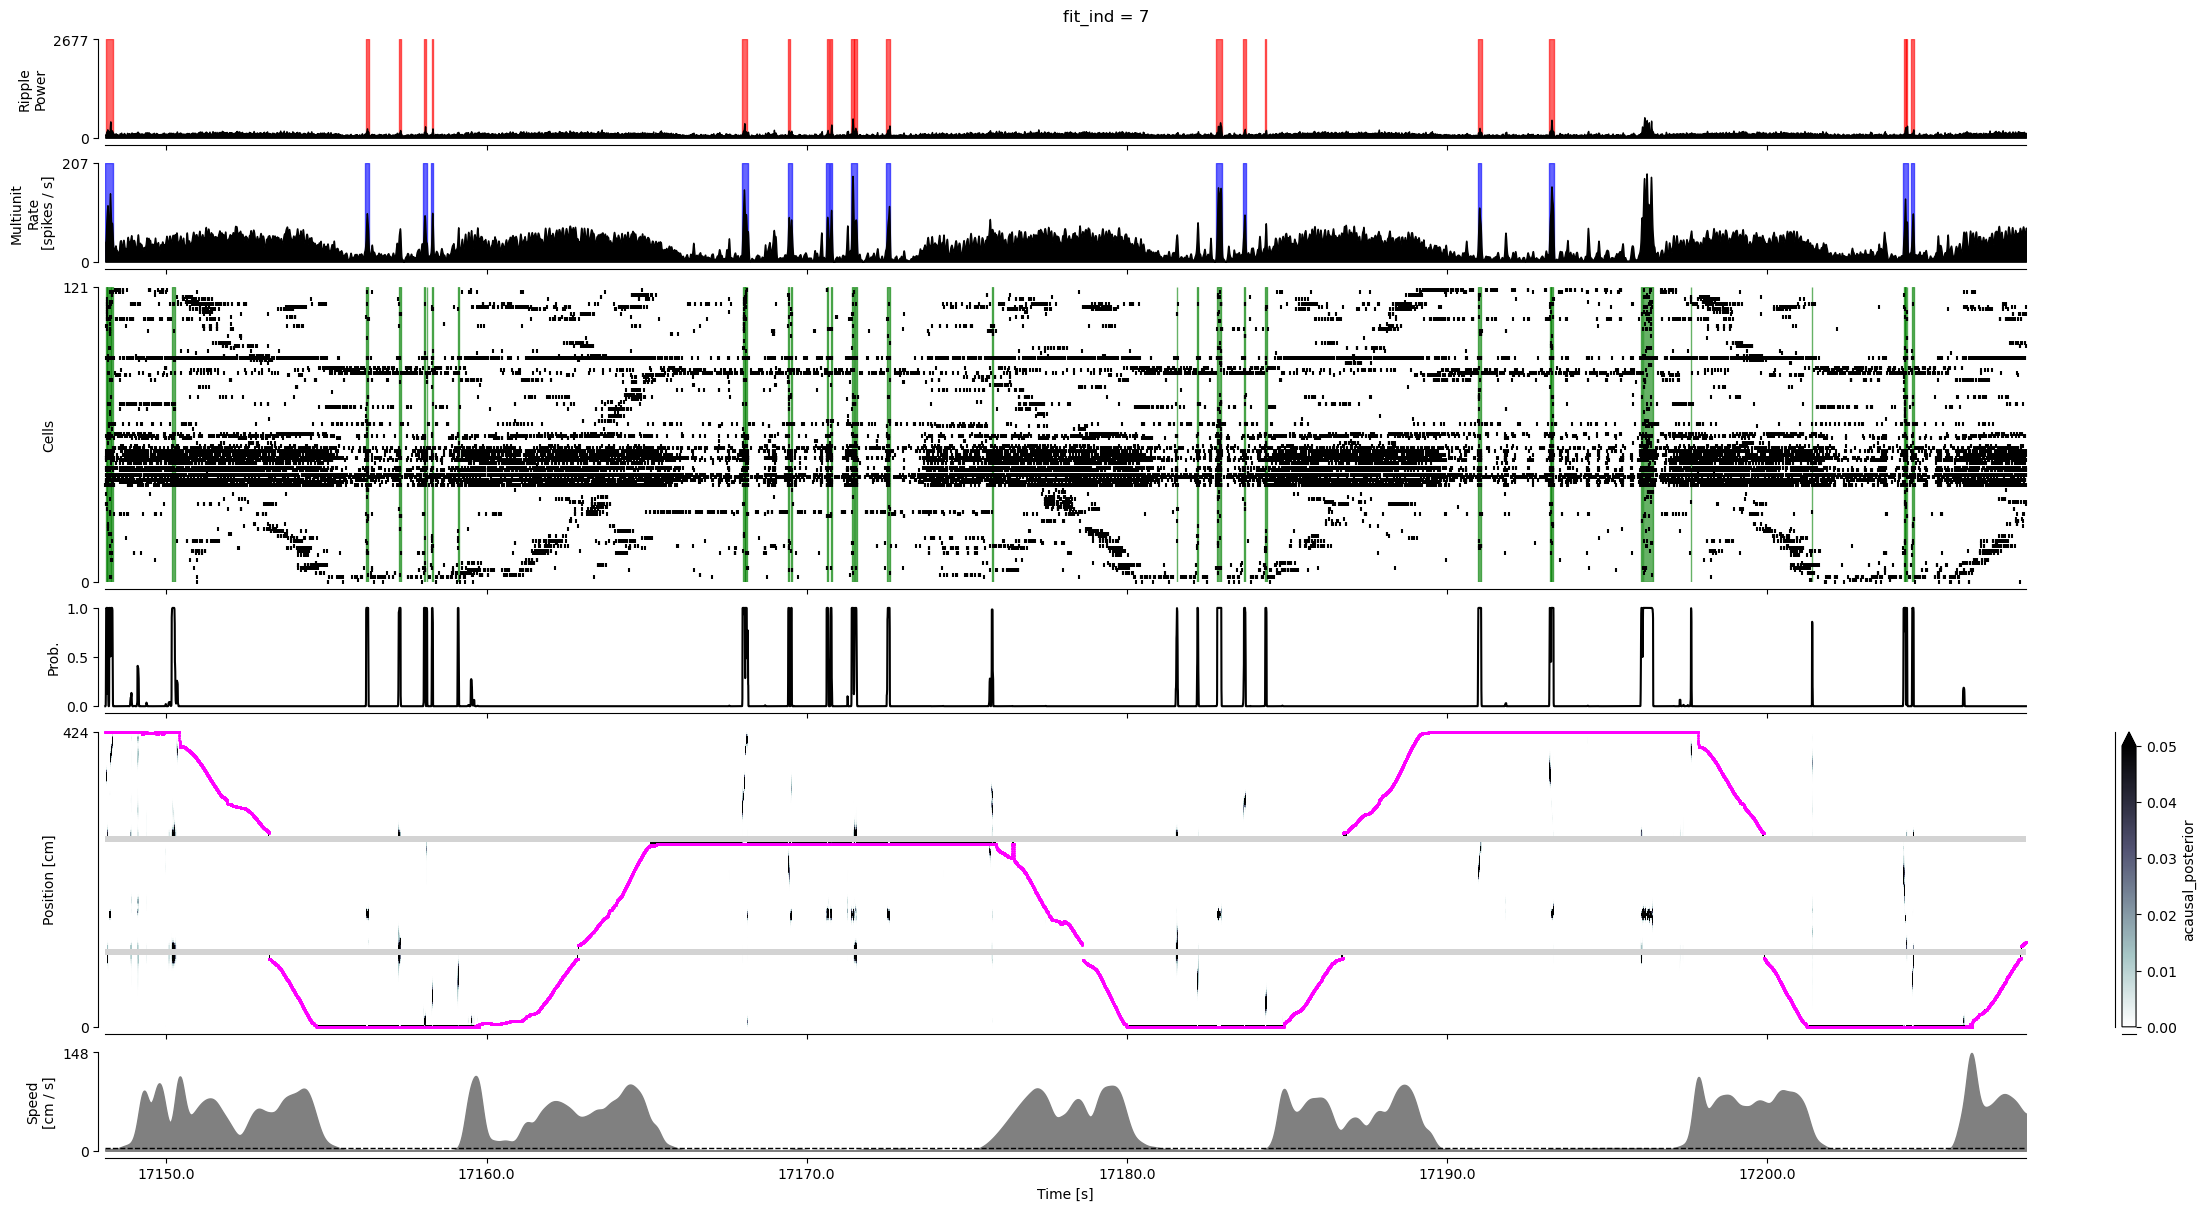

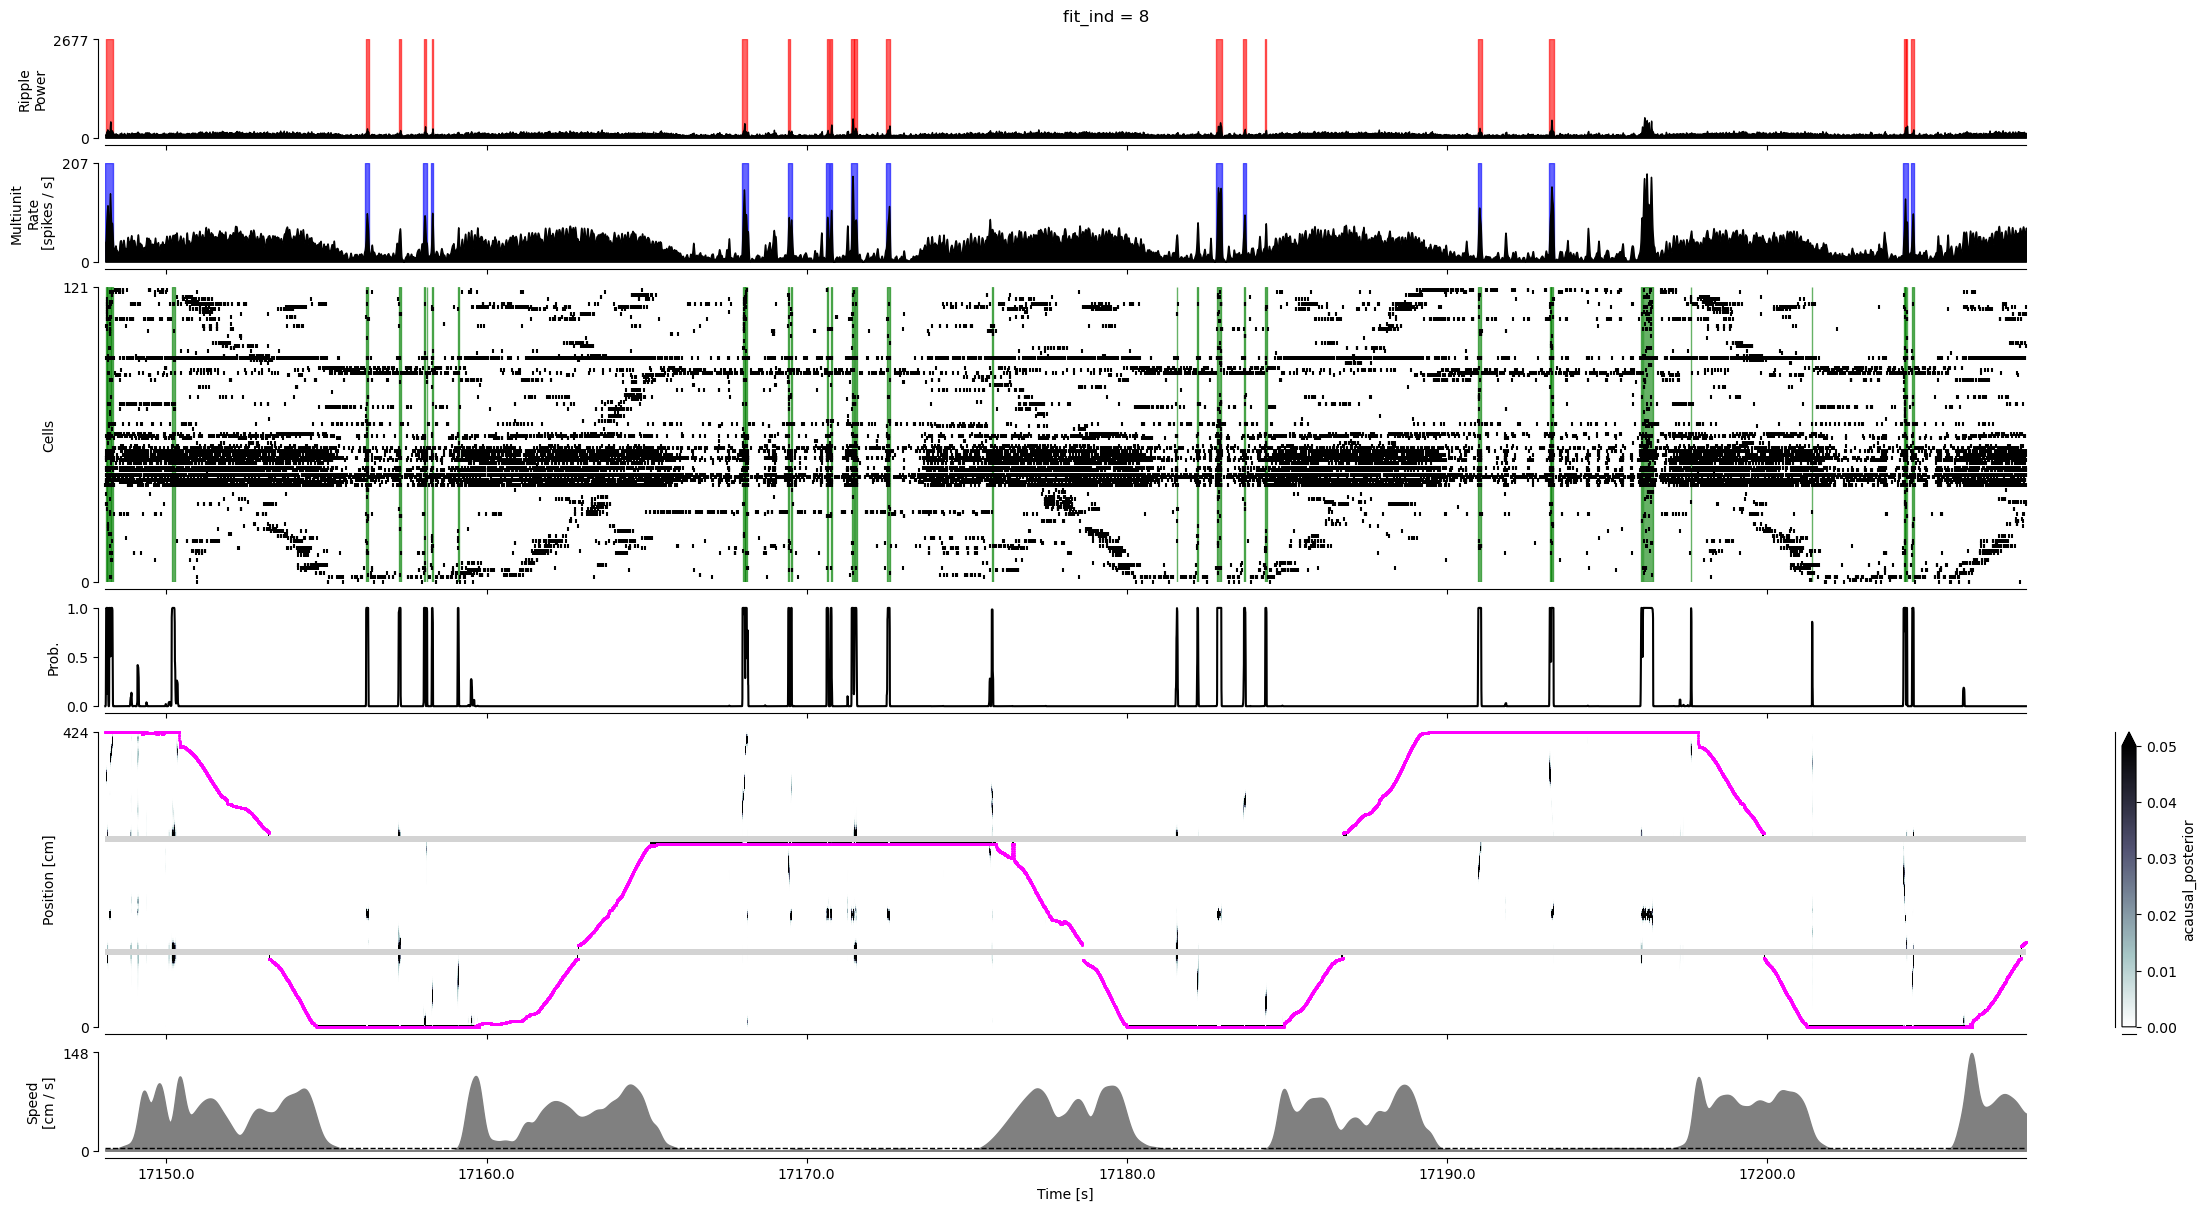

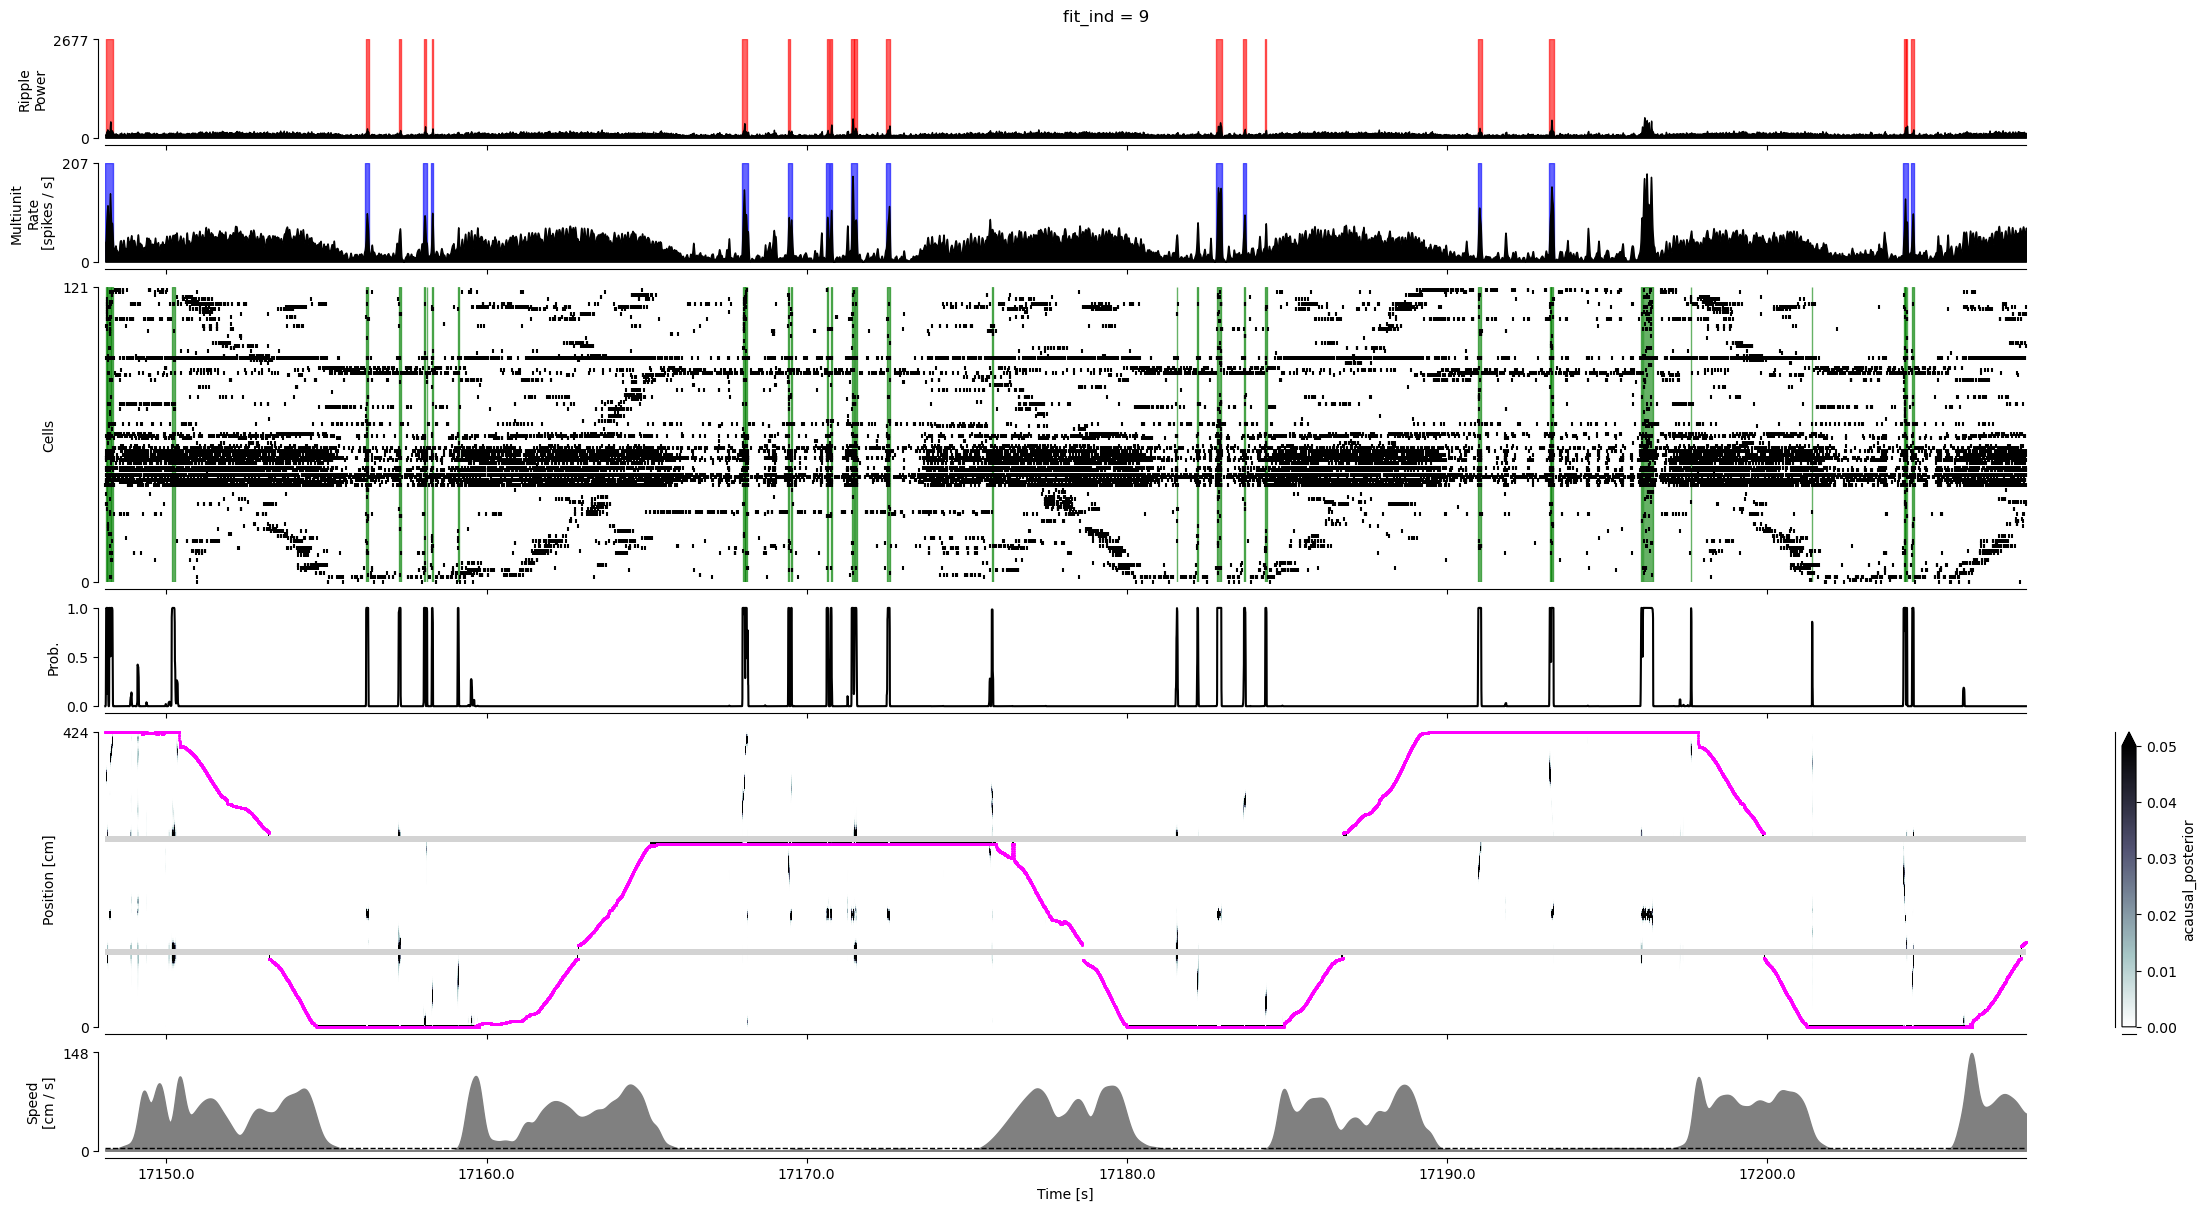

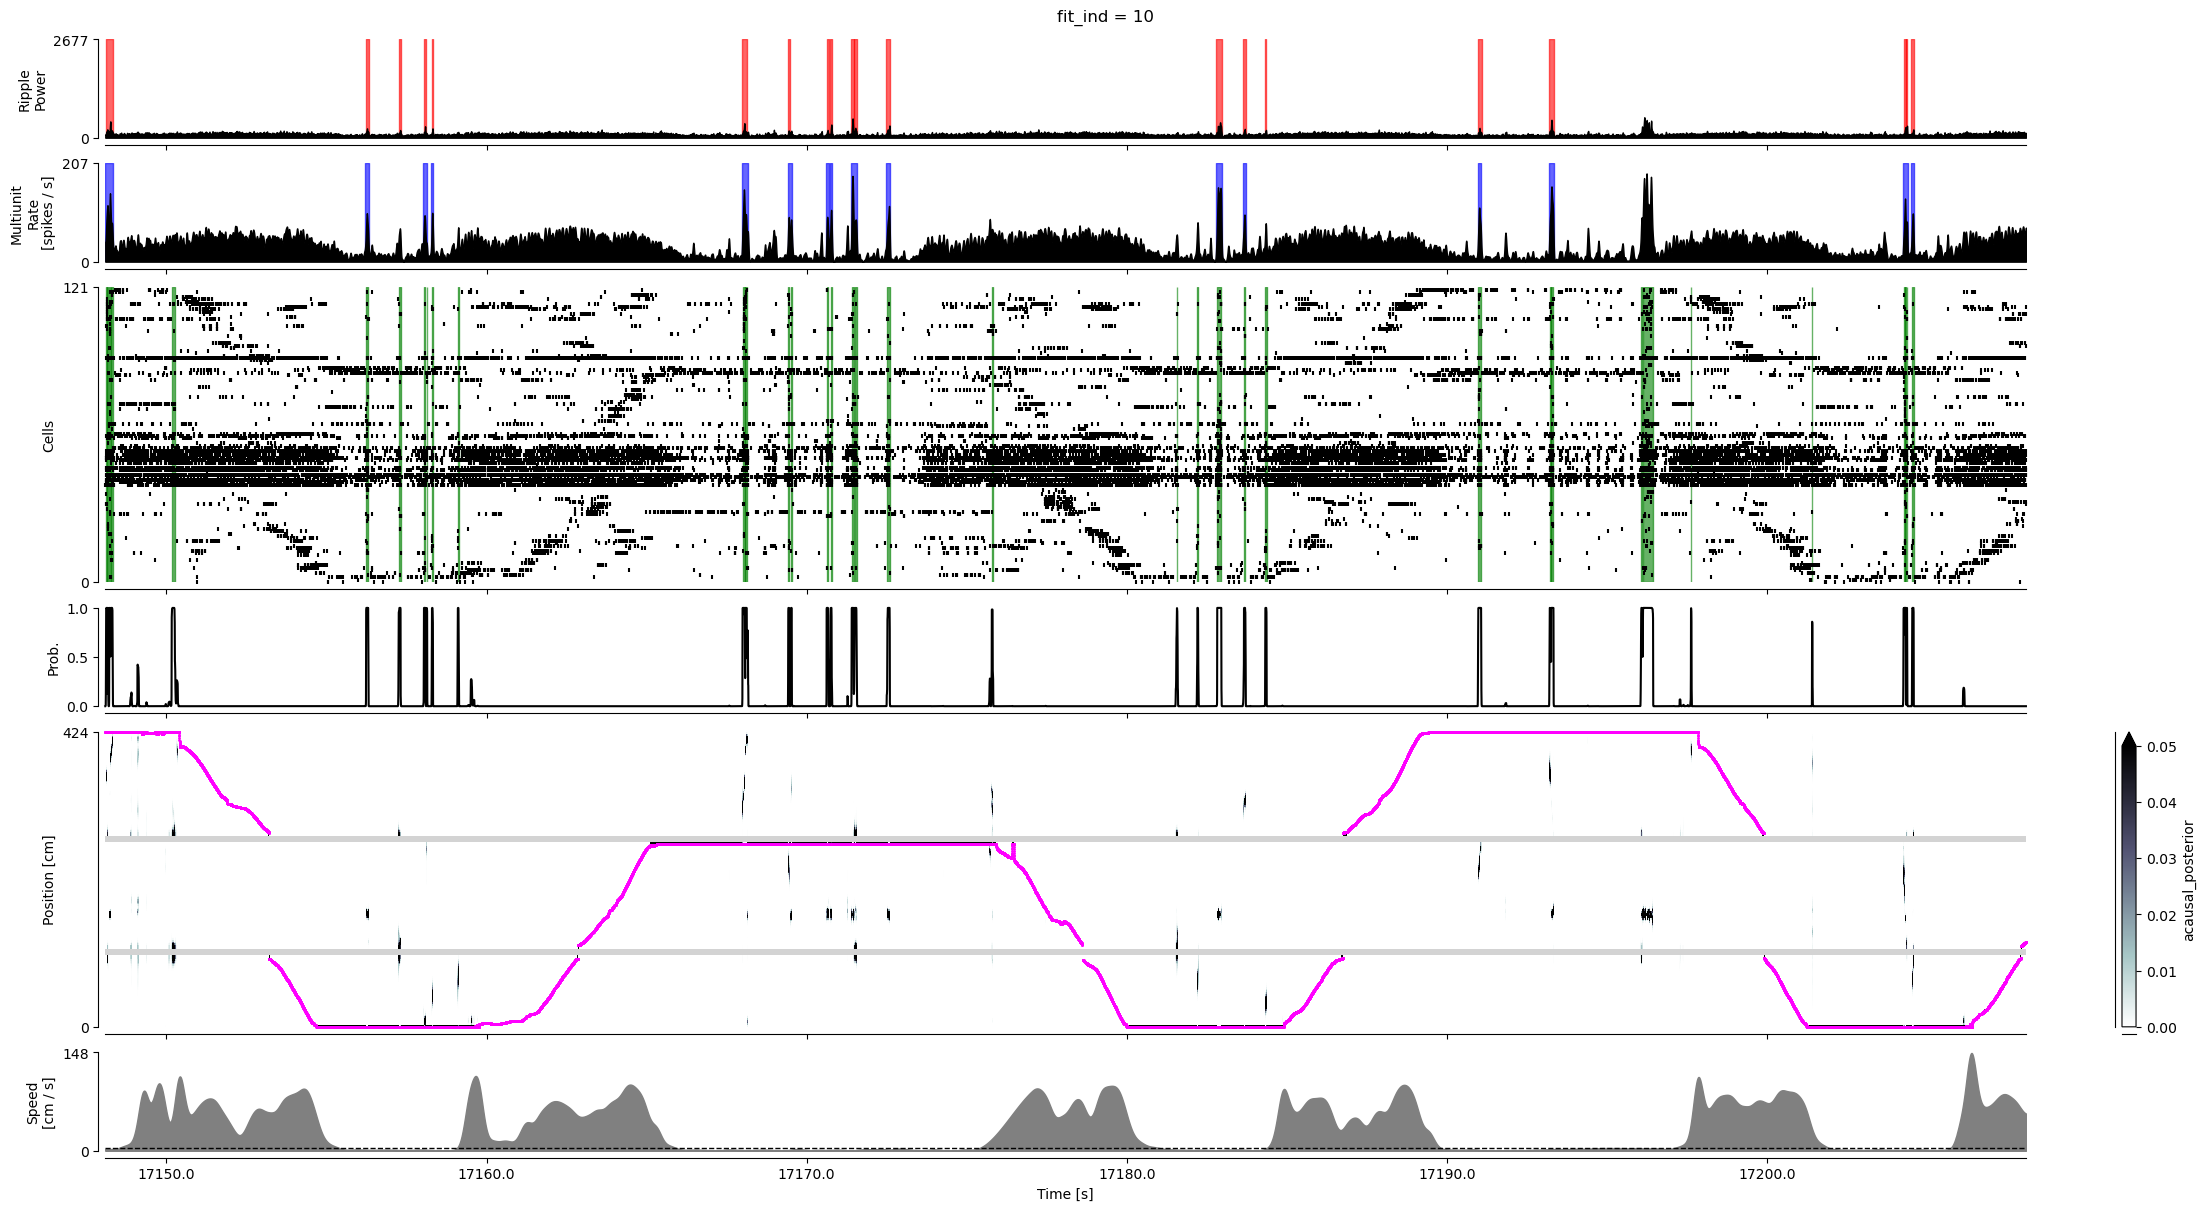

In [189]:
time_slice = slice(390_000, 420_000)
for fit_ind, (detector, result) in enumerate(zip(detectors, results)):
    plot_detector(time_slice, data, detector, result, figsize=(22, 12.0))
    plt.suptitle(f'fit_ind = {fit_ind}')
    plt.savefig(f'local_non_local_fit{fit_ind:02d}.png')

In [190]:
!ffmpeg -r 2 -f image2 -s 1920x1080 -i local_non_local_fit%02d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p local_non_local_fit7.mp4

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1634934299653/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1634934299653/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1634934299653/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.

Text(0, 0.5, 'Rate [spikes / s]')

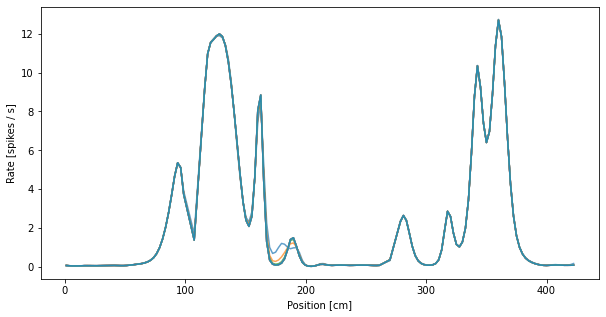

In [191]:
neuron_ind = 80

fig, ax = plt.subplots(figsize=(10, 5))
for detector in detectors:
    place_conditional_intensity = (
        detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()

    ax.plot(detector.place_bin_centers_, place_conditional_intensity[:, neuron_ind] * 500,
            alpha=0.7)
ax.set_xlabel('Position [cm]')
ax.set_ylabel('Rate [spikes / s]')

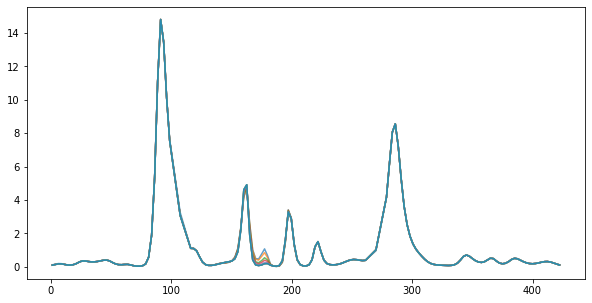

In [187]:
neuron_ind = 84

fig, ax = plt.subplots(figsize=(10, 5))
for detector in detectors:
    place_conditional_intensity = (
        detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()

    ax.plot(detector.place_bin_centers_, place_conditional_intensity[:, neuron_ind] * 500,
            alpha=0.7)


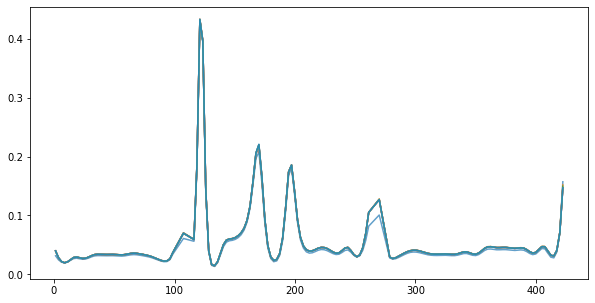

In [188]:
neuron_ind = 120

fig, ax = plt.subplots(figsize=(10, 5))
for detector in detectors:
    place_conditional_intensity = (
        detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()

    ax.plot(detector.place_bin_centers_, place_conditional_intensity[:, neuron_ind] * 500,
            alpha=0.7)


In [93]:
place_conditional_intensity.shape

(161, 121)

In [134]:
data.keys()

dict_keys(['position_info', 'tetrode_info', 'neuron_info', 'spikes', 'dio', 'dio_indicator', 'track_graph', 'edge_order', 'edge_spacing', 'ripple_times', 'ripple_labels', 'ripple_filtered_lfps', 'ripple_consensus_trace', 'ripple_lfps', 'ripple_consensus_trace_zscore', 'instantaneous_ripple_power_change', 'is_ripple', 'multiunits', 'multiunit_spikes', 'multiunit_firing_rate', 'multiunit_high_synchrony_times', 'multiunit_high_synchrony_labels', 'multiunit_rate_change', 'multiunit_rate_zscore', 'is_multiunit_high_synchrony'])

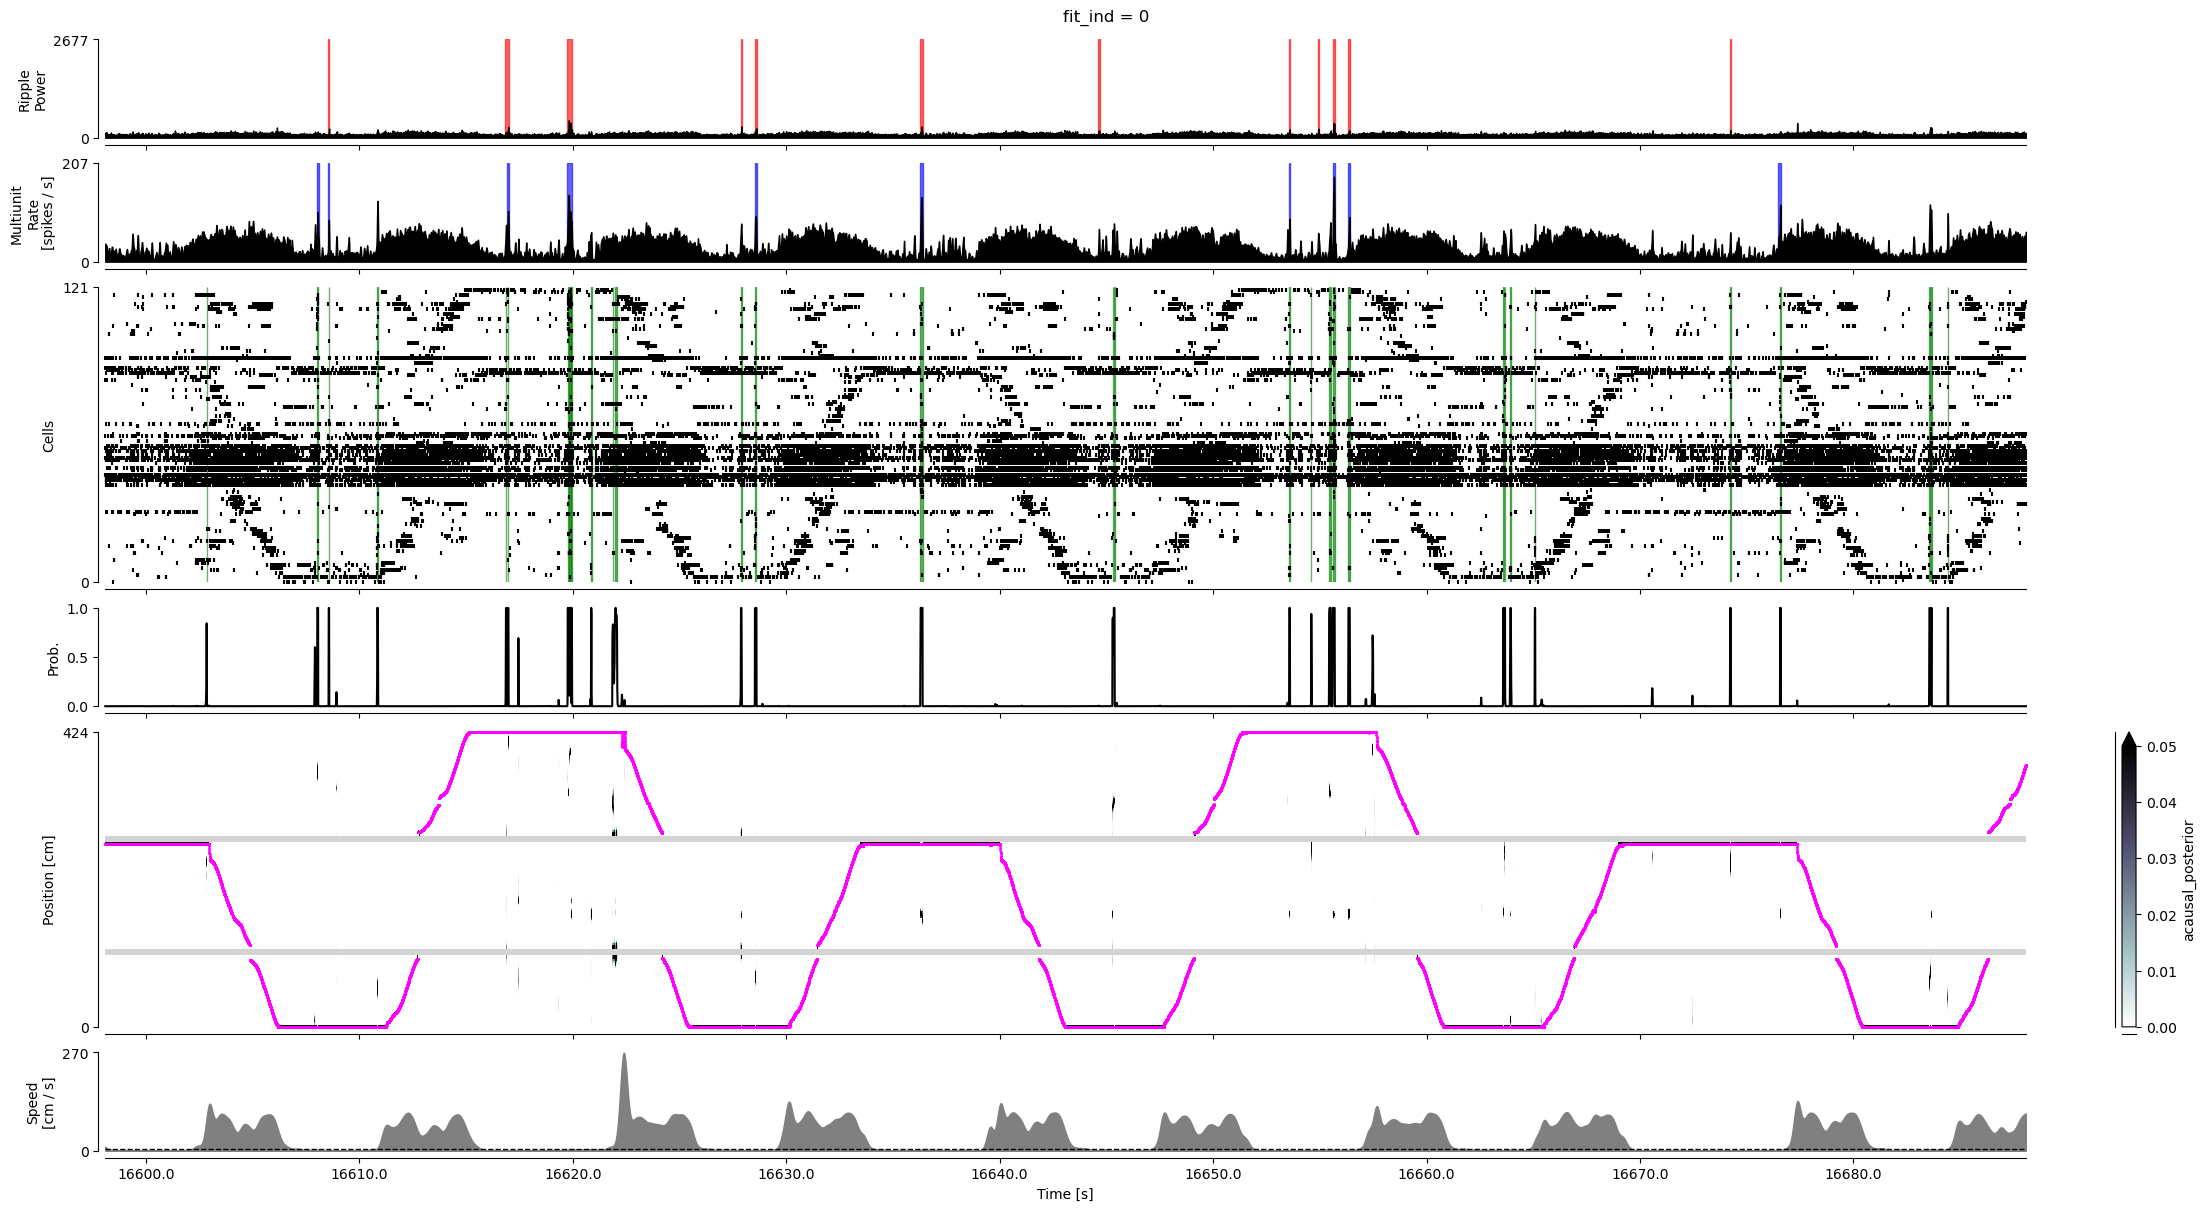

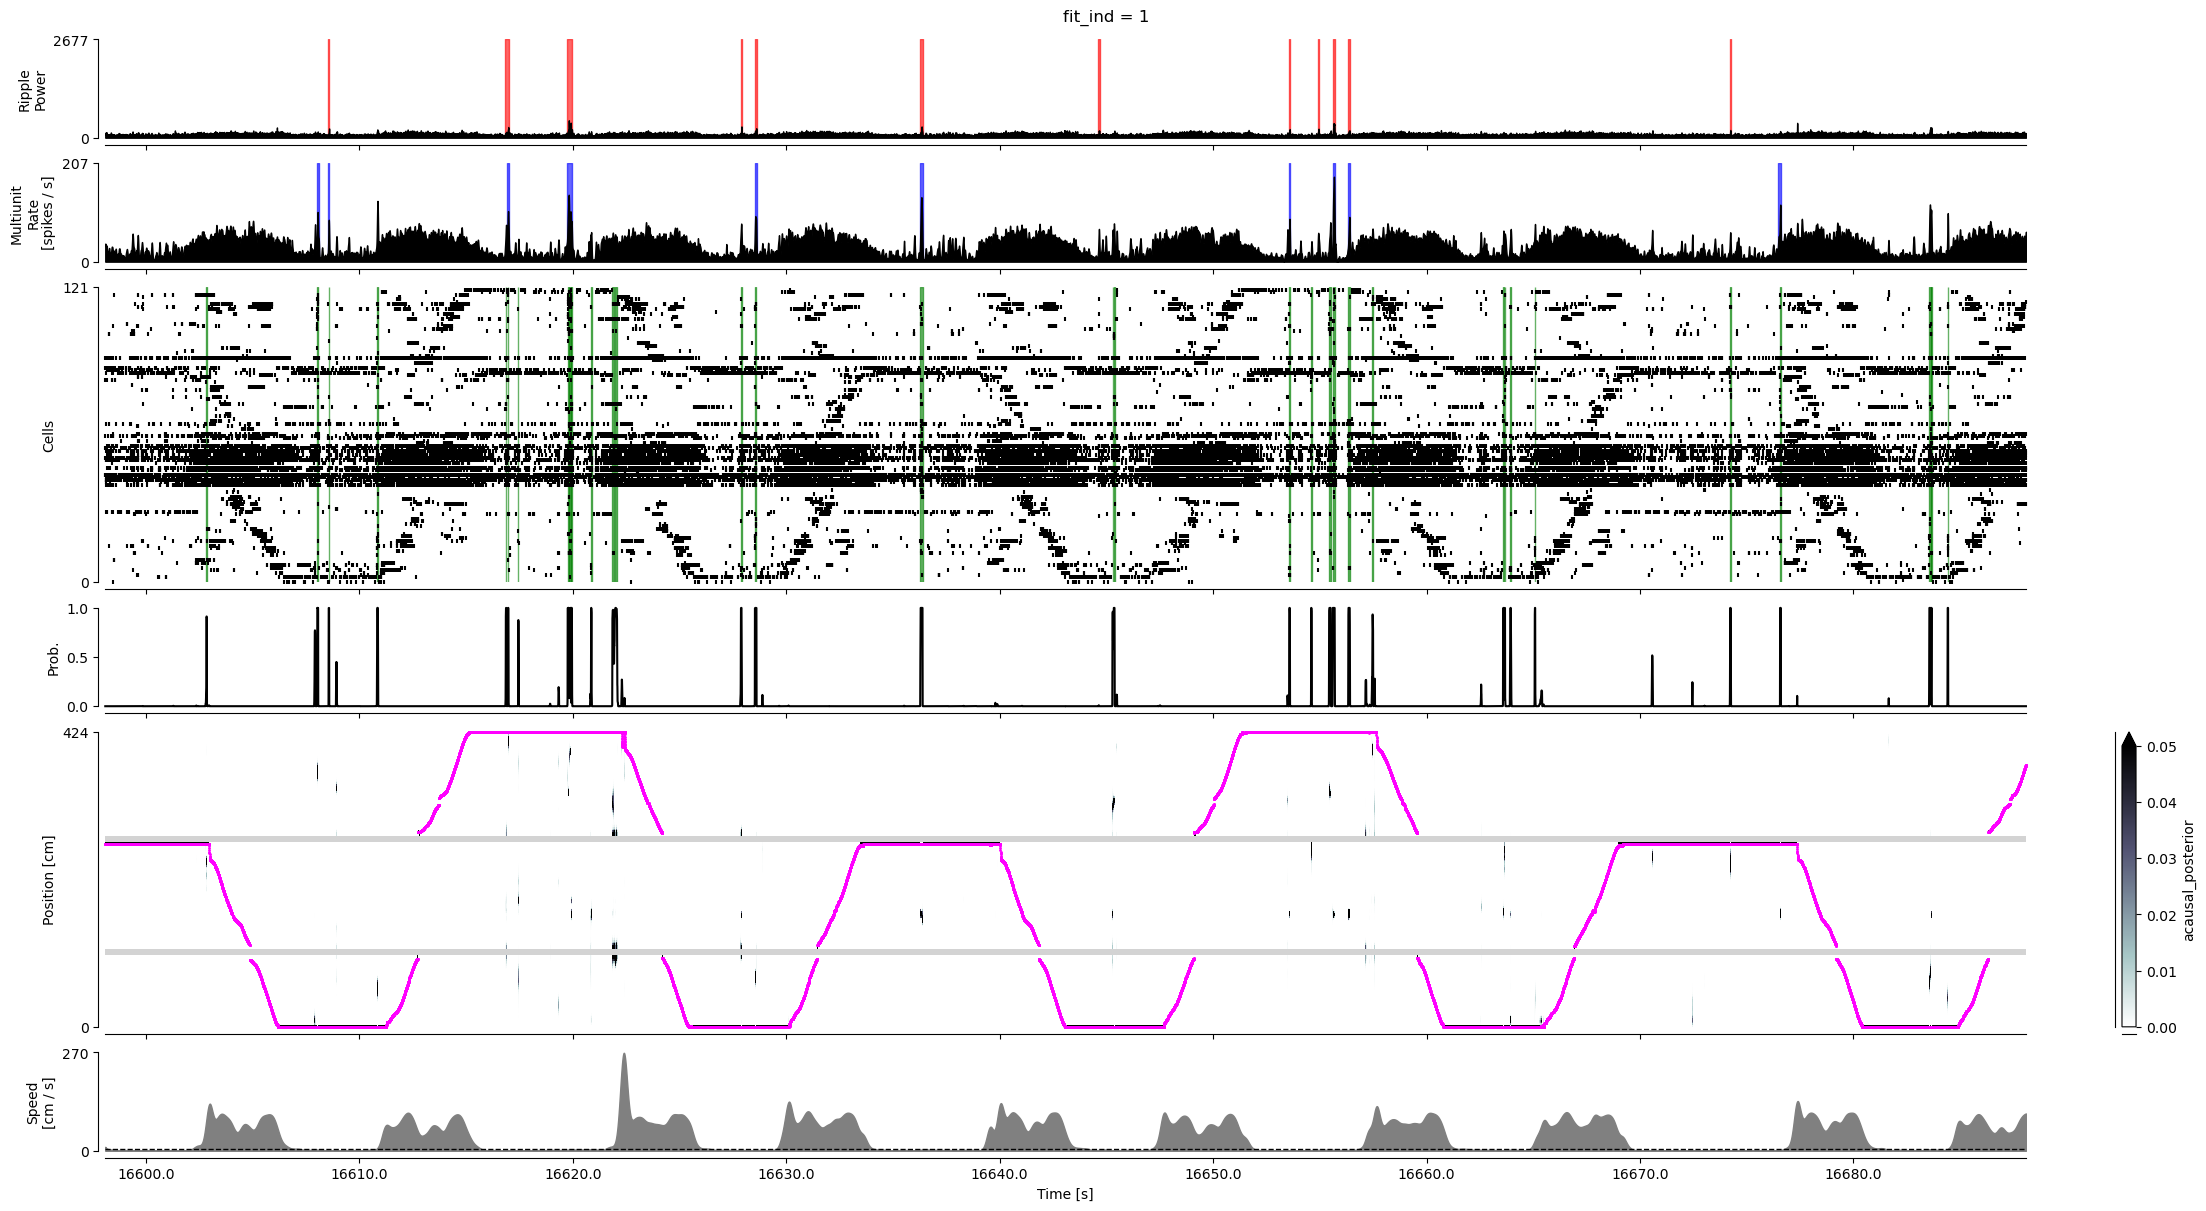

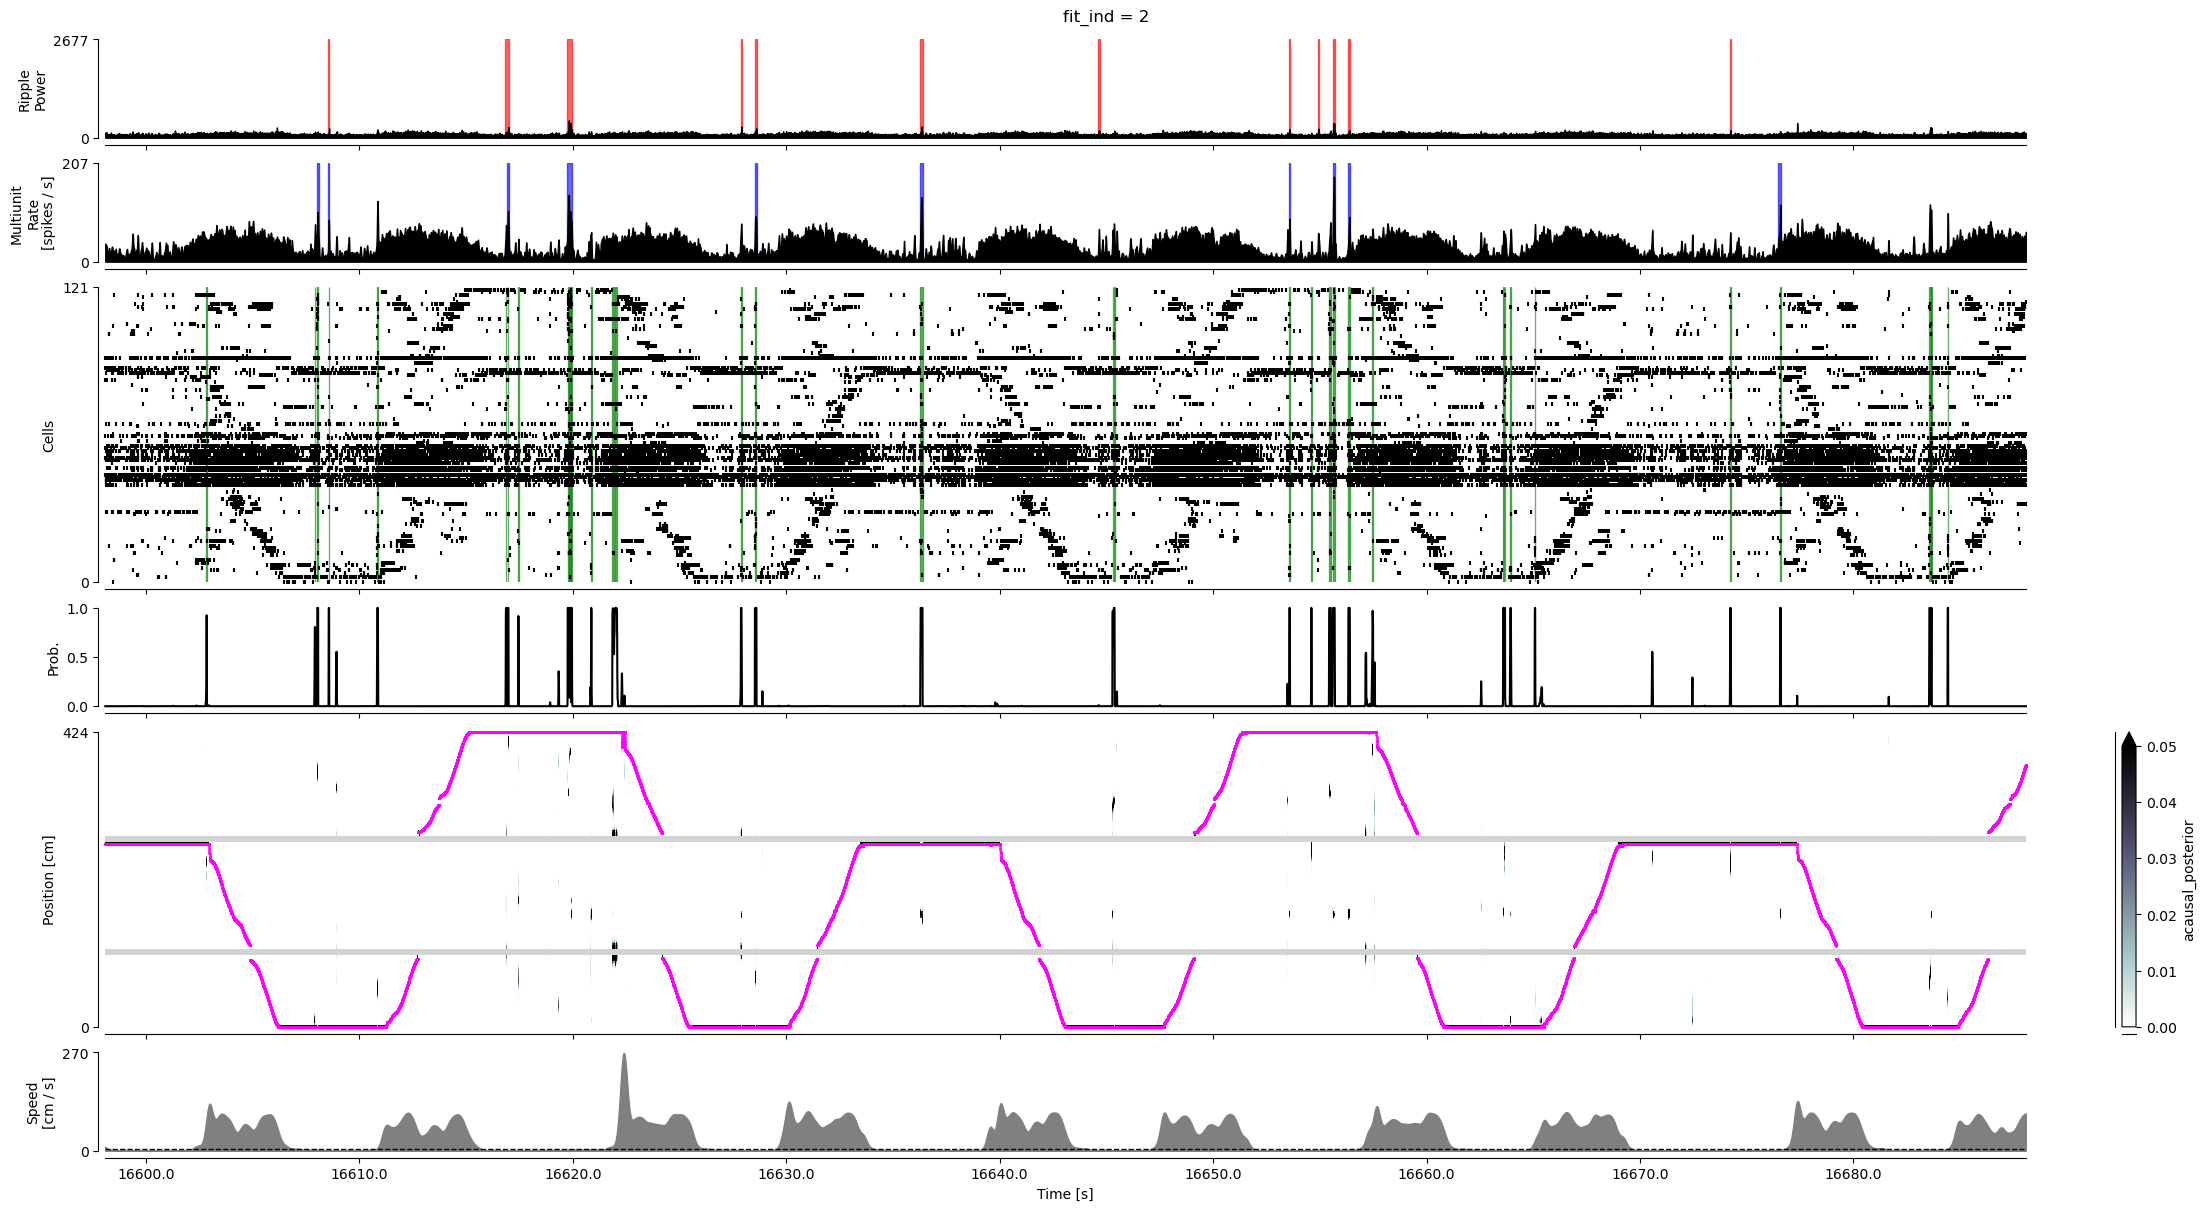

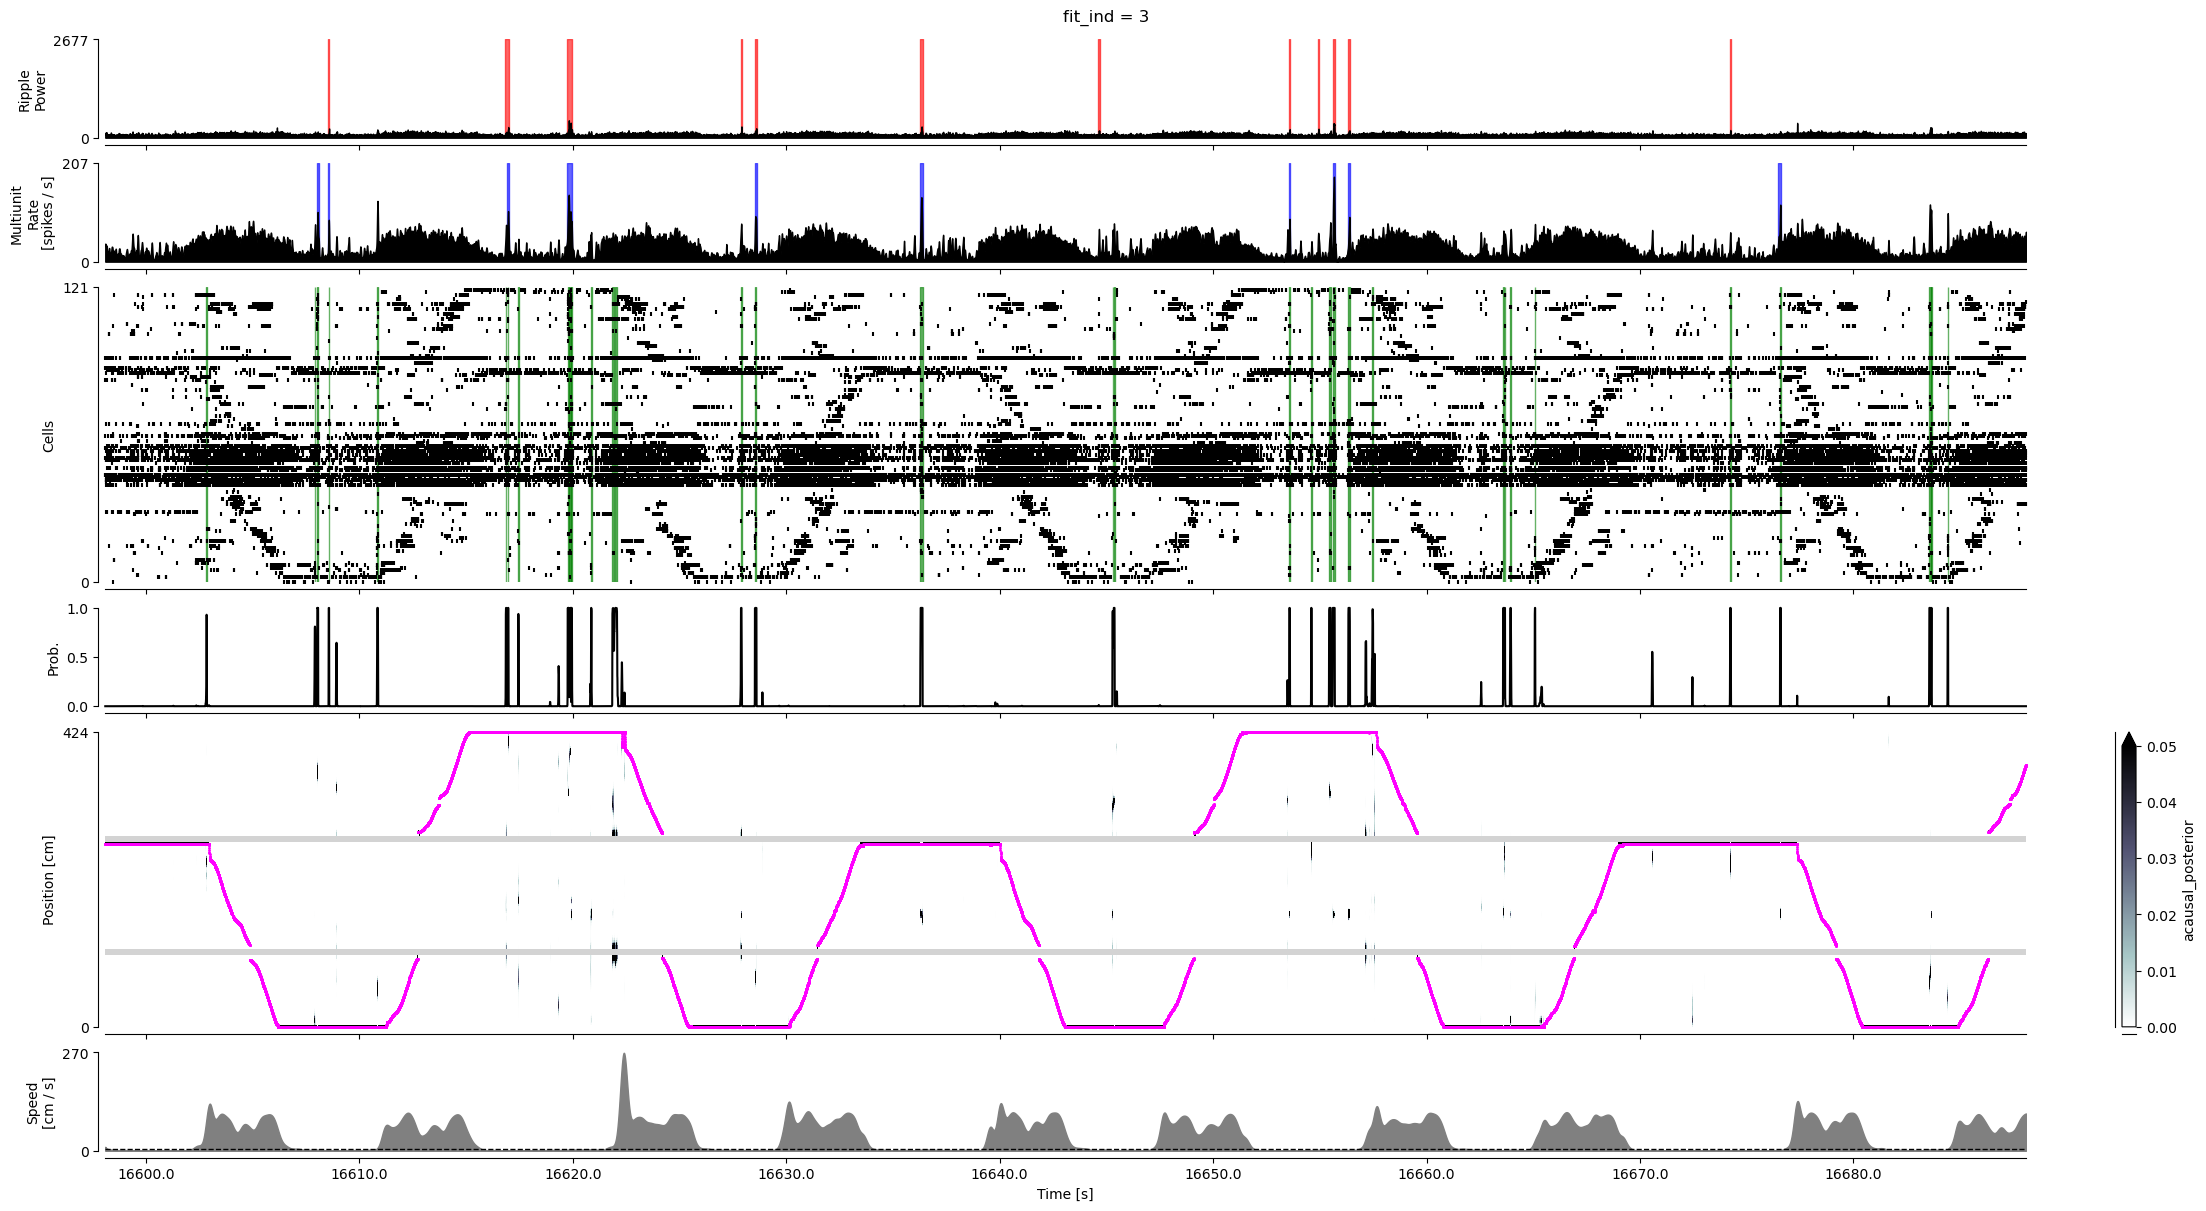

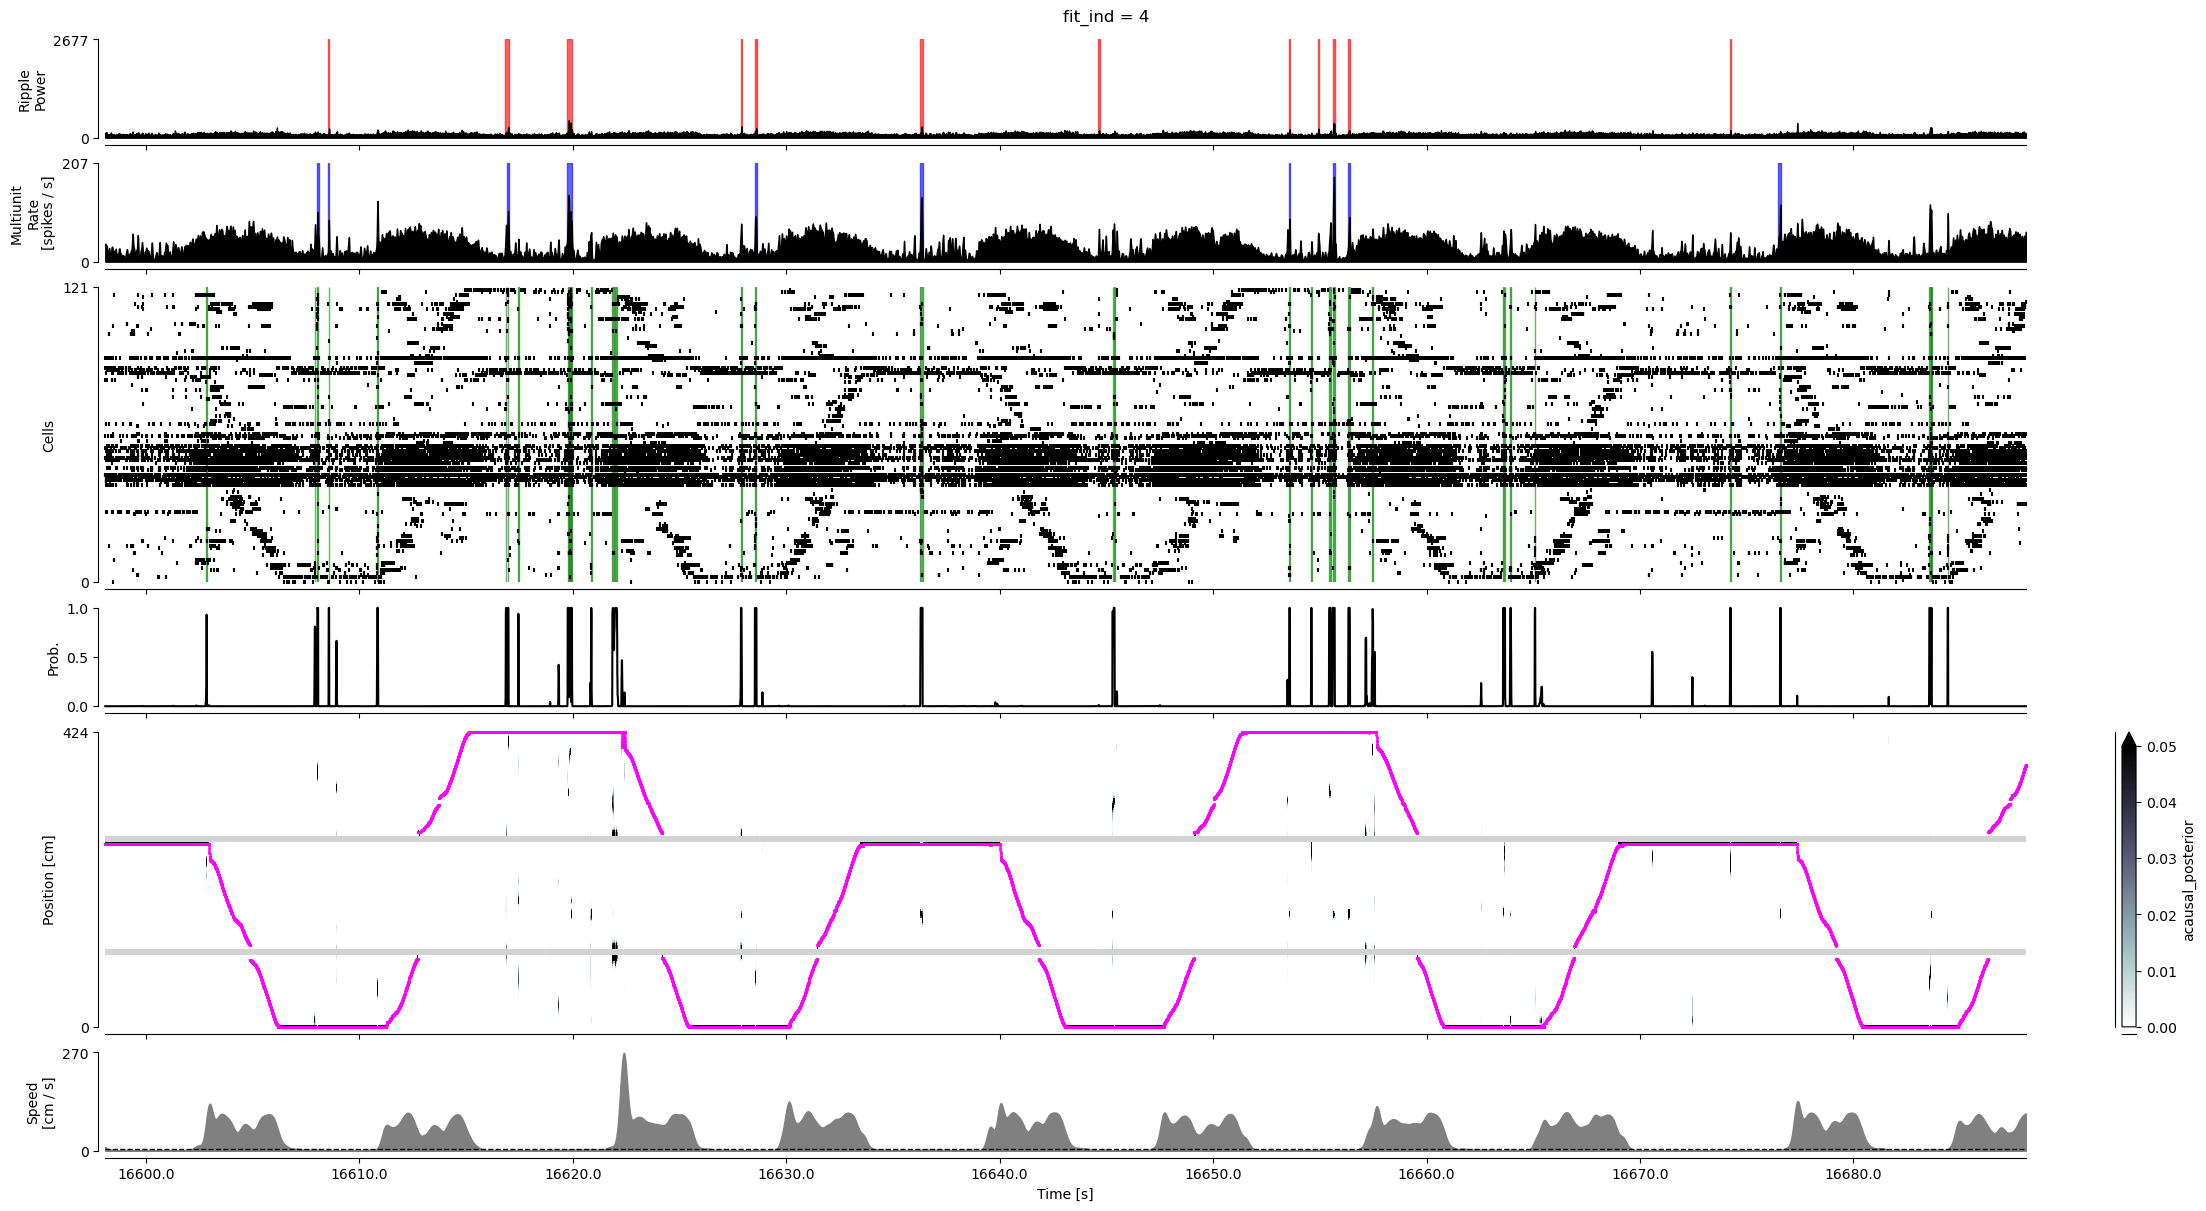

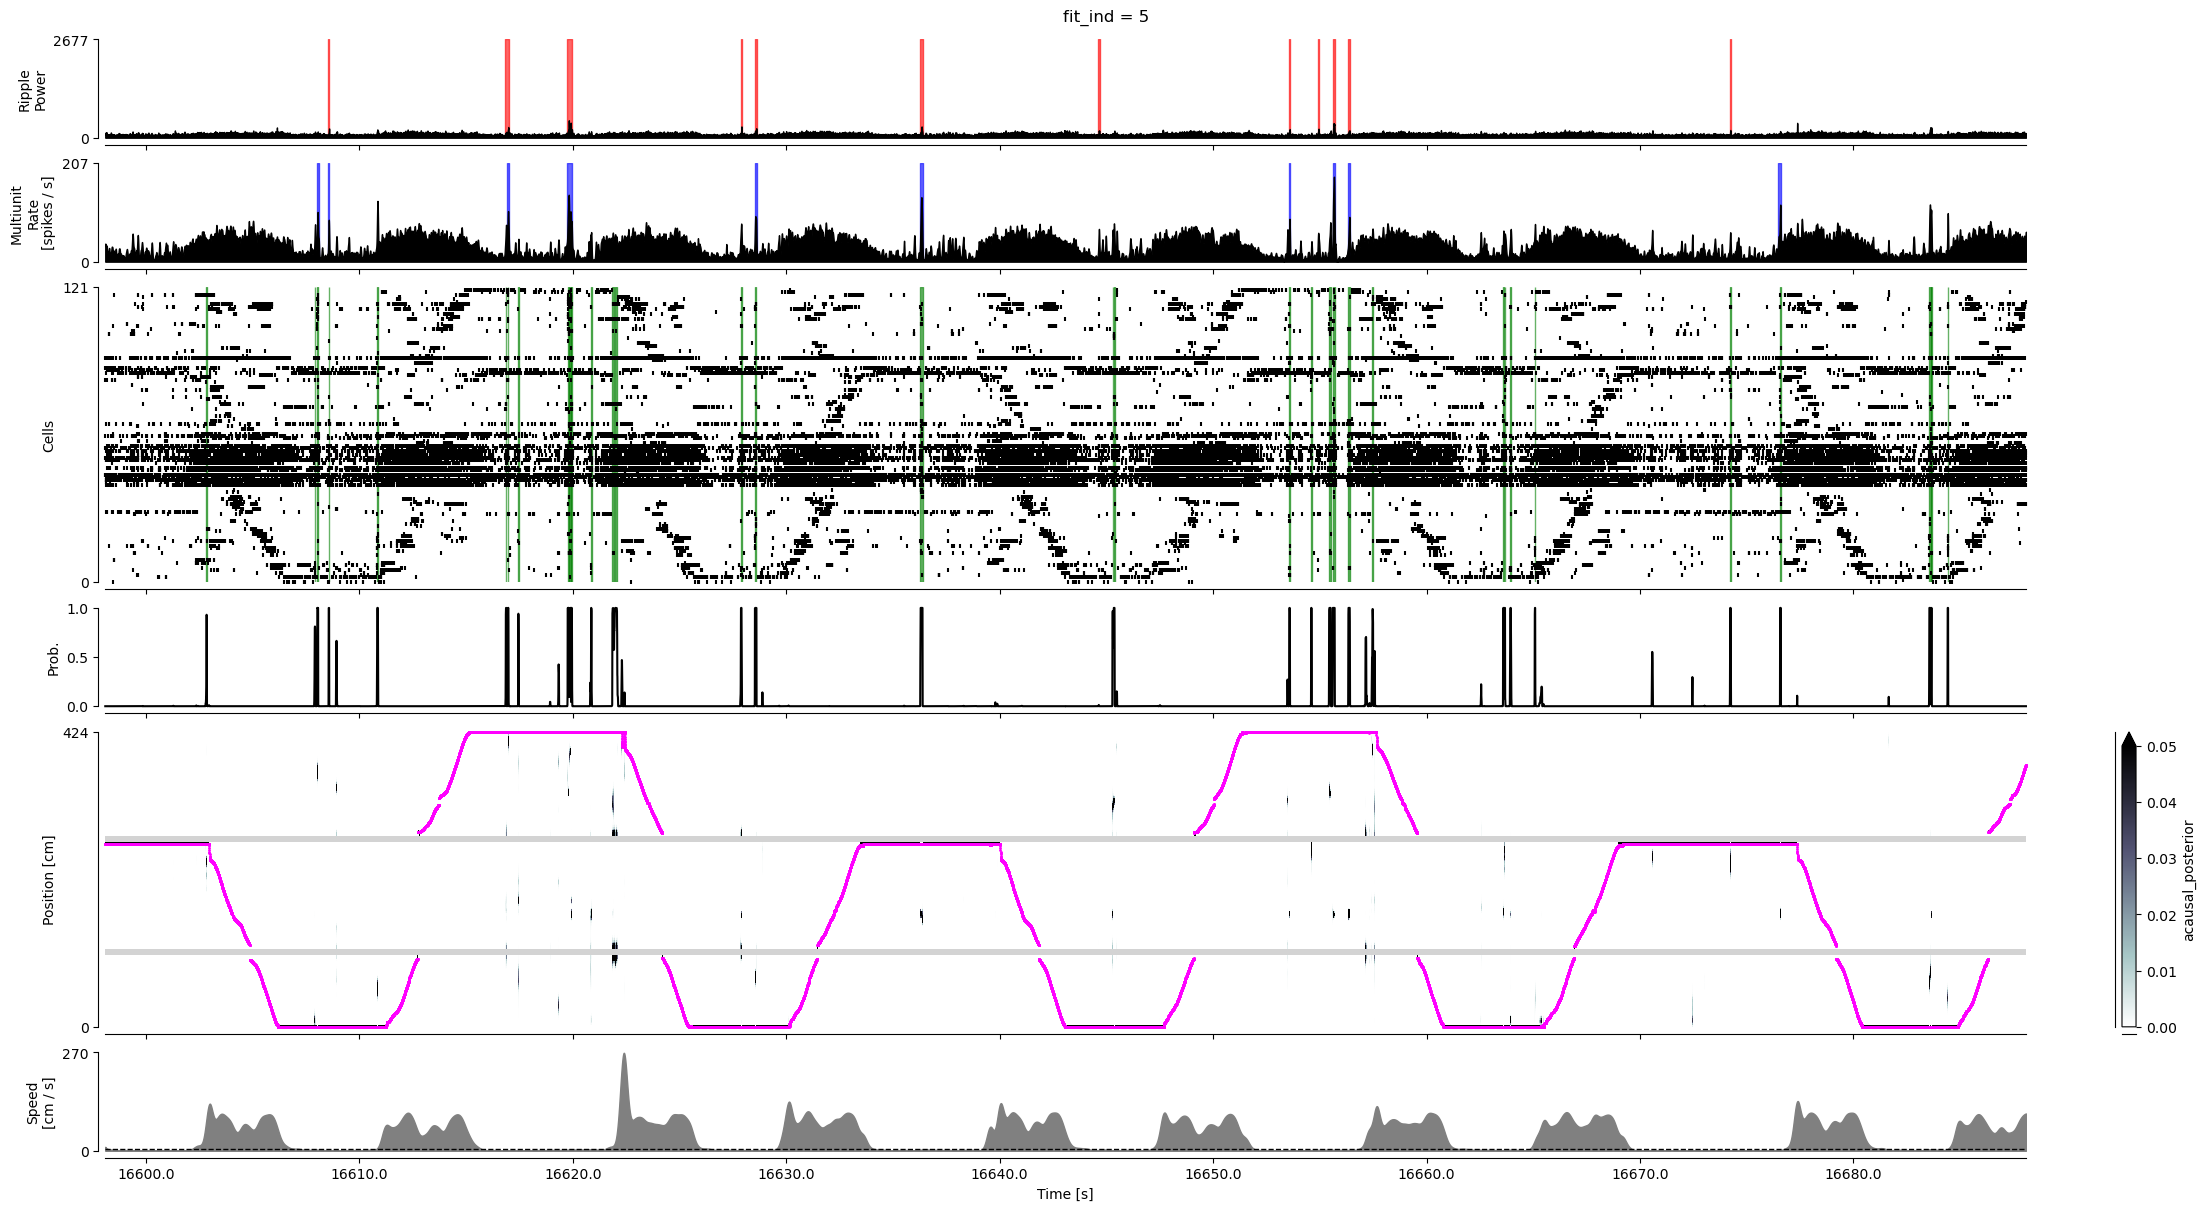

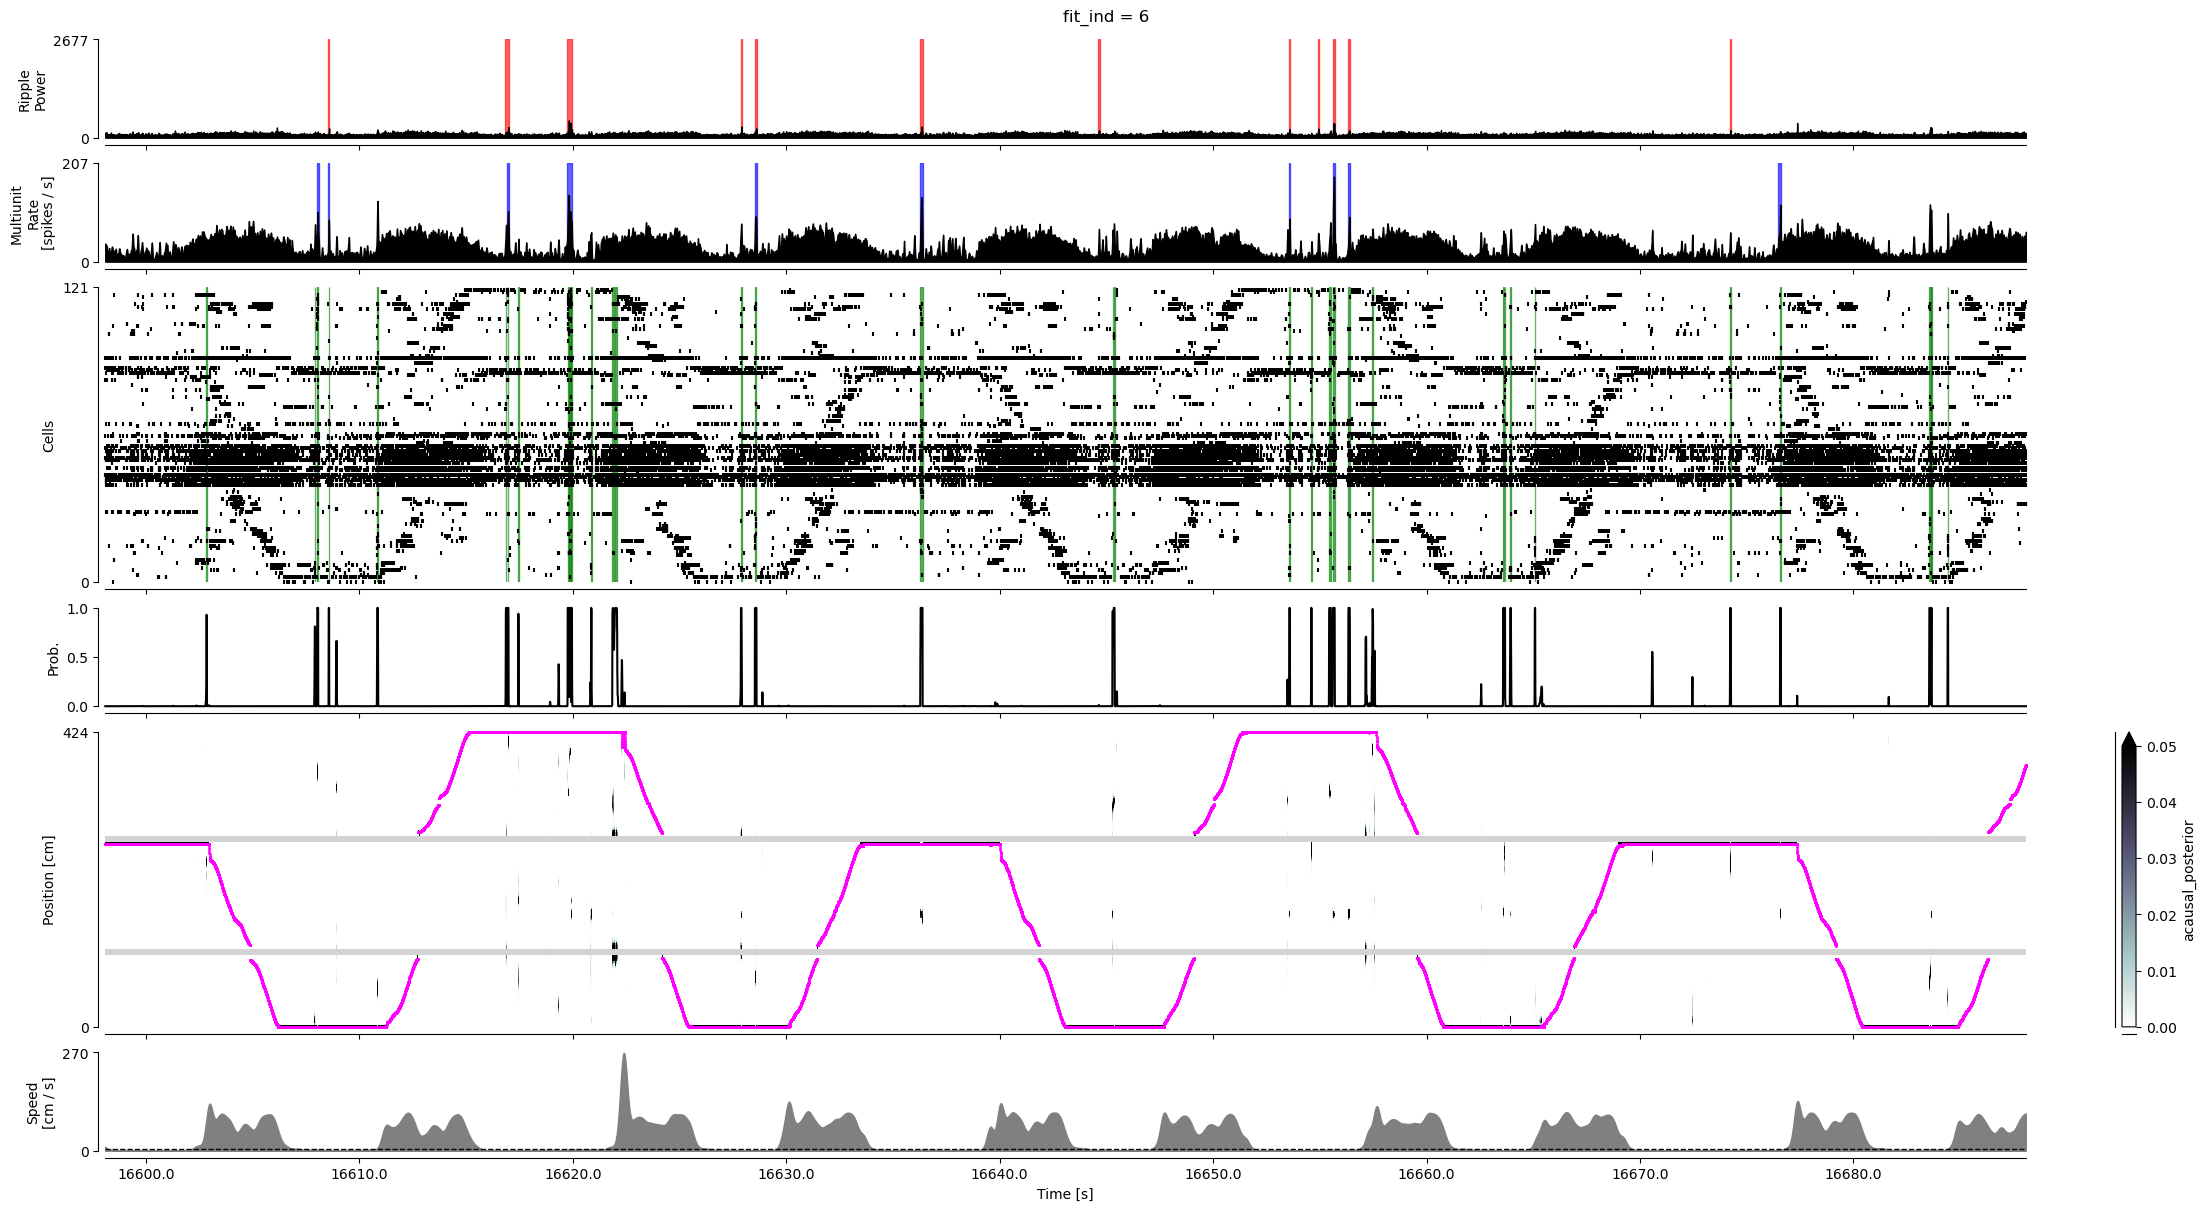

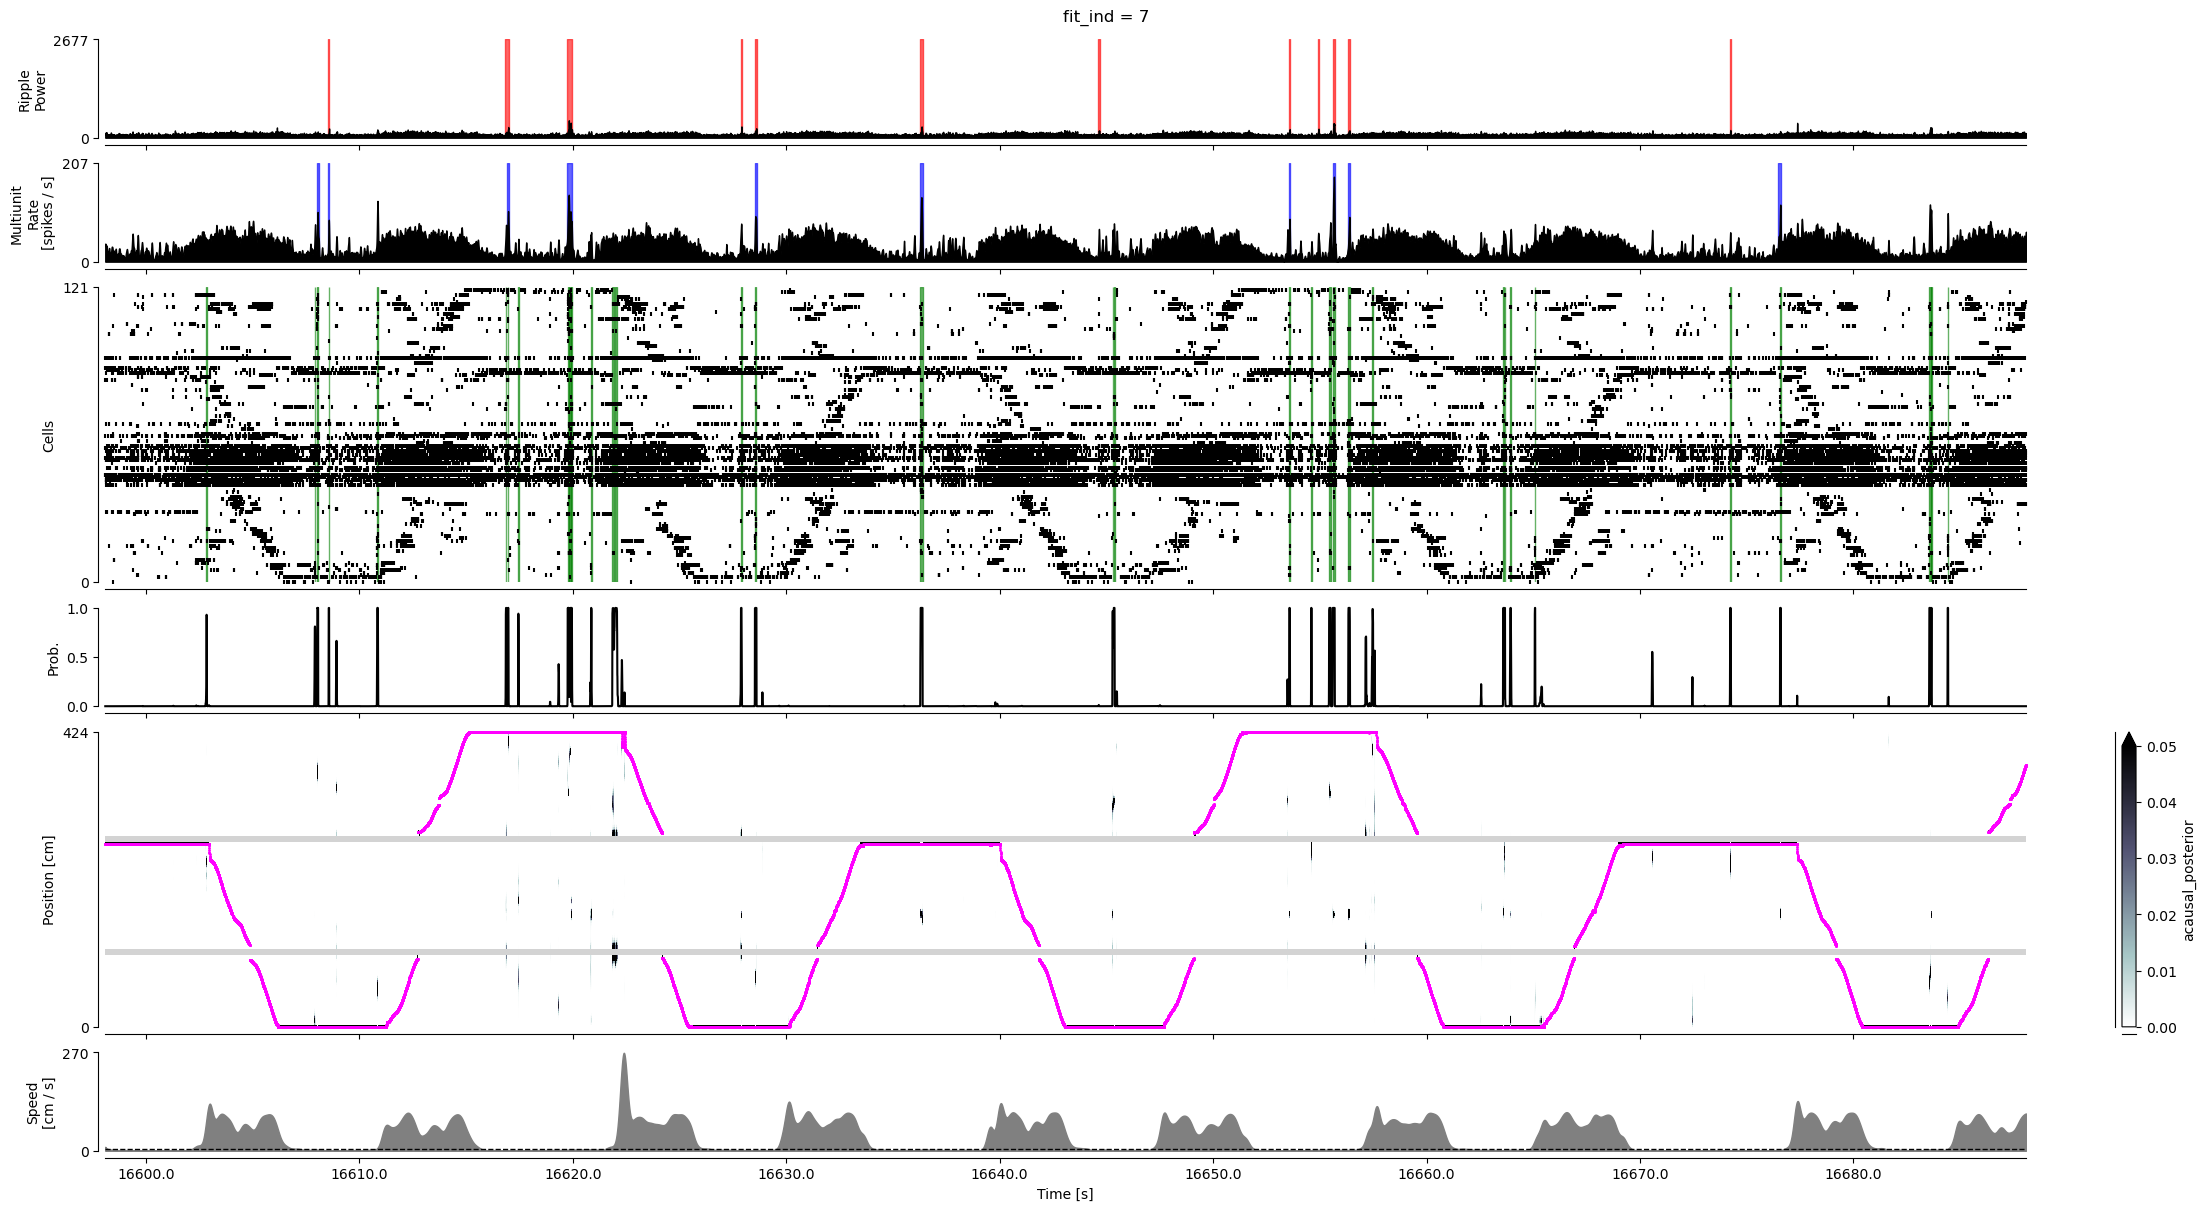

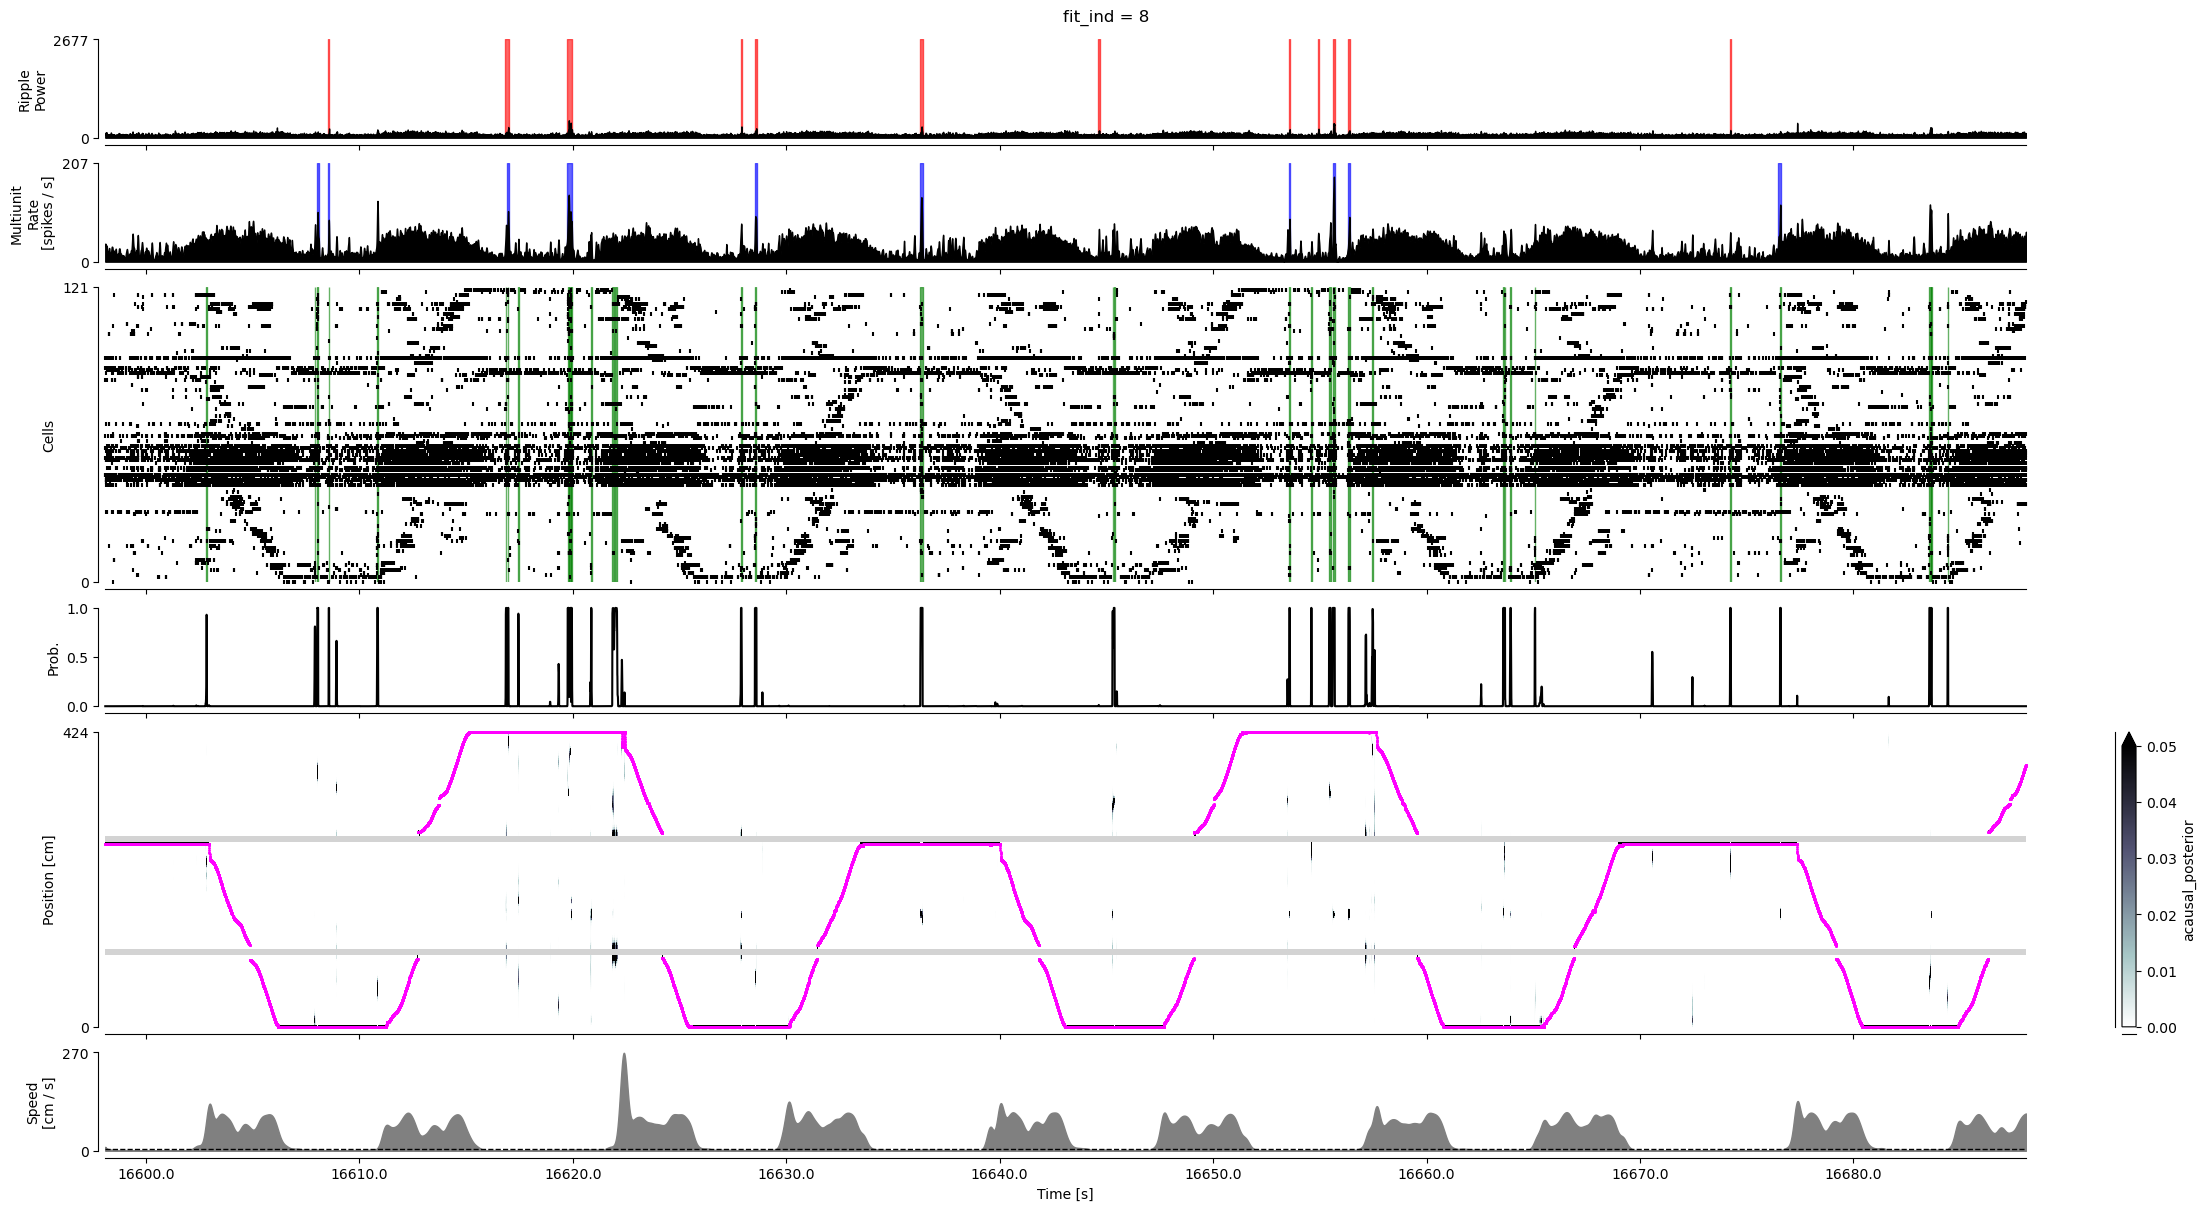

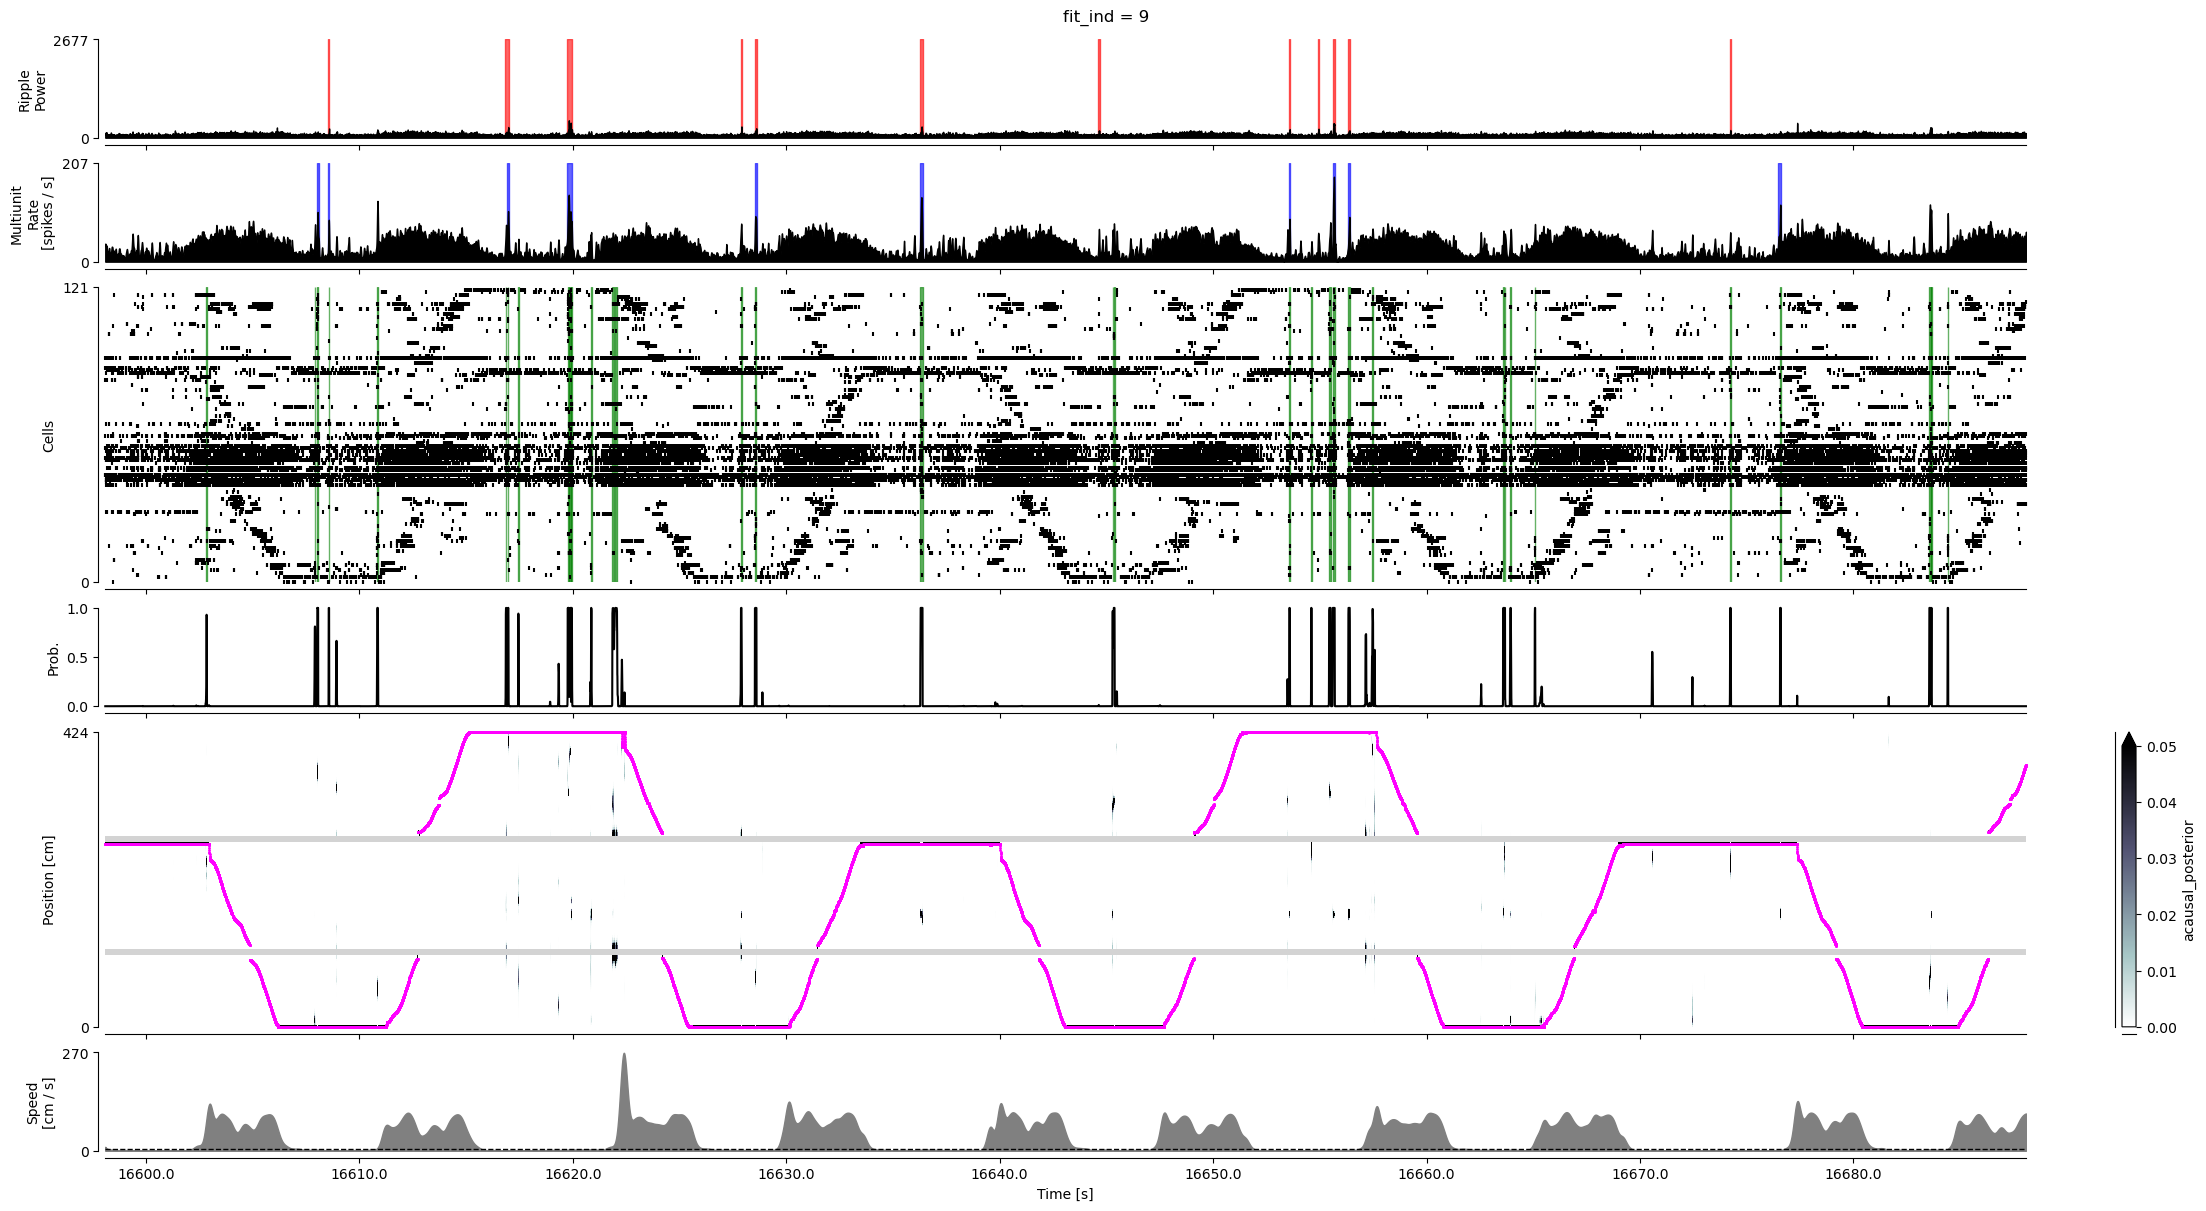

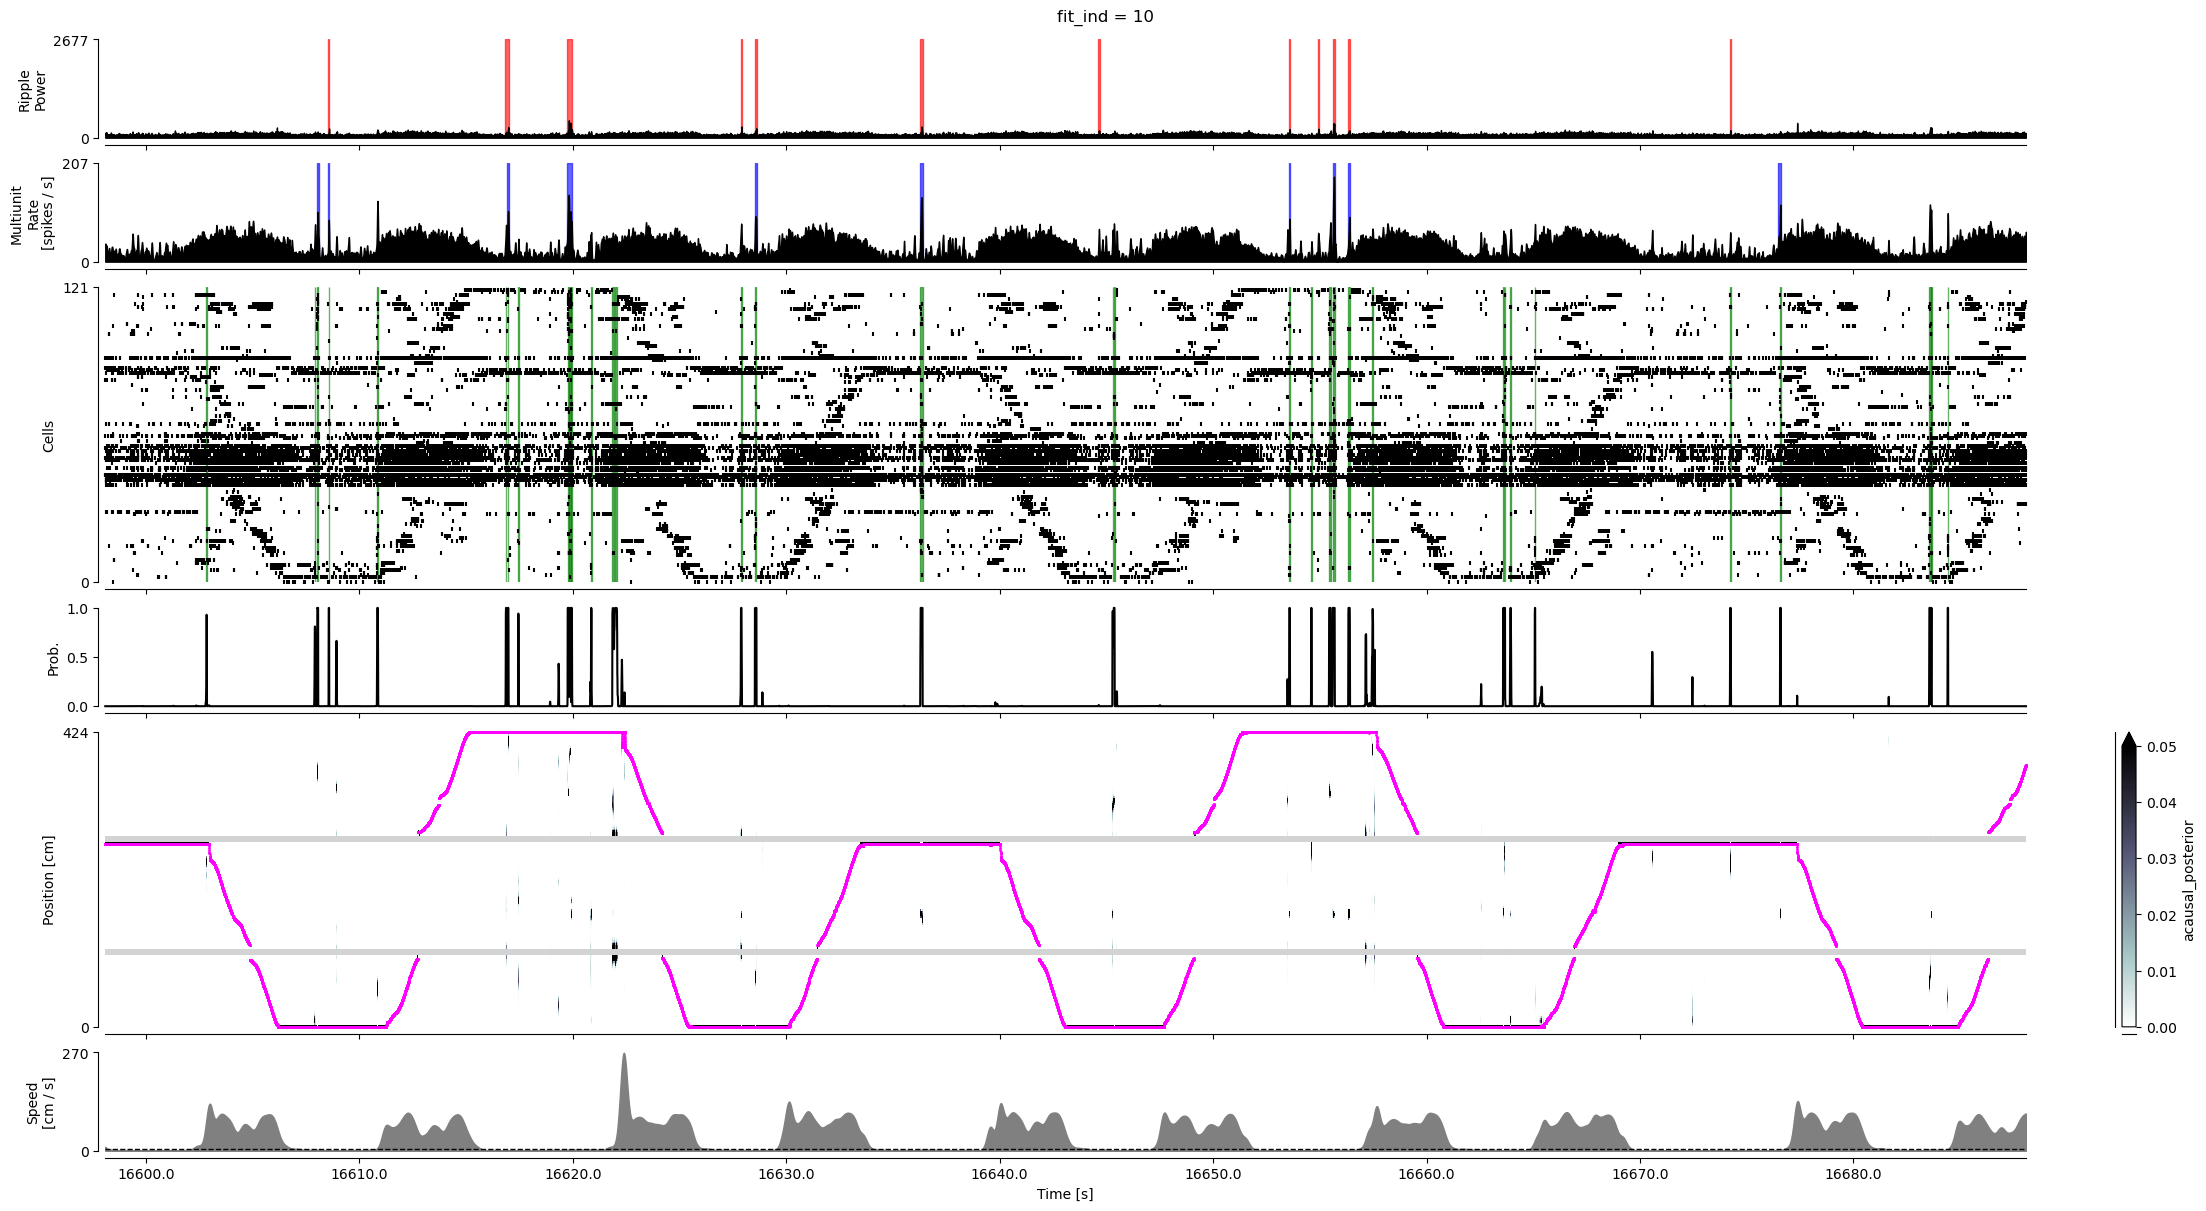

In [192]:
time_slice = slice(115_000, 160_000)
for fit_ind, (detector, result) in enumerate(zip(detectors, results)):
    plot_detector(time_slice, data, detector, result, figsize=(22, 12.0))
    plt.suptitle(f'fit_ind = {fit_ind}')
    plt.savefig(f'local_non_local_fit{fit_ind:02d}.png')

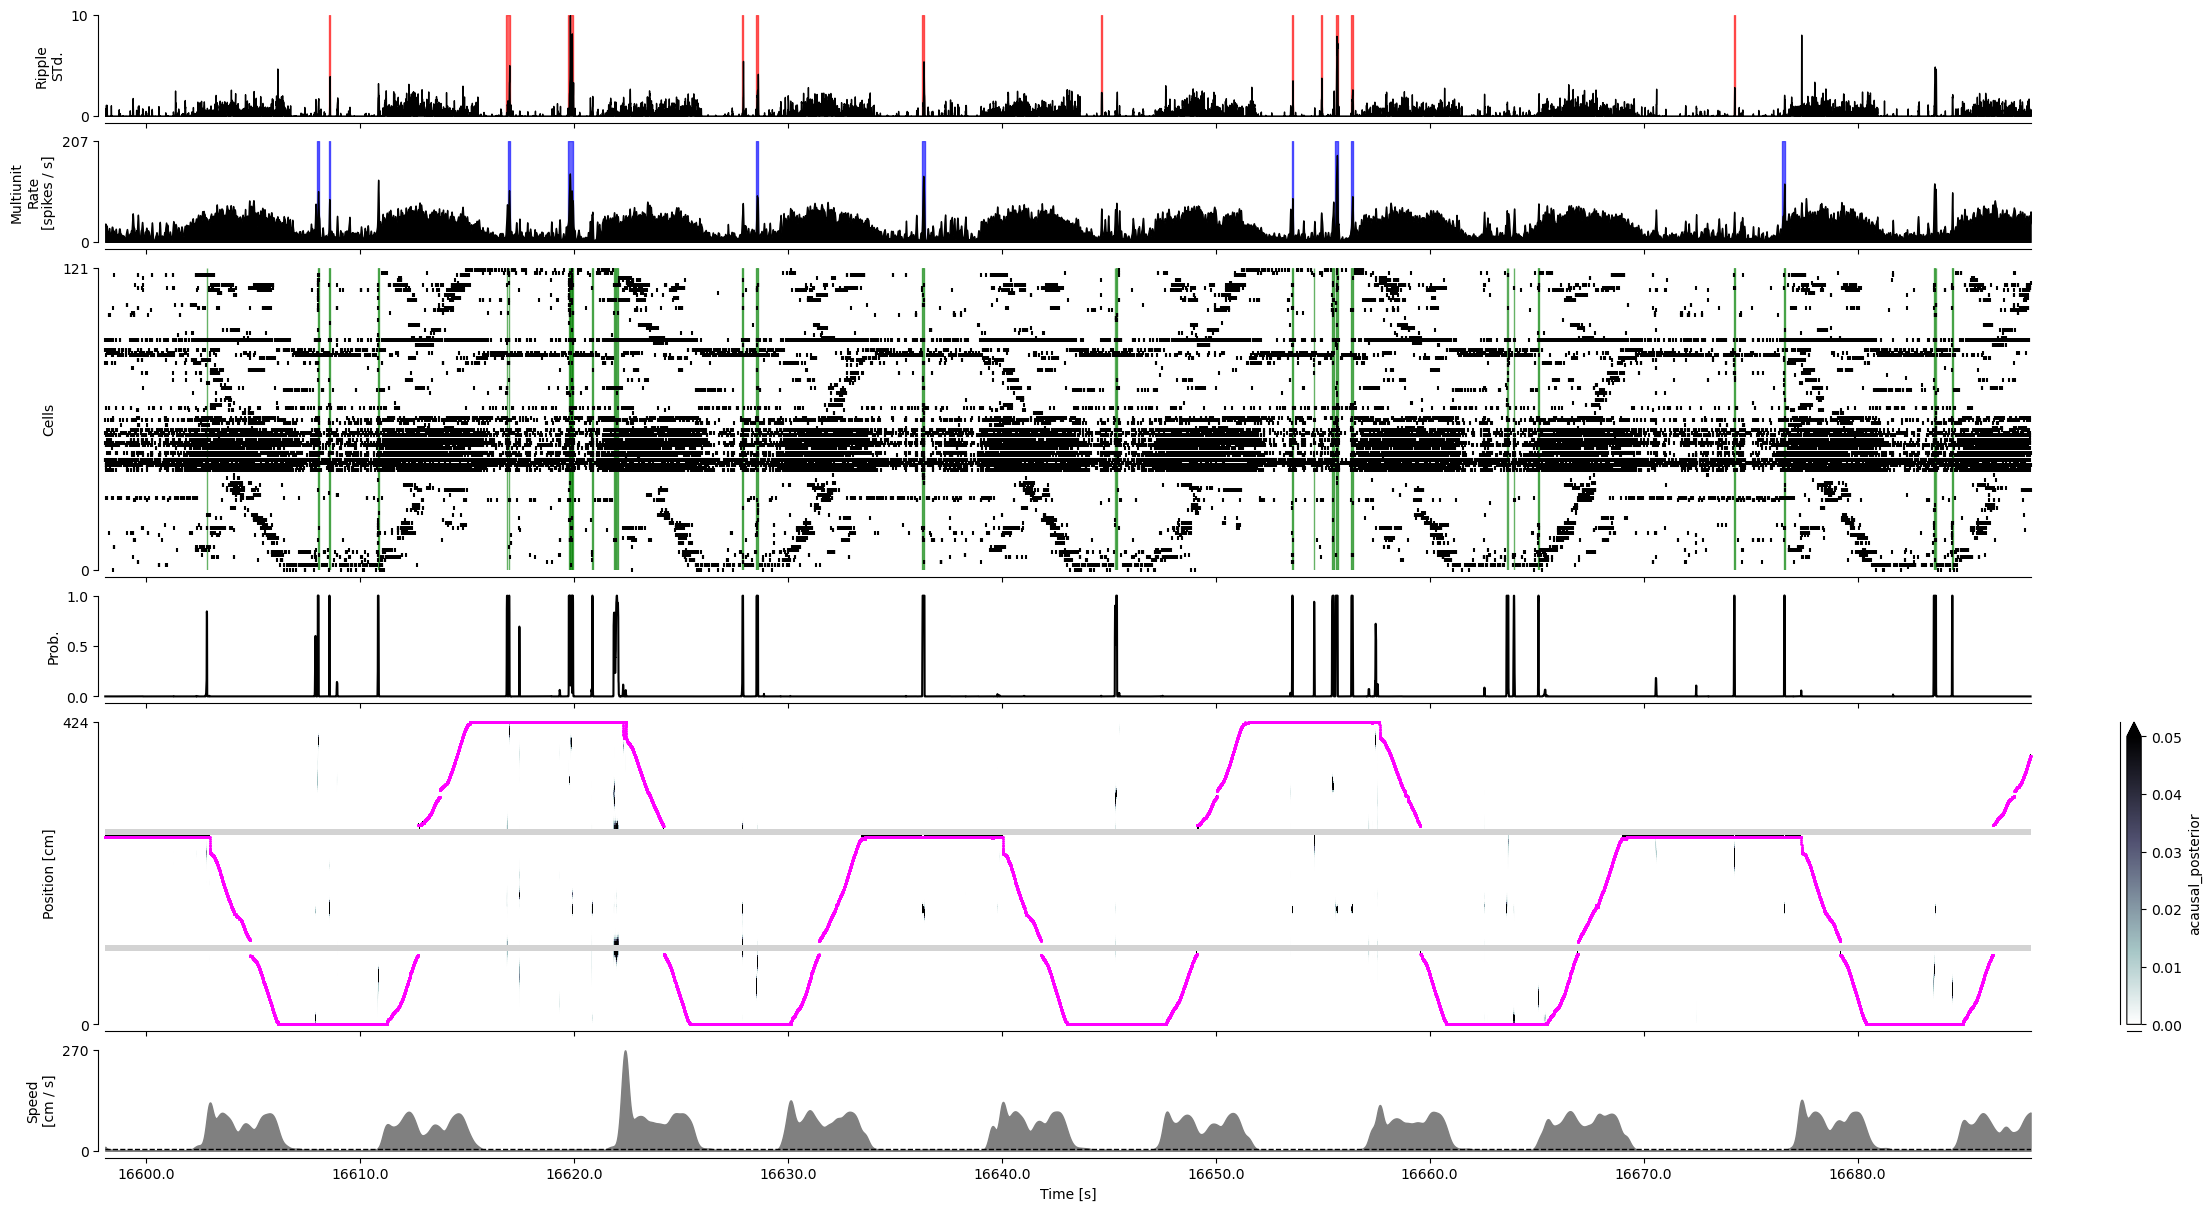

In [214]:
time_slice = slice(115_000, 160_000)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

In [194]:
data['multiunit_rate_zscore'], data['ripple_consensus_trace_zscore']

dict_keys(['position_info', 'tetrode_info', 'neuron_info', 'spikes', 'dio', 'dio_indicator', 'track_graph', 'edge_order', 'edge_spacing', 'ripple_times', 'ripple_labels', 'ripple_filtered_lfps', 'ripple_consensus_trace', 'ripple_lfps', 'ripple_consensus_trace_zscore', 'instantaneous_ripple_power_change', 'is_ripple', 'multiunits', 'multiunit_spikes', 'multiunit_firing_rate', 'multiunit_high_synchrony_times', 'multiunit_high_synchrony_labels', 'multiunit_rate_change', 'multiunit_rate_zscore', 'is_multiunit_high_synchrony'])

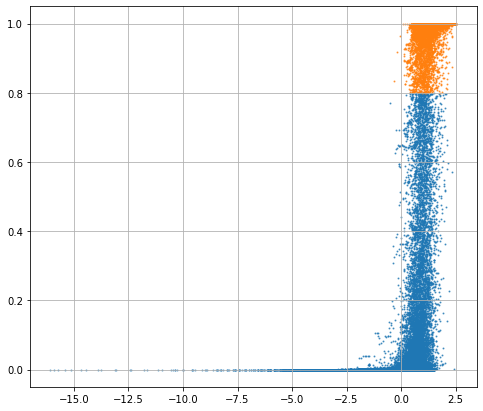

In [225]:
plt.figure(figsize=(8, 7))
plt.scatter(data['multiunit_rate_zscore'].values[results[0].non_local_probability.values < 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values < 0.8], s=1, alpha=0.7)
plt.scatter(data['multiunit_rate_zscore'].values[results[0].non_local_probability.values >= 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values >= 0.8], s=1, alpha=0.7)
plt.grid(True)

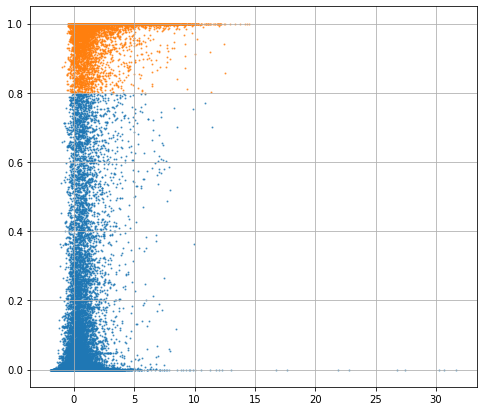

In [236]:
import pandas as pd
from scipy.stats import zscore

ripple_zscore = zscore(data['ripple_consensus_trace'], nan_policy='omit')
new_index = pd.Index(np.unique(np.concatenate(
    (data['position_info'].index, ripple_zscore.index))), name='time')
ripple_zscore = (ripple_zscore
               .reindex(index=new_index)
               .interpolate(method='linear')
               .reindex(index=data['position_info'].index))
plt.figure(figsize=(8, 7))
plt.scatter(ripple_zscore.values[results[0].non_local_probability.values < 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values < 0.8], s=1, alpha=0.7)
plt.scatter(ripple_zscore.values[results[0].non_local_probability.values >= 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values >= 0.8], s=1, alpha=0.7)
plt.grid(True)

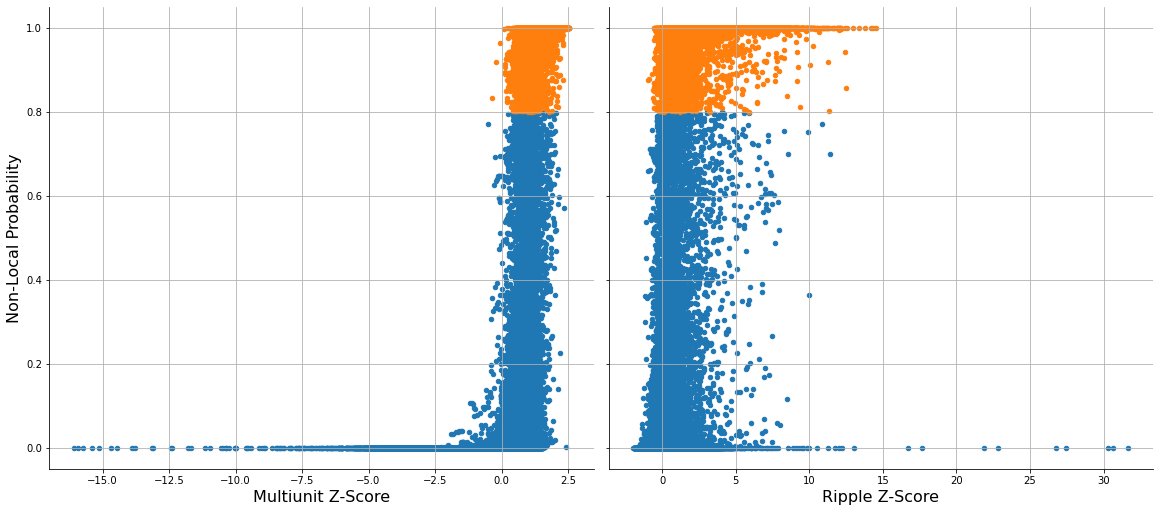

In [269]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True, constrained_layout=True)
axes[0].scatter(data['multiunit_rate_zscore'].values[results[0].non_local_probability.values < 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values < 0.8], s=20)
axes[0].scatter(data['multiunit_rate_zscore'].values[results[0].non_local_probability.values >= 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values >= 0.8], s=20)
axes[0].grid(True)
axes[0].set_xlabel('Multiunit Z-Score', fontsize=16)
axes[0].set_ylabel('Non-Local Probability', fontsize=16)

axes[1].scatter(ripple_zscore.values[results[0].non_local_probability.values < 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values < 0.8], s=20)
axes[1].scatter(ripple_zscore.values[results[0].non_local_probability.values >= 0.8],
            results[0].non_local_probability.values[results[0].non_local_probability.values >= 0.8], s=20)
axes[1].grid(True)
axes[1].set_xlabel('Ripple Z-Score', fontsize=16)
sns.despine()

In [254]:
low_ripple_high_non_local = ((ripple_zscore.values.squeeze() < 0) &
                             (results[0].non_local_probability.values.squeeze() > 0.8))

np.nonzero(low_ripple_high_non_local)[0]

array([   413,    414,   8777,   8778,   8779,   9260,  10061,  10062,
        10063,  10064,  10065,  10066,  10067,  10068,  10069,  10070,
        10071,  10072,  10073,  10074,  10075,  10076,  14009,  14010,
        14011,  14916,  14917,  14918,  14919,  14920,  15832,  15833,
        15834,  15835,  16588,  16589,  16590,  16591,  16592,  16593,
        16604,  16605,  16606,  16623,  16624,  16625,  16632,  16633,
        16634,  16635,  16636,  16637,  16656,  16657,  16658,  16659,
        16660,  16661,  17392,  17449,  17461,  17462,  17463,  17464,
        22517,  22518,  22519,  22520,  23421,  23422,  24358,  24359,
        24360,  24537,  24538,  24539,  24540,  24557,  24568,  24569,
        24570,  24571,  24572,  24573,  24574,  24575,  26601,  26602,
        27985,  27986,  27987,  27988,  27989,  27990,  28053,  28054,
        28055,  28056,  28057,  32314,  34491,  34492,  34493,  34494,
        35662,  38834,  38835,  46361,  46362,  46363,  46383,  46384,
      

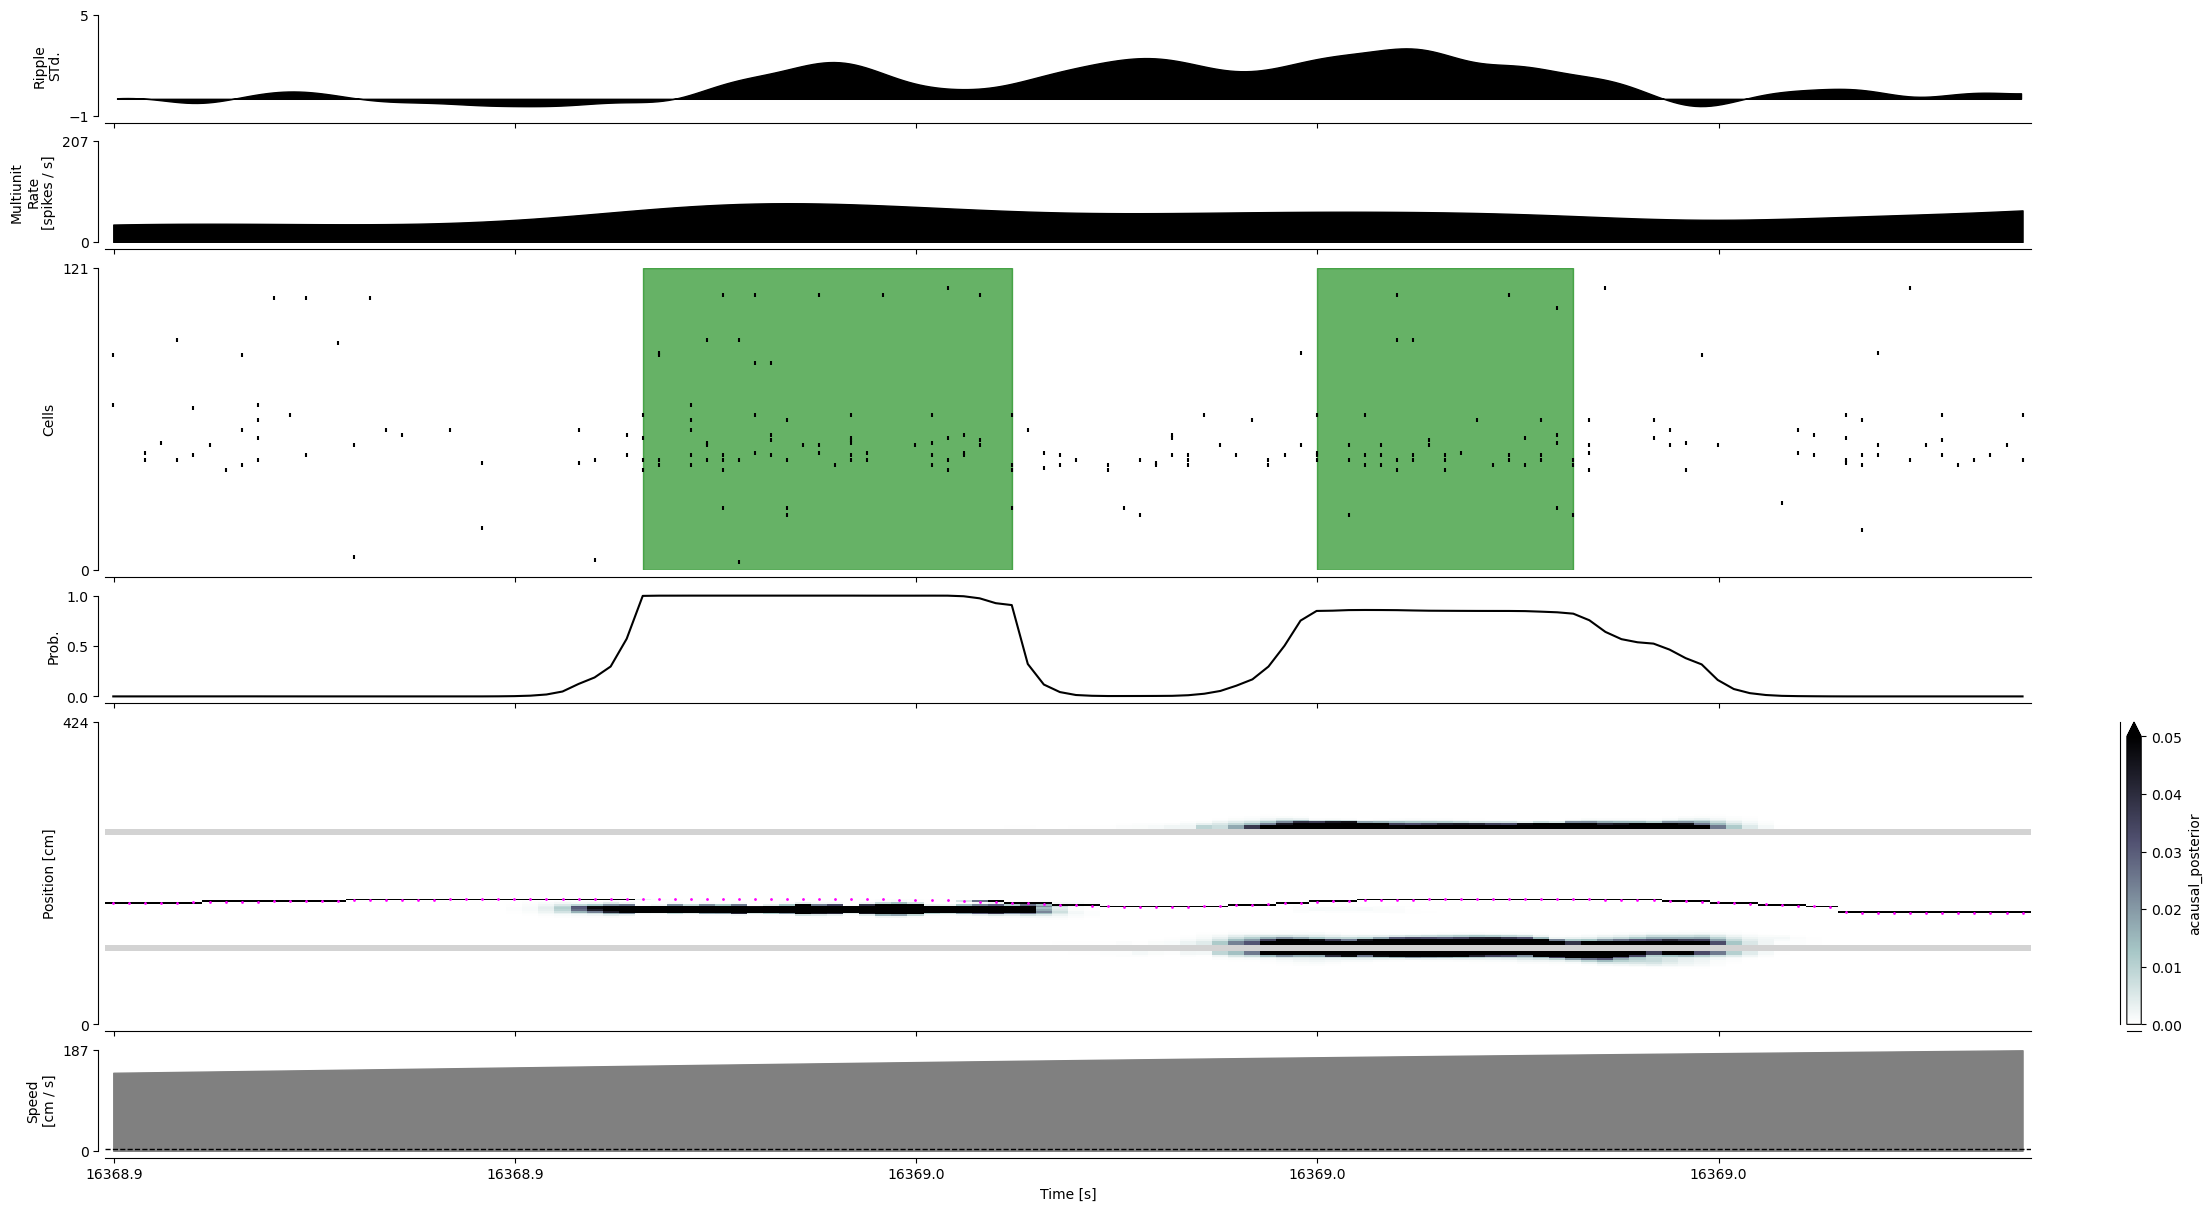

In [288]:
time_slice = slice(380, 500)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

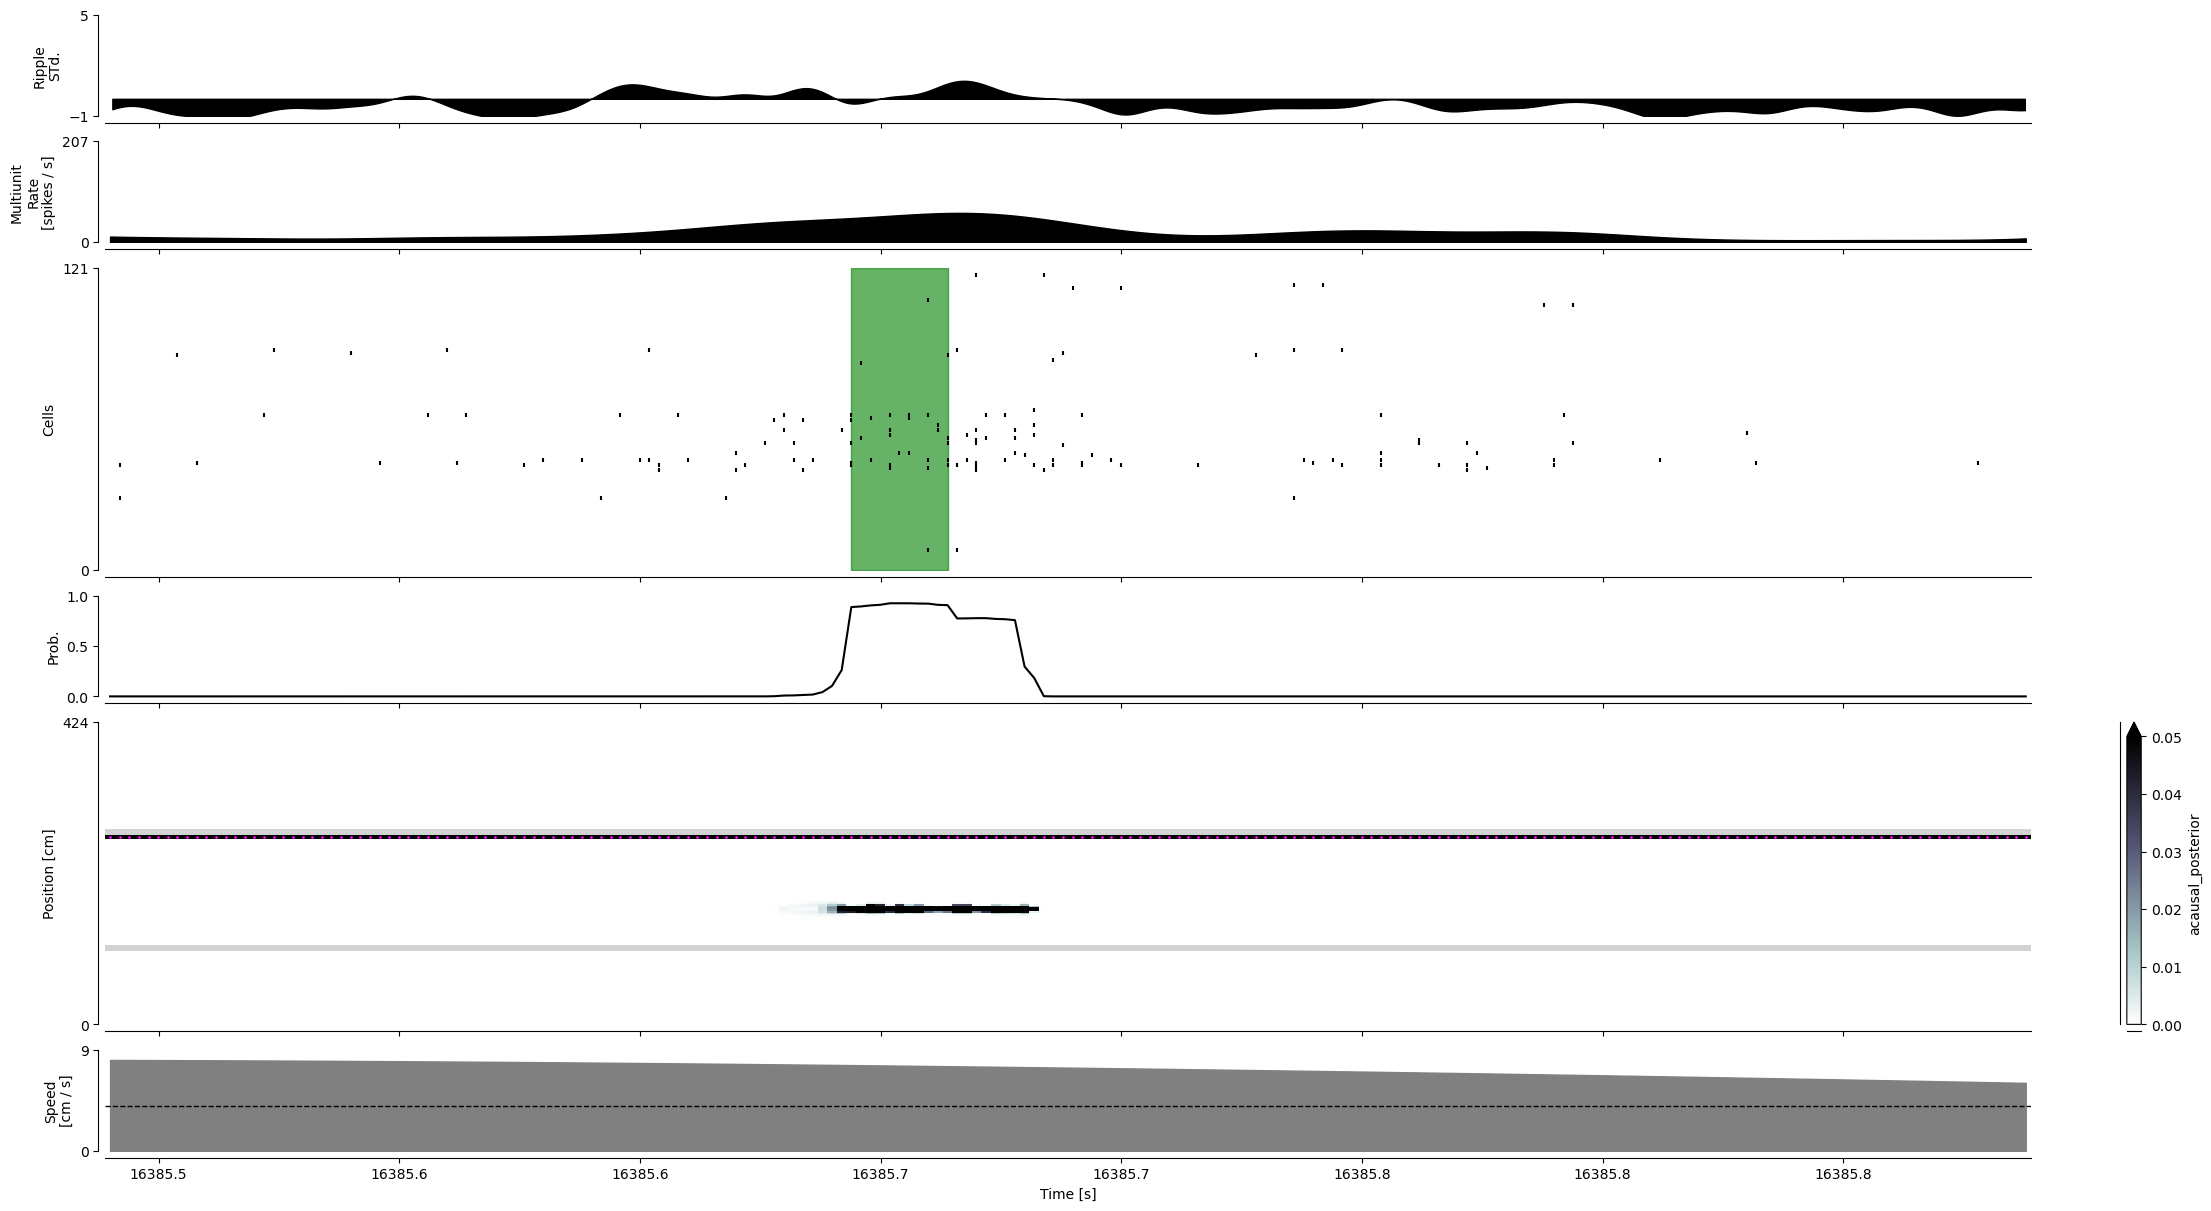

In [289]:
time_slice = slice(8700, 8900)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

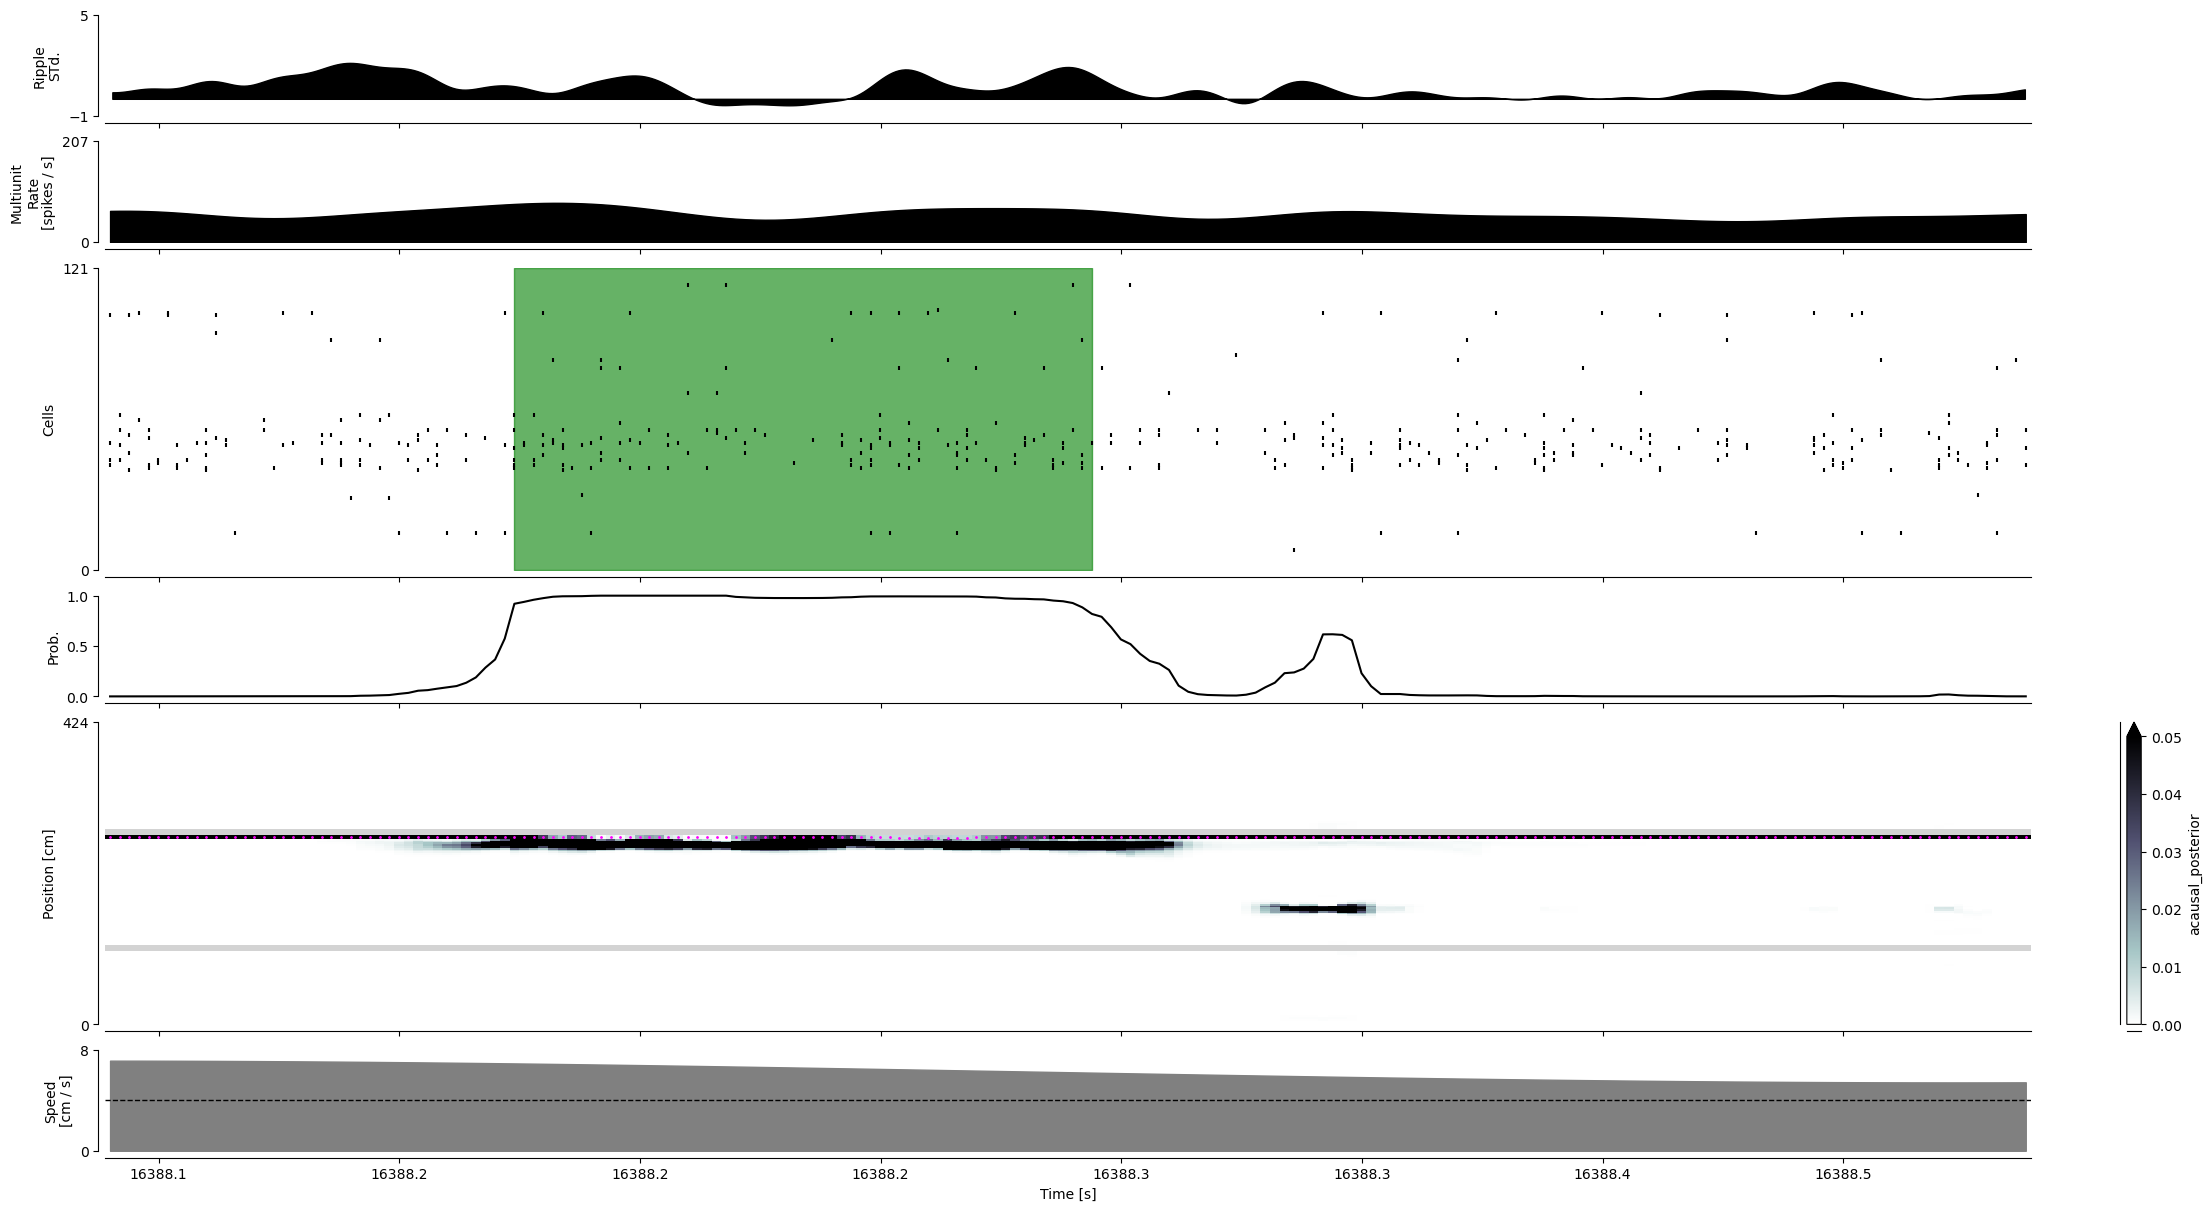

In [290]:
time_slice = slice(10_000, 10_200)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

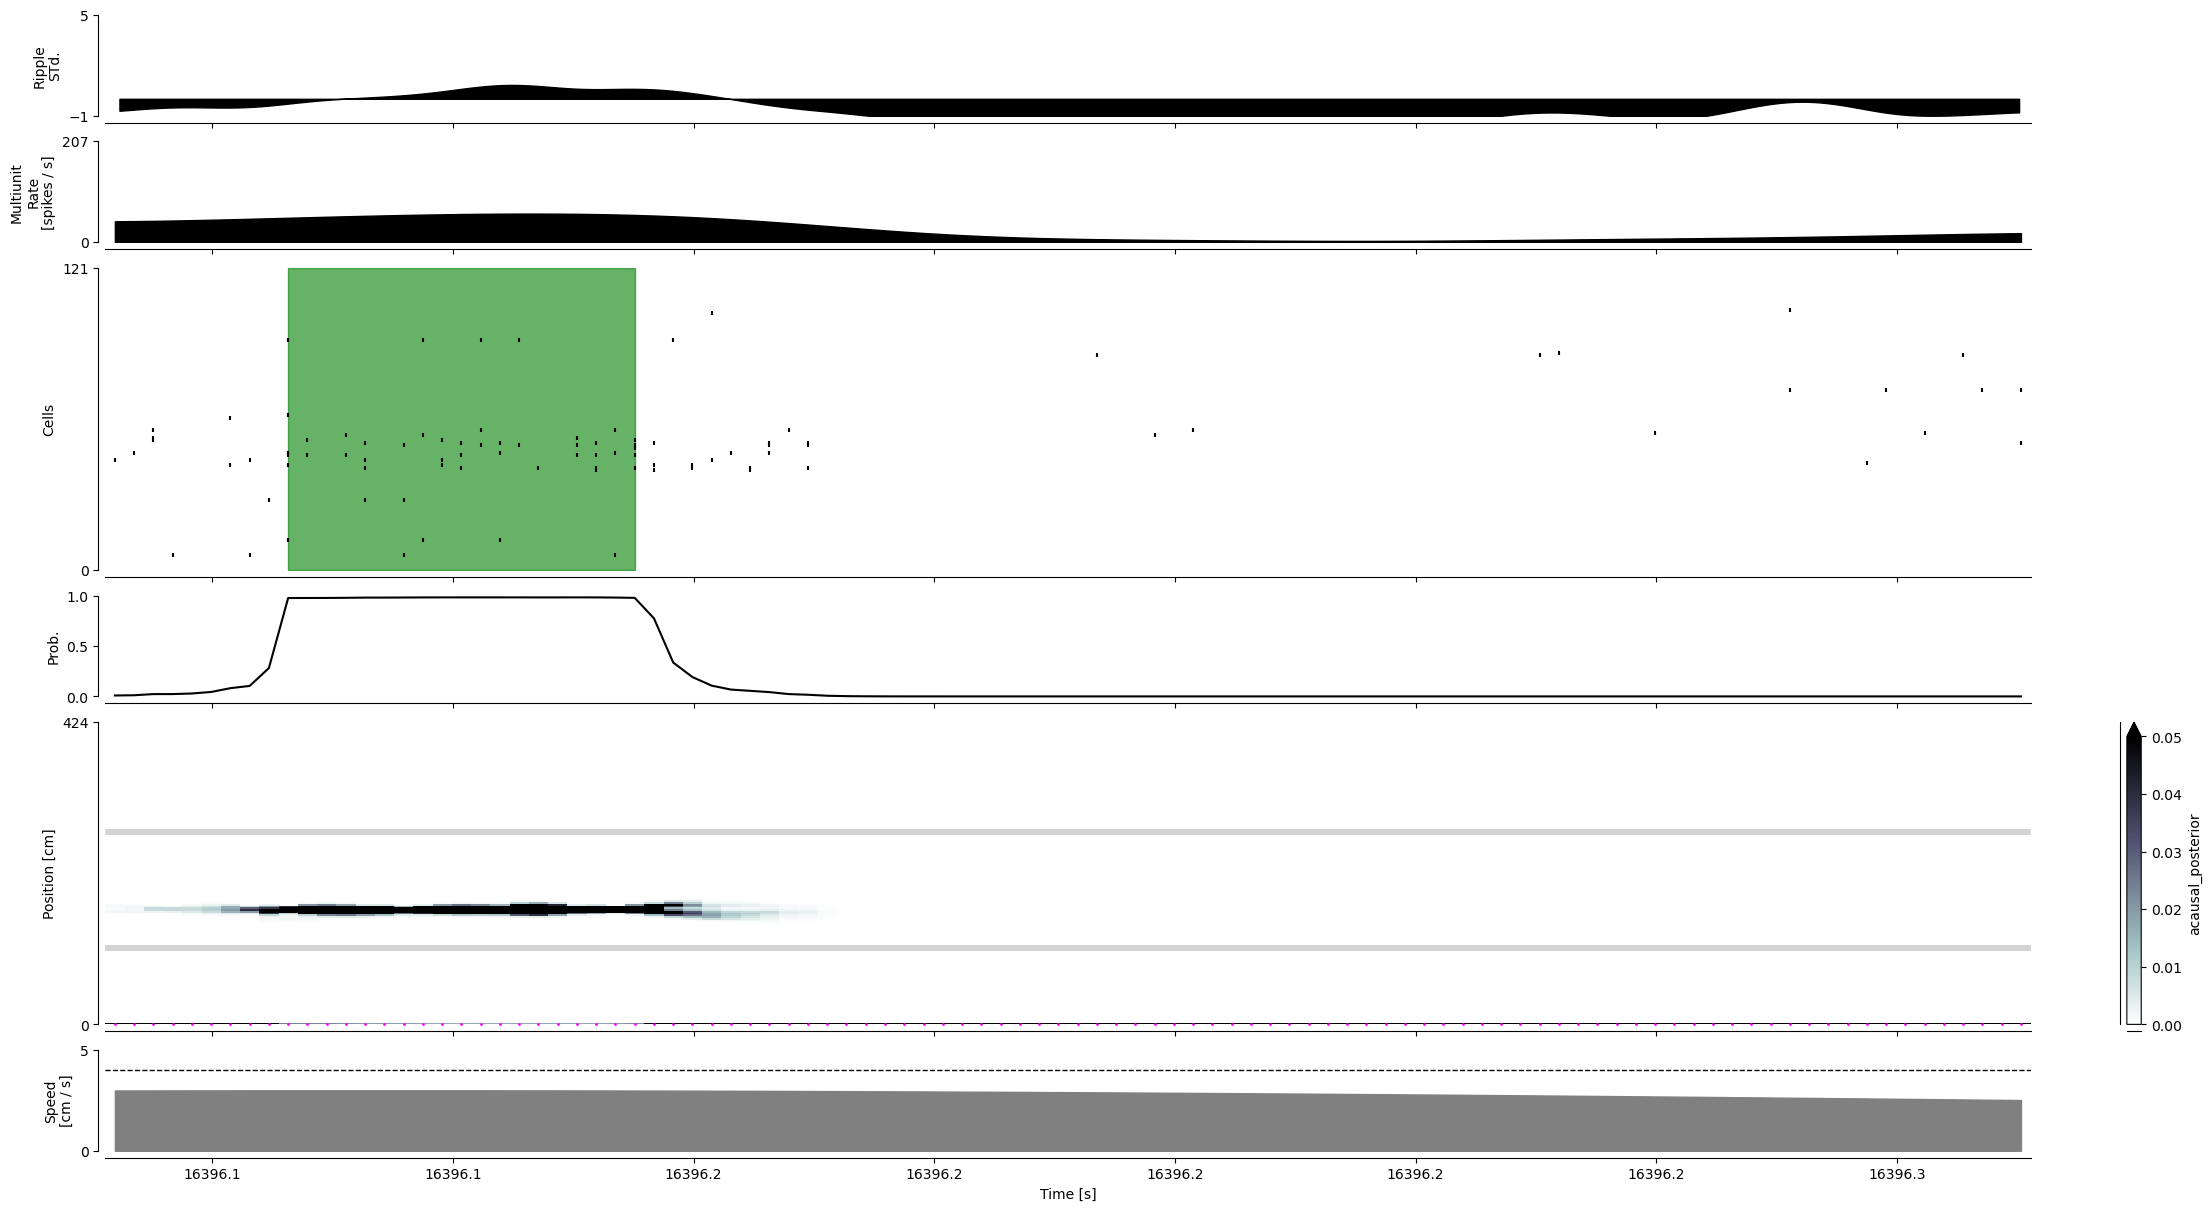

In [291]:
time_slice = slice(14_000, 14_100)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

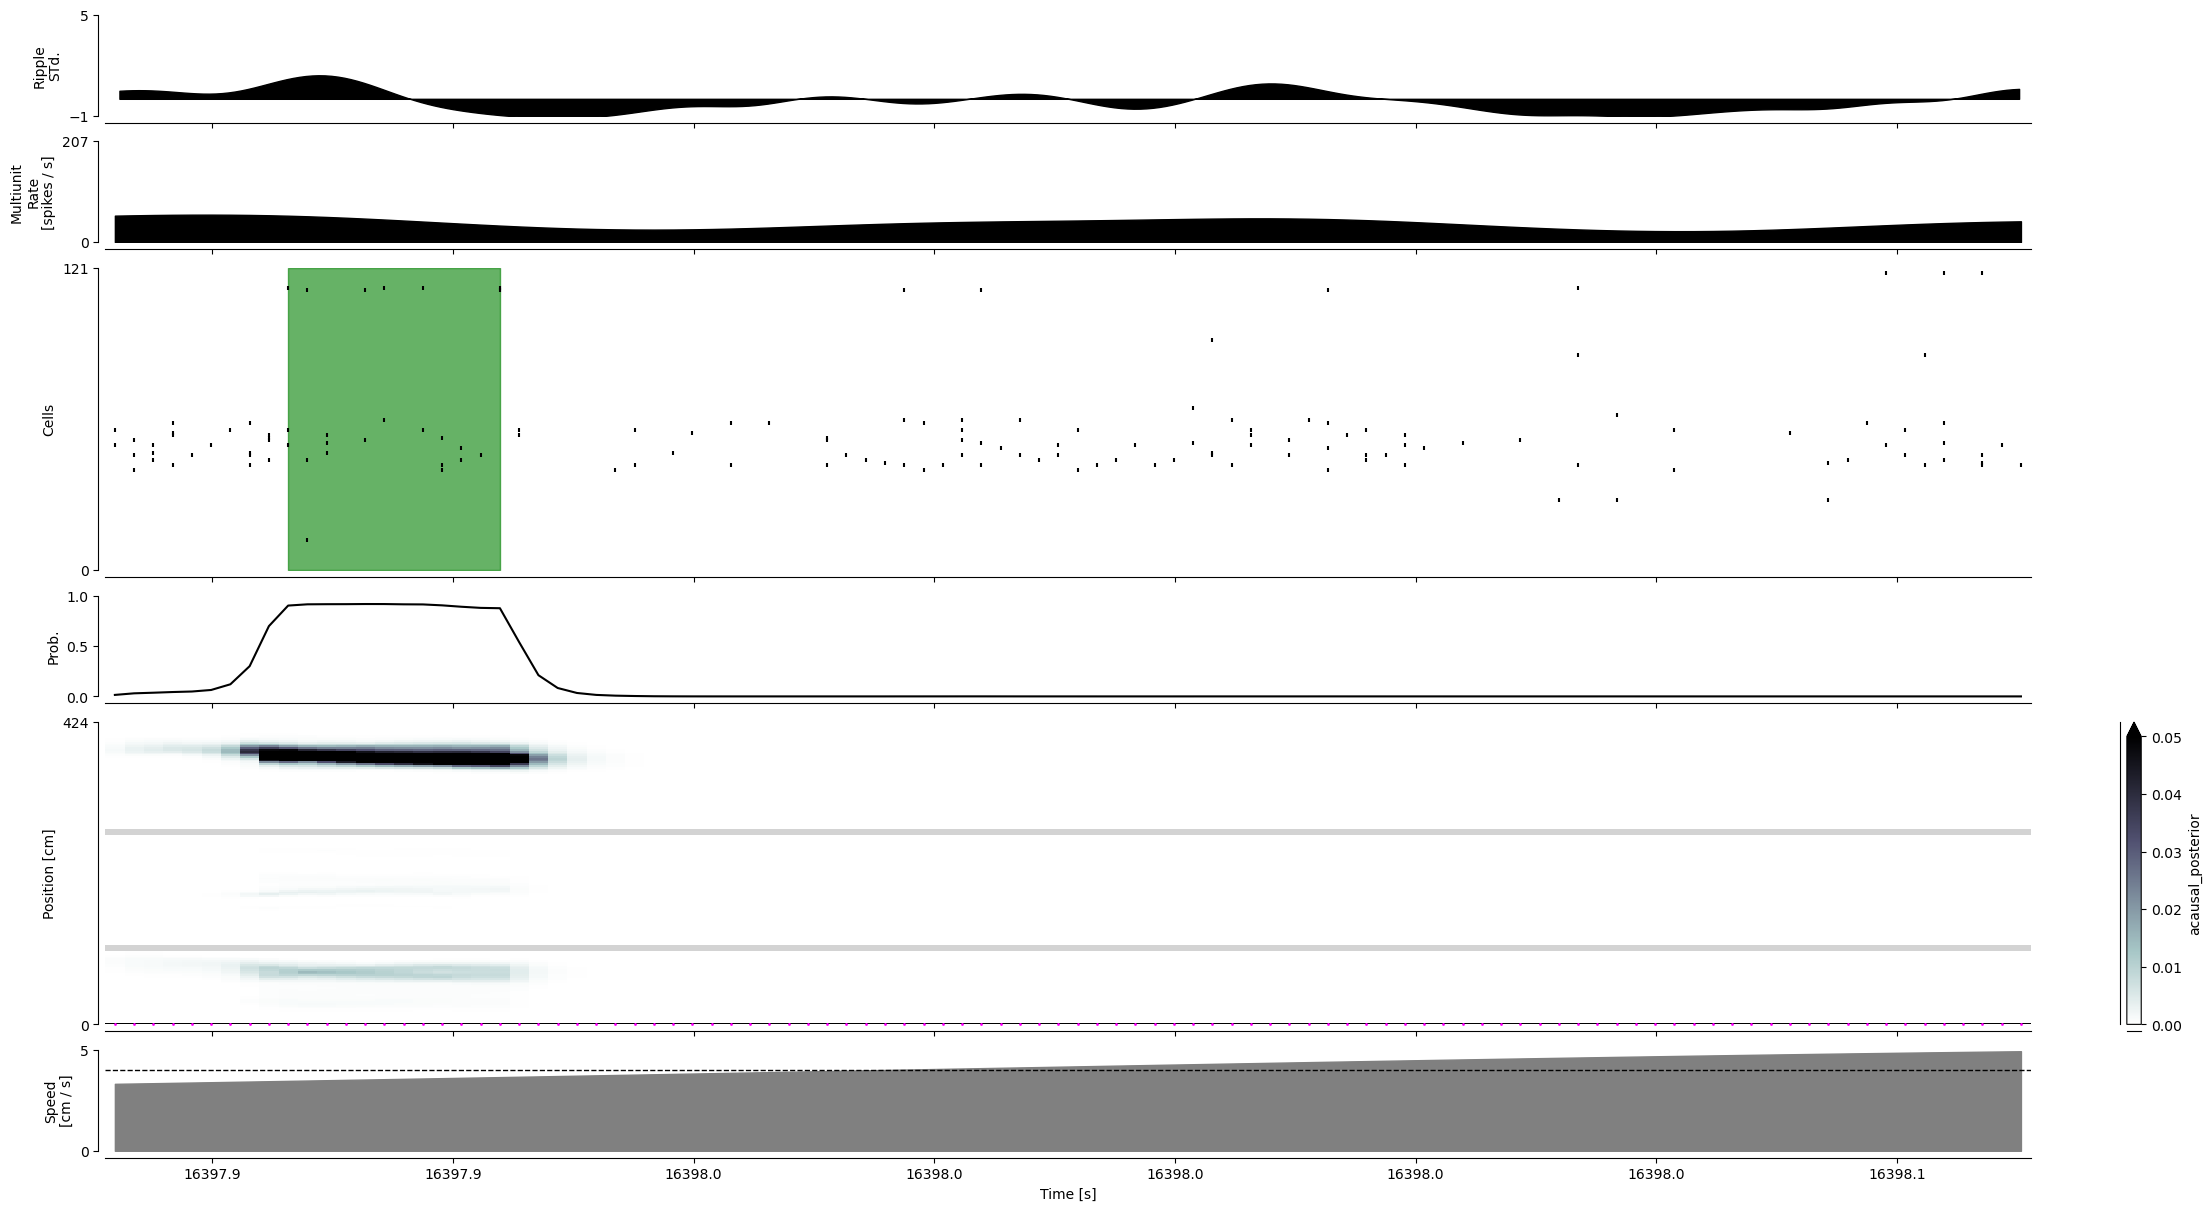

In [292]:
time_slice = slice(14_900, 15_000)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

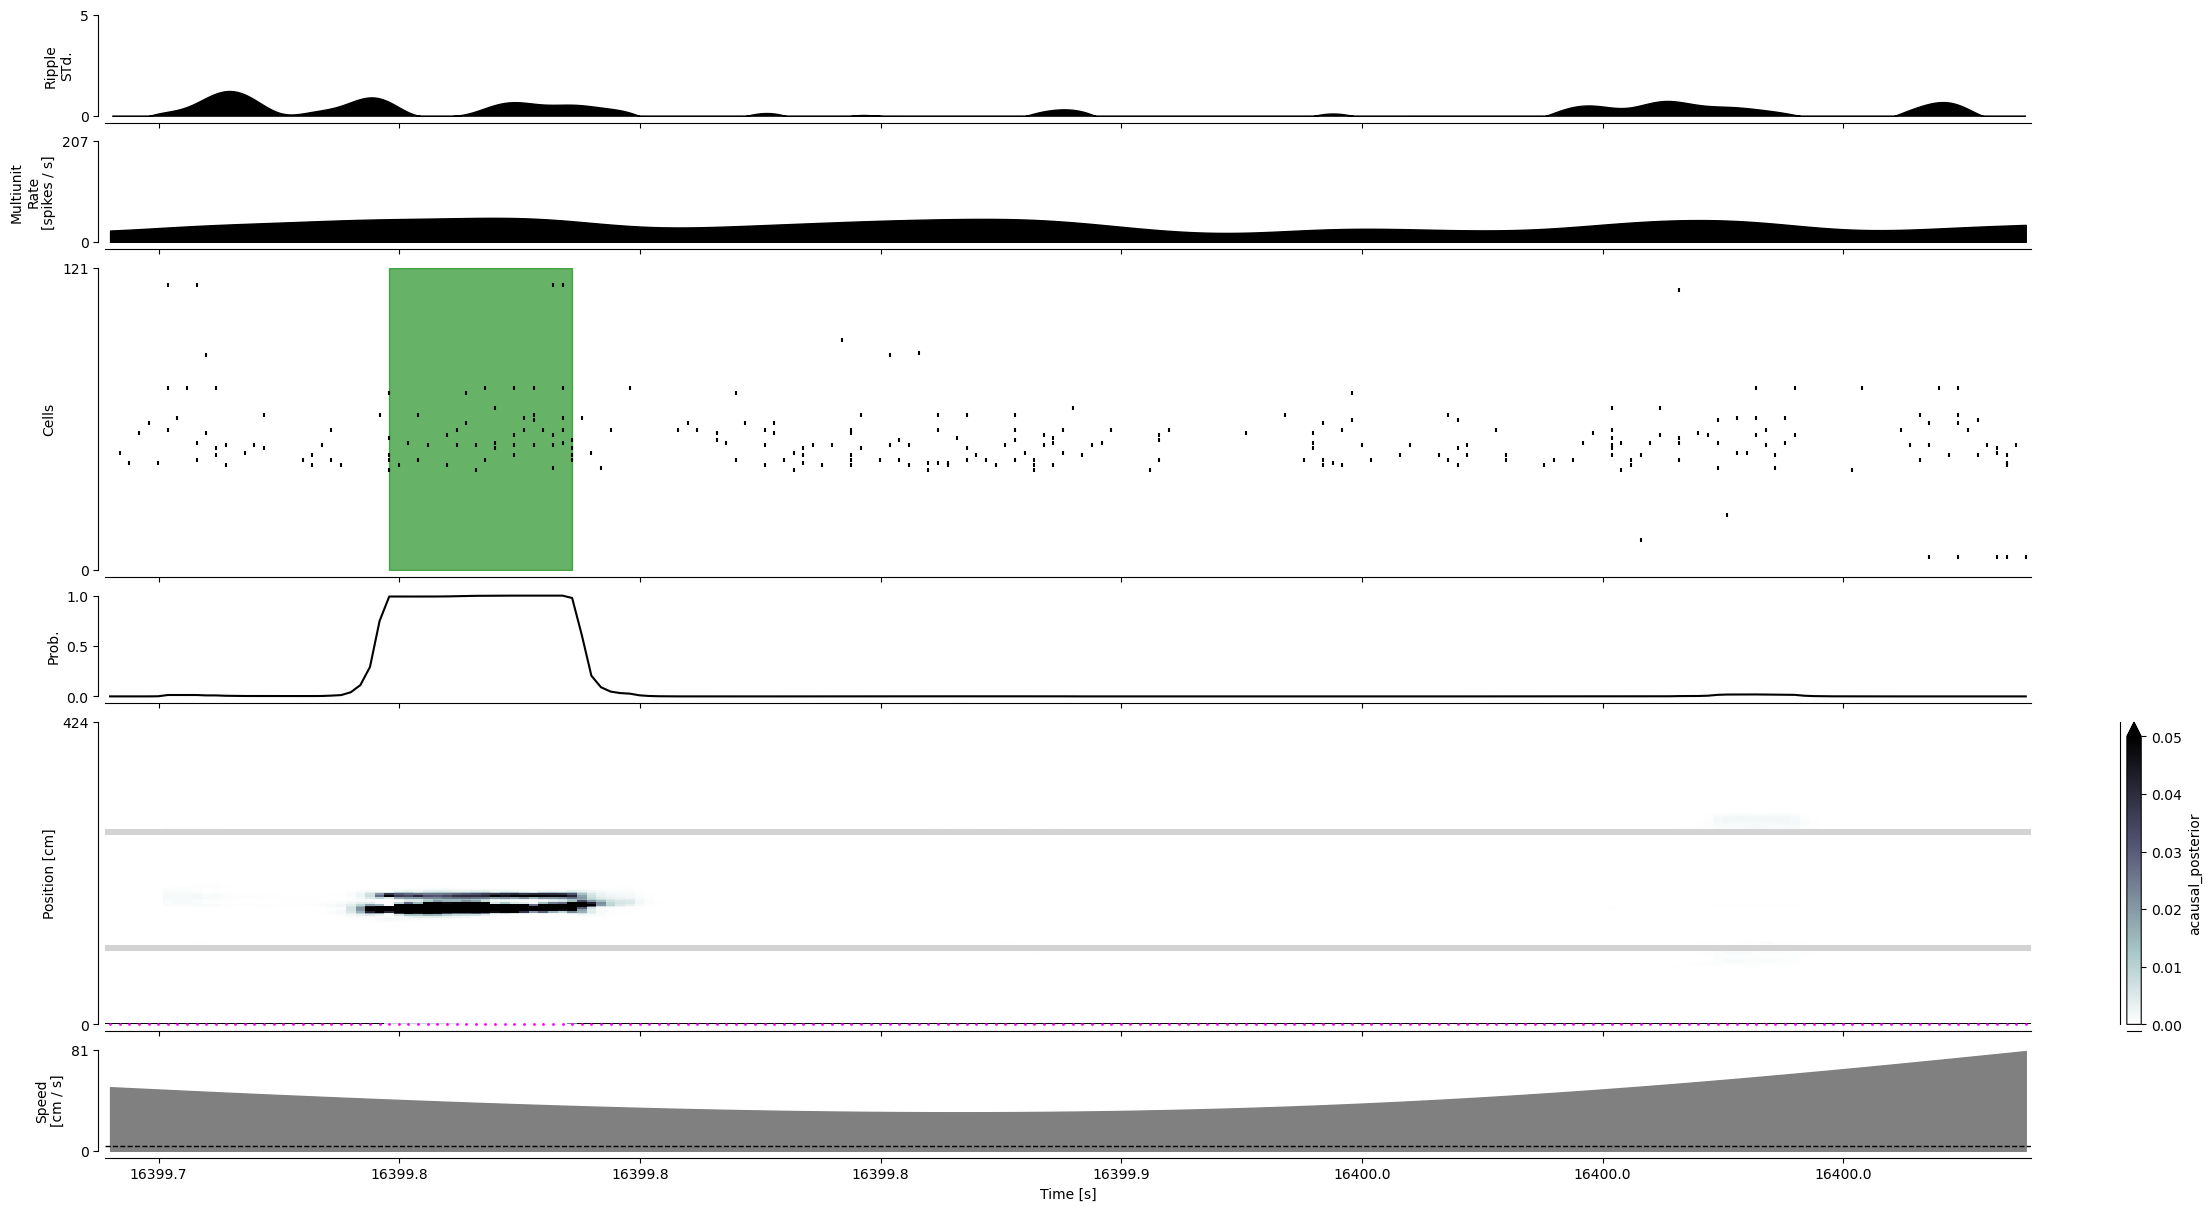

In [279]:
time_slice = slice(15_800, 16_000)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

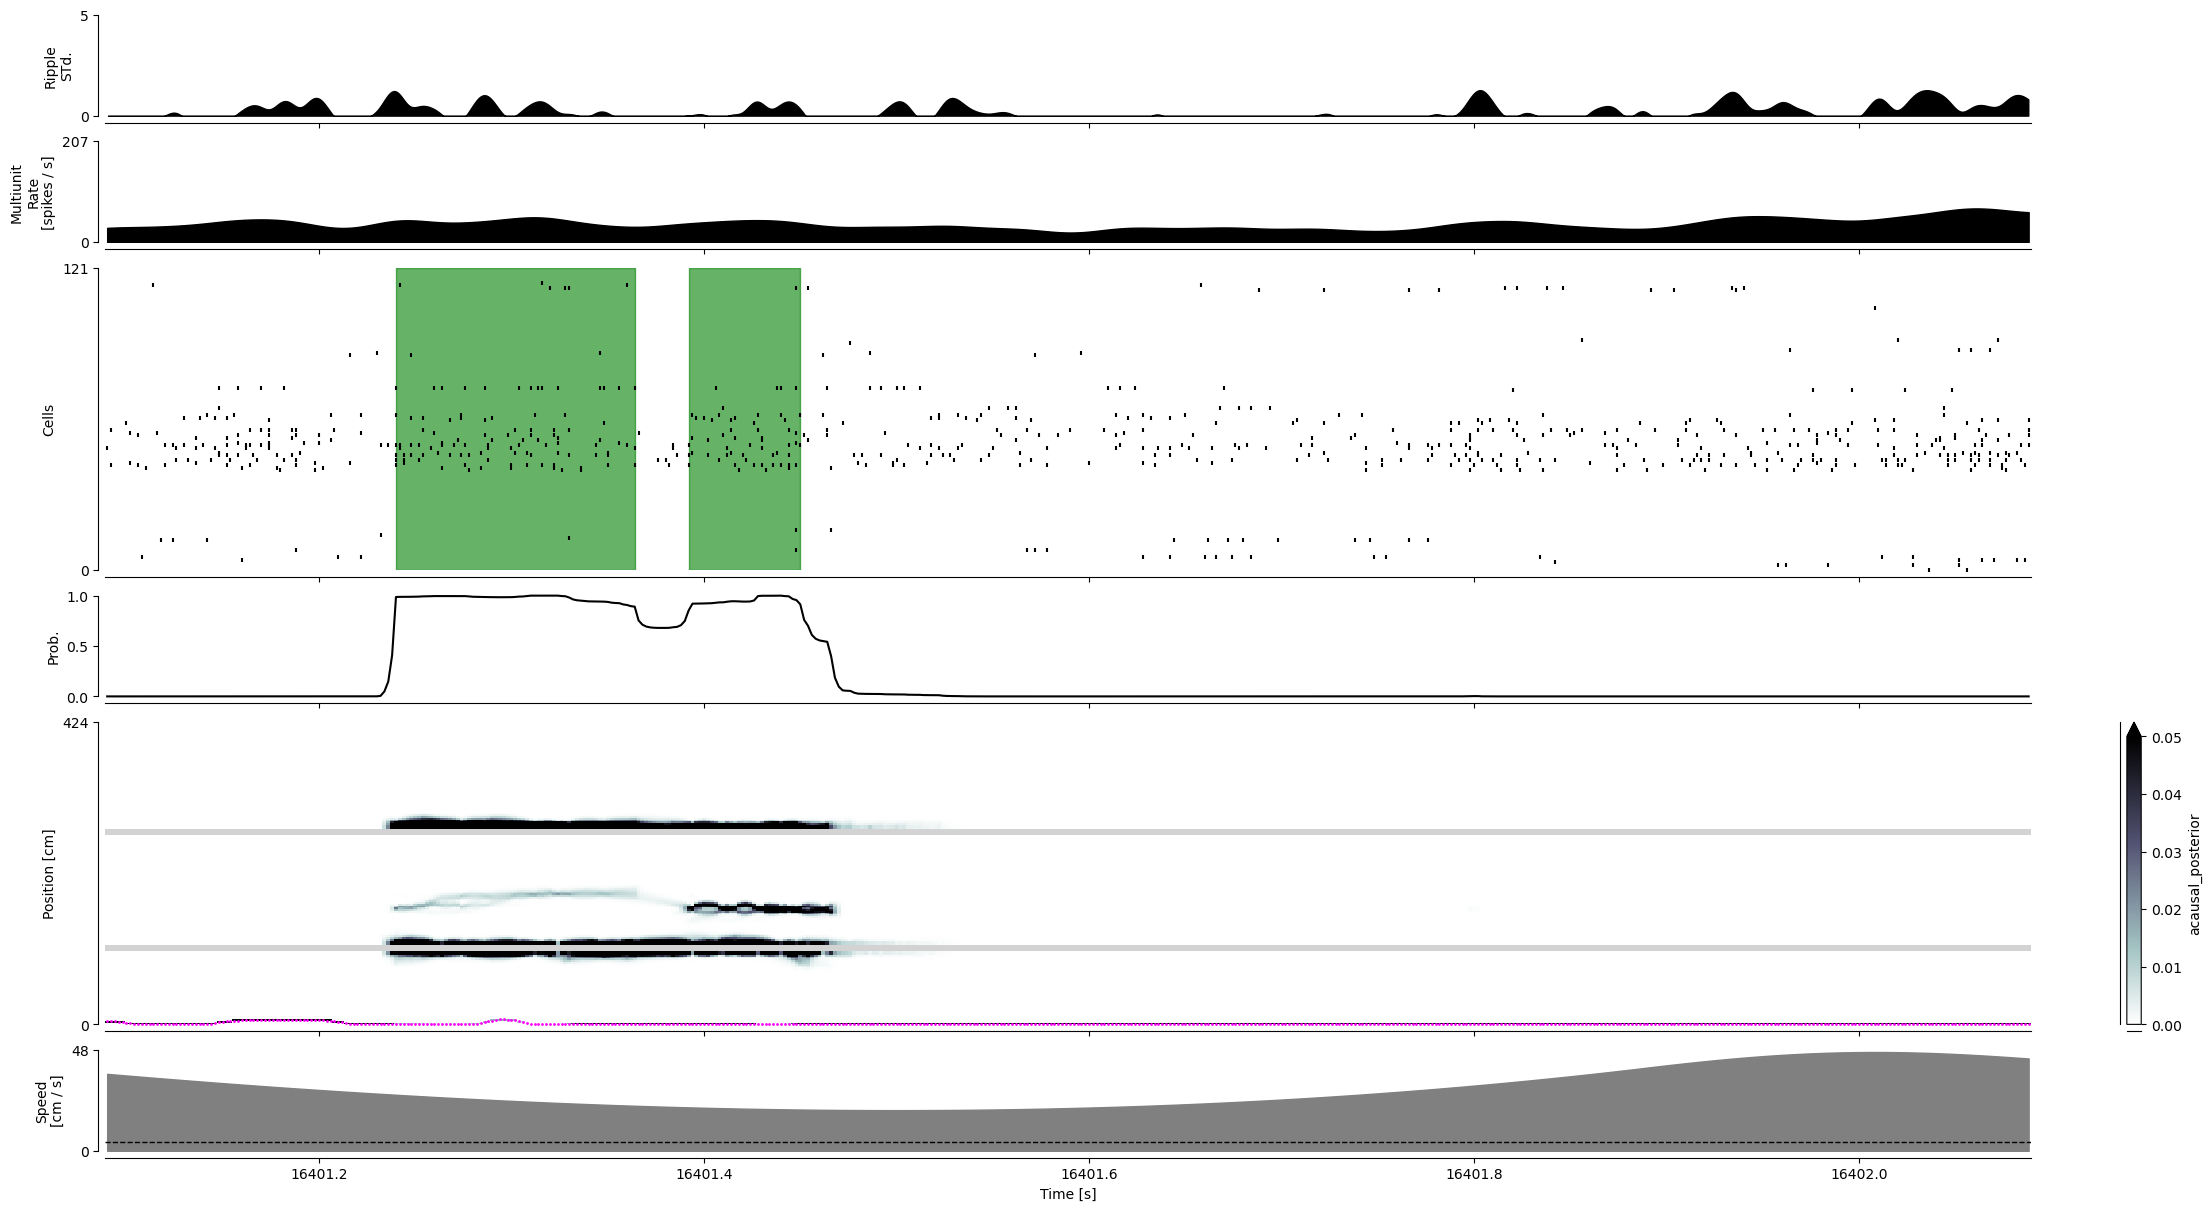

In [280]:
time_slice = slice(16_500, 17_000)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

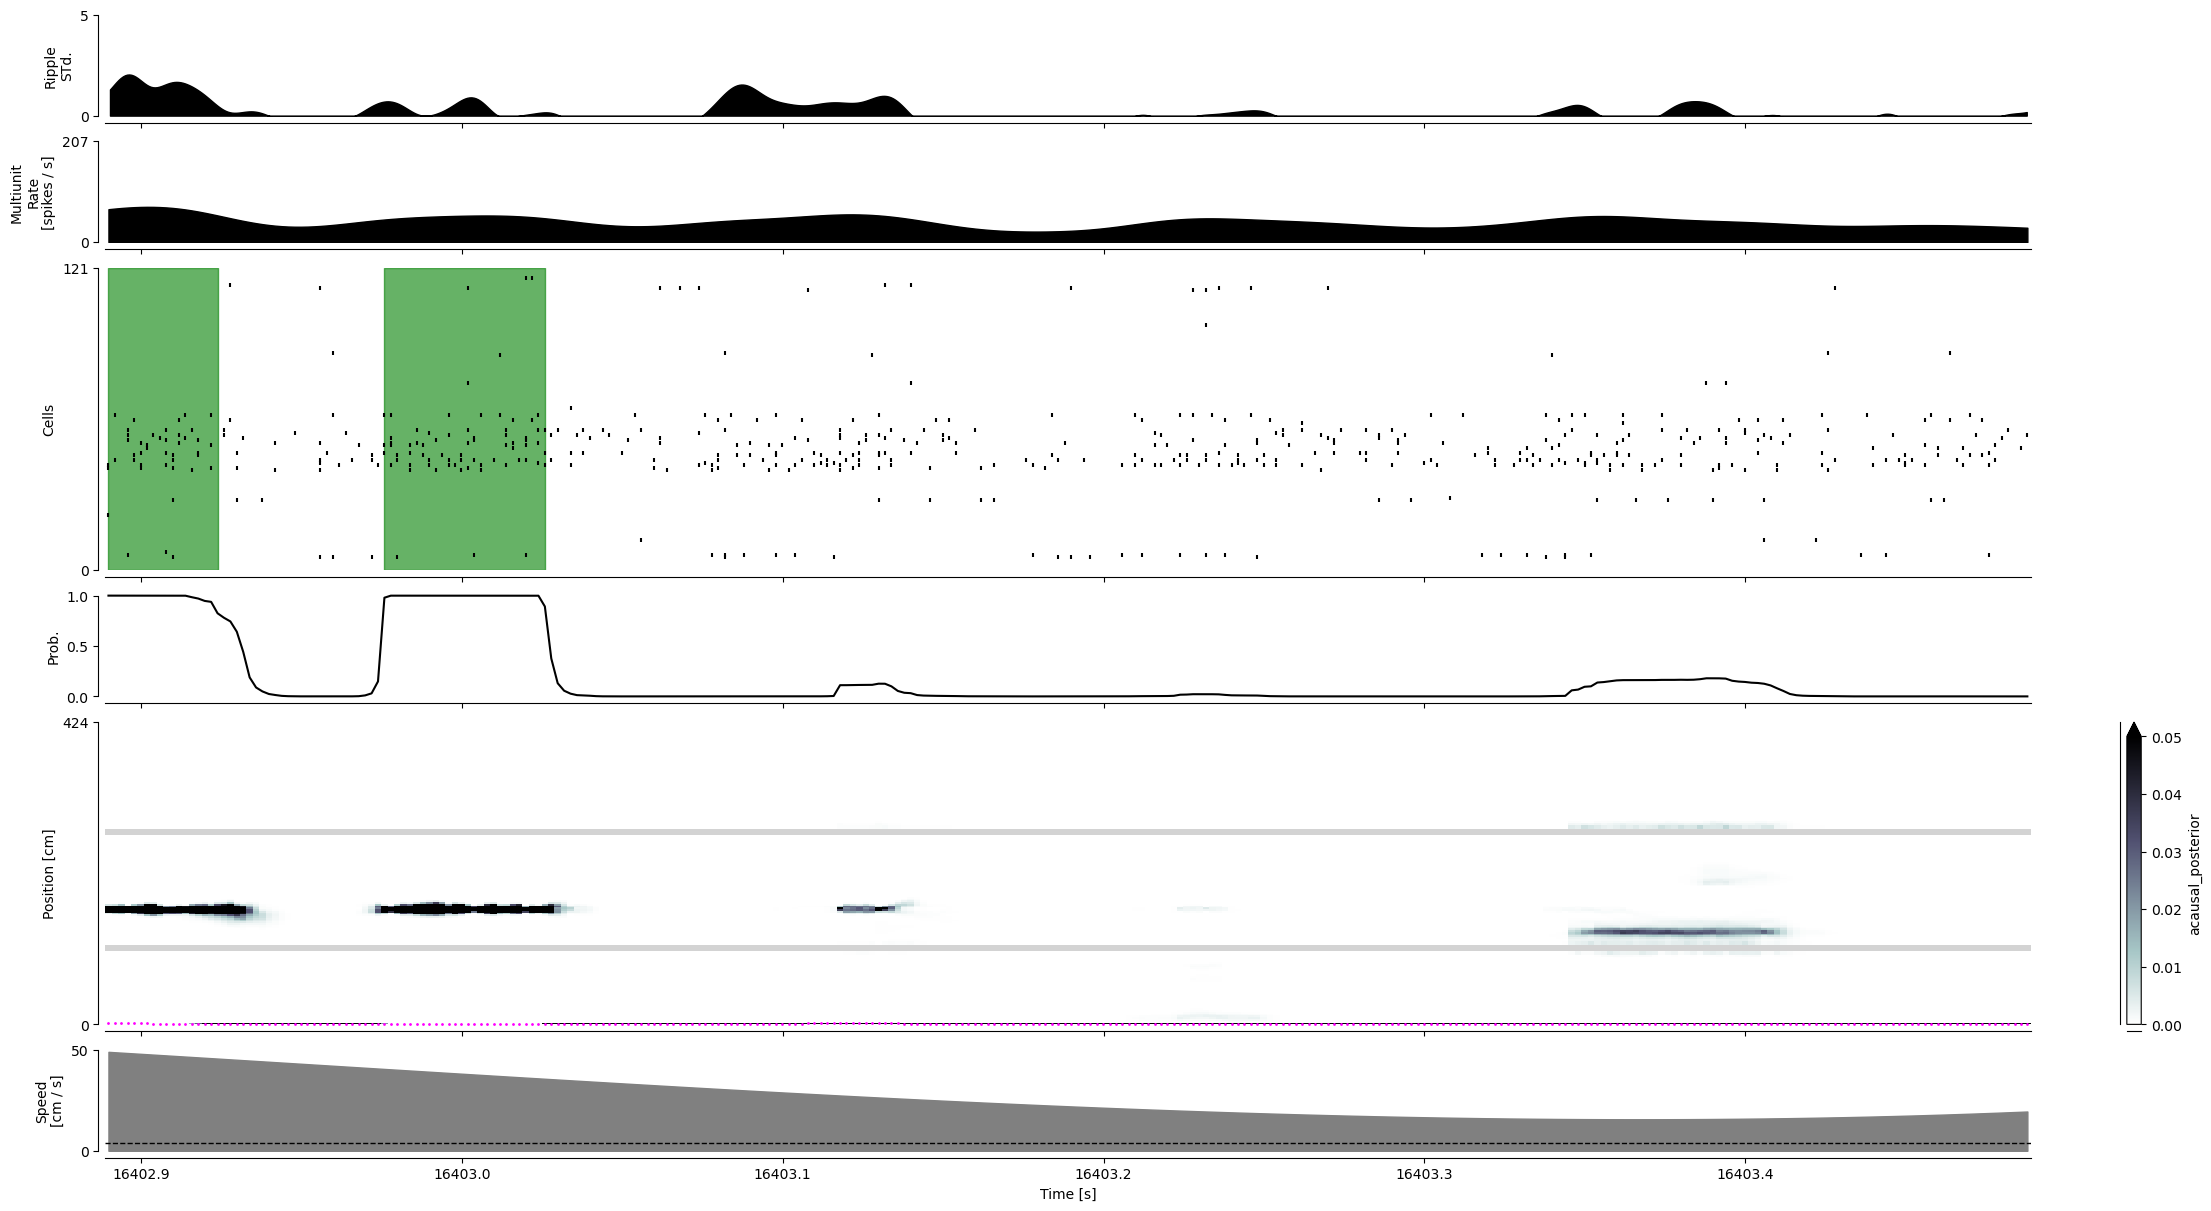

In [282]:
time_slice = slice(17_400, 17_700)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

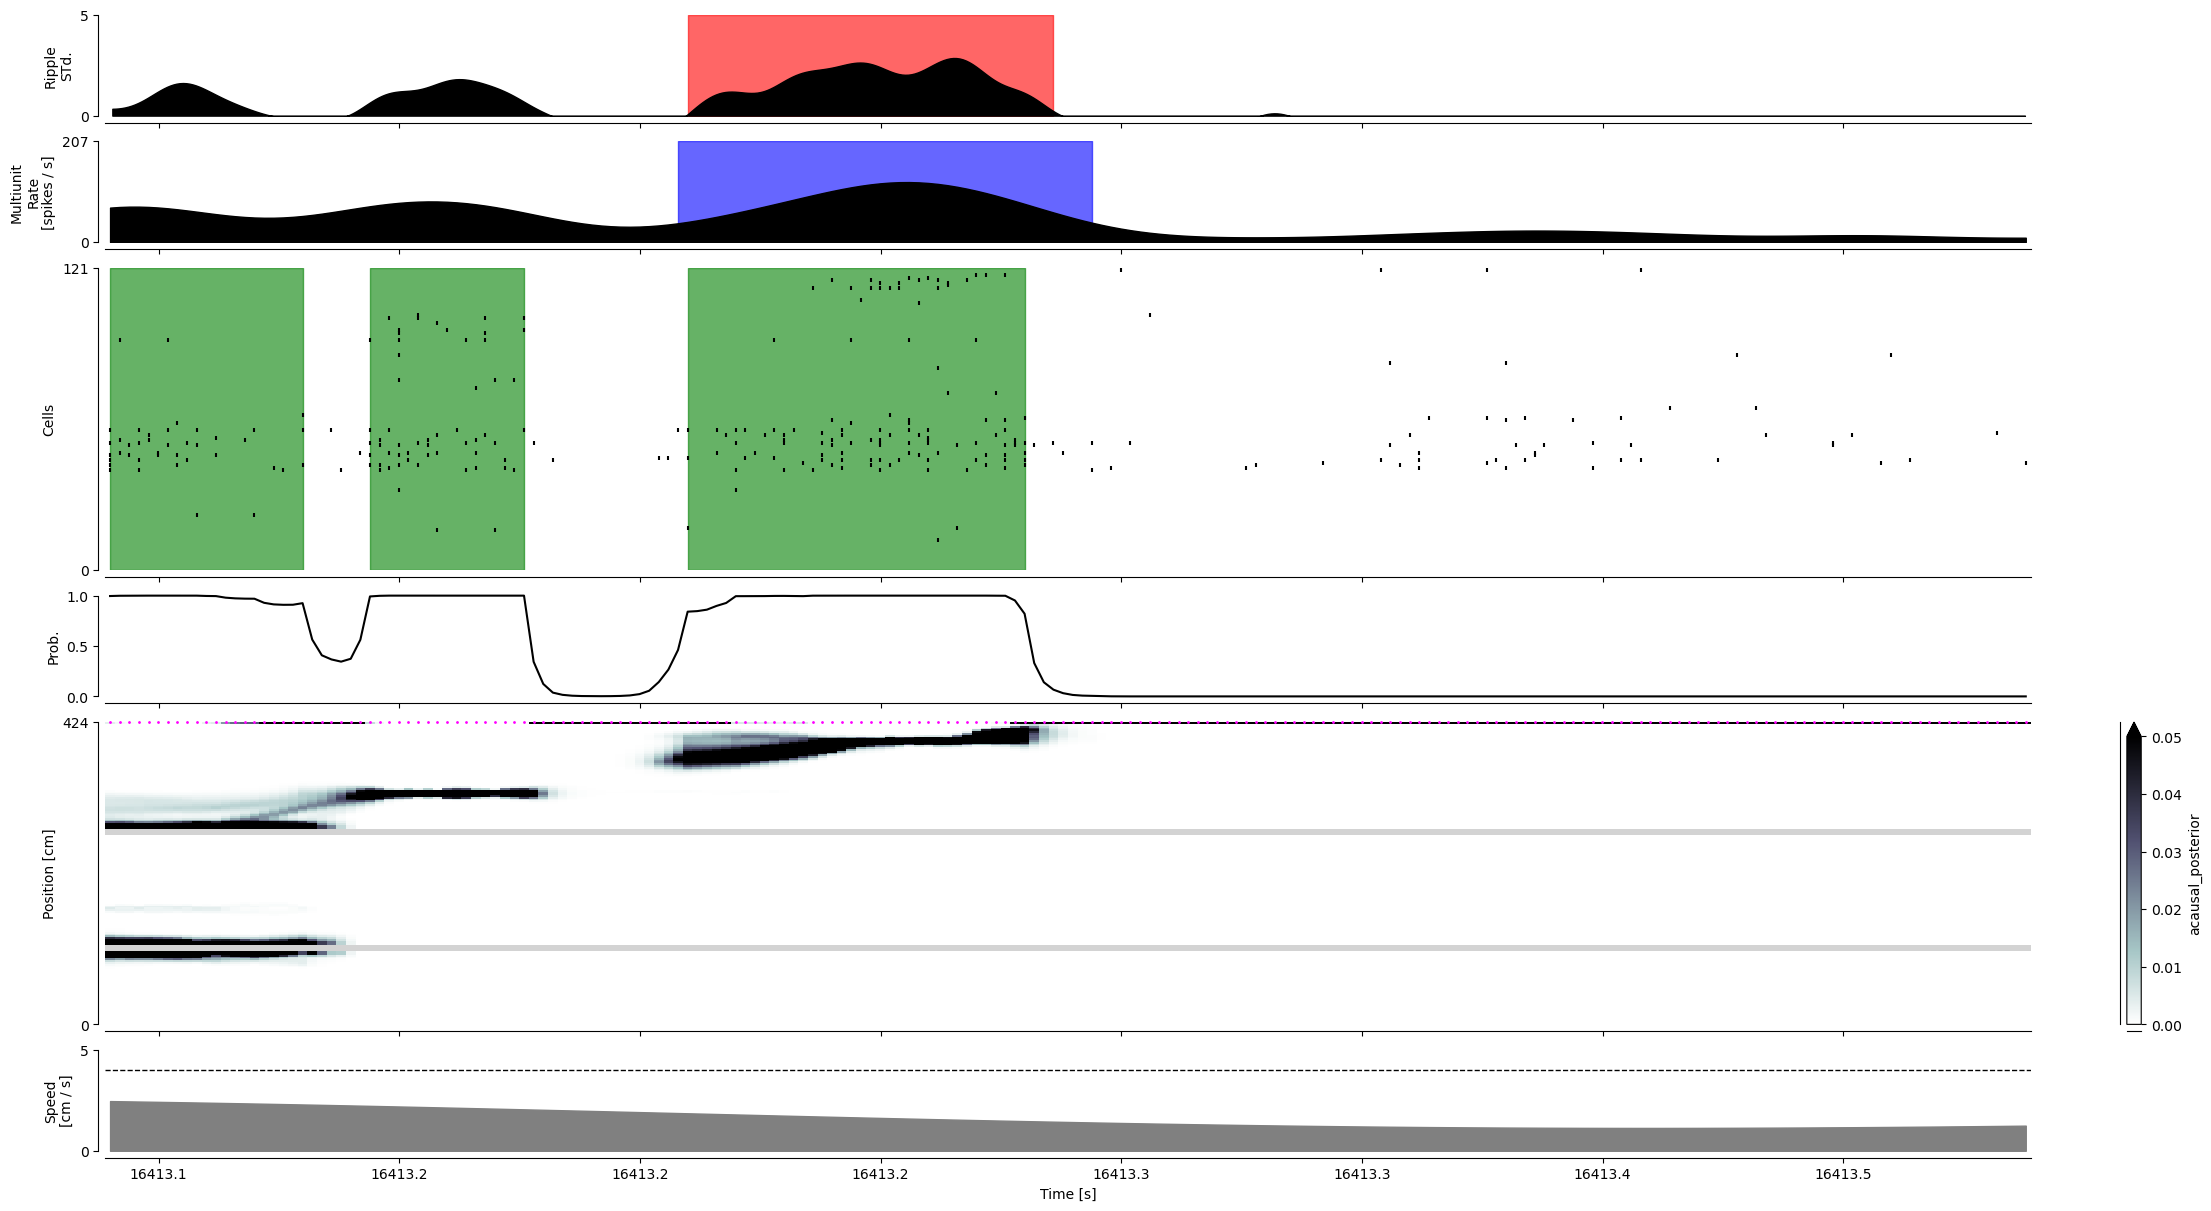

In [283]:
time_slice = slice(22_500, 22_700)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))

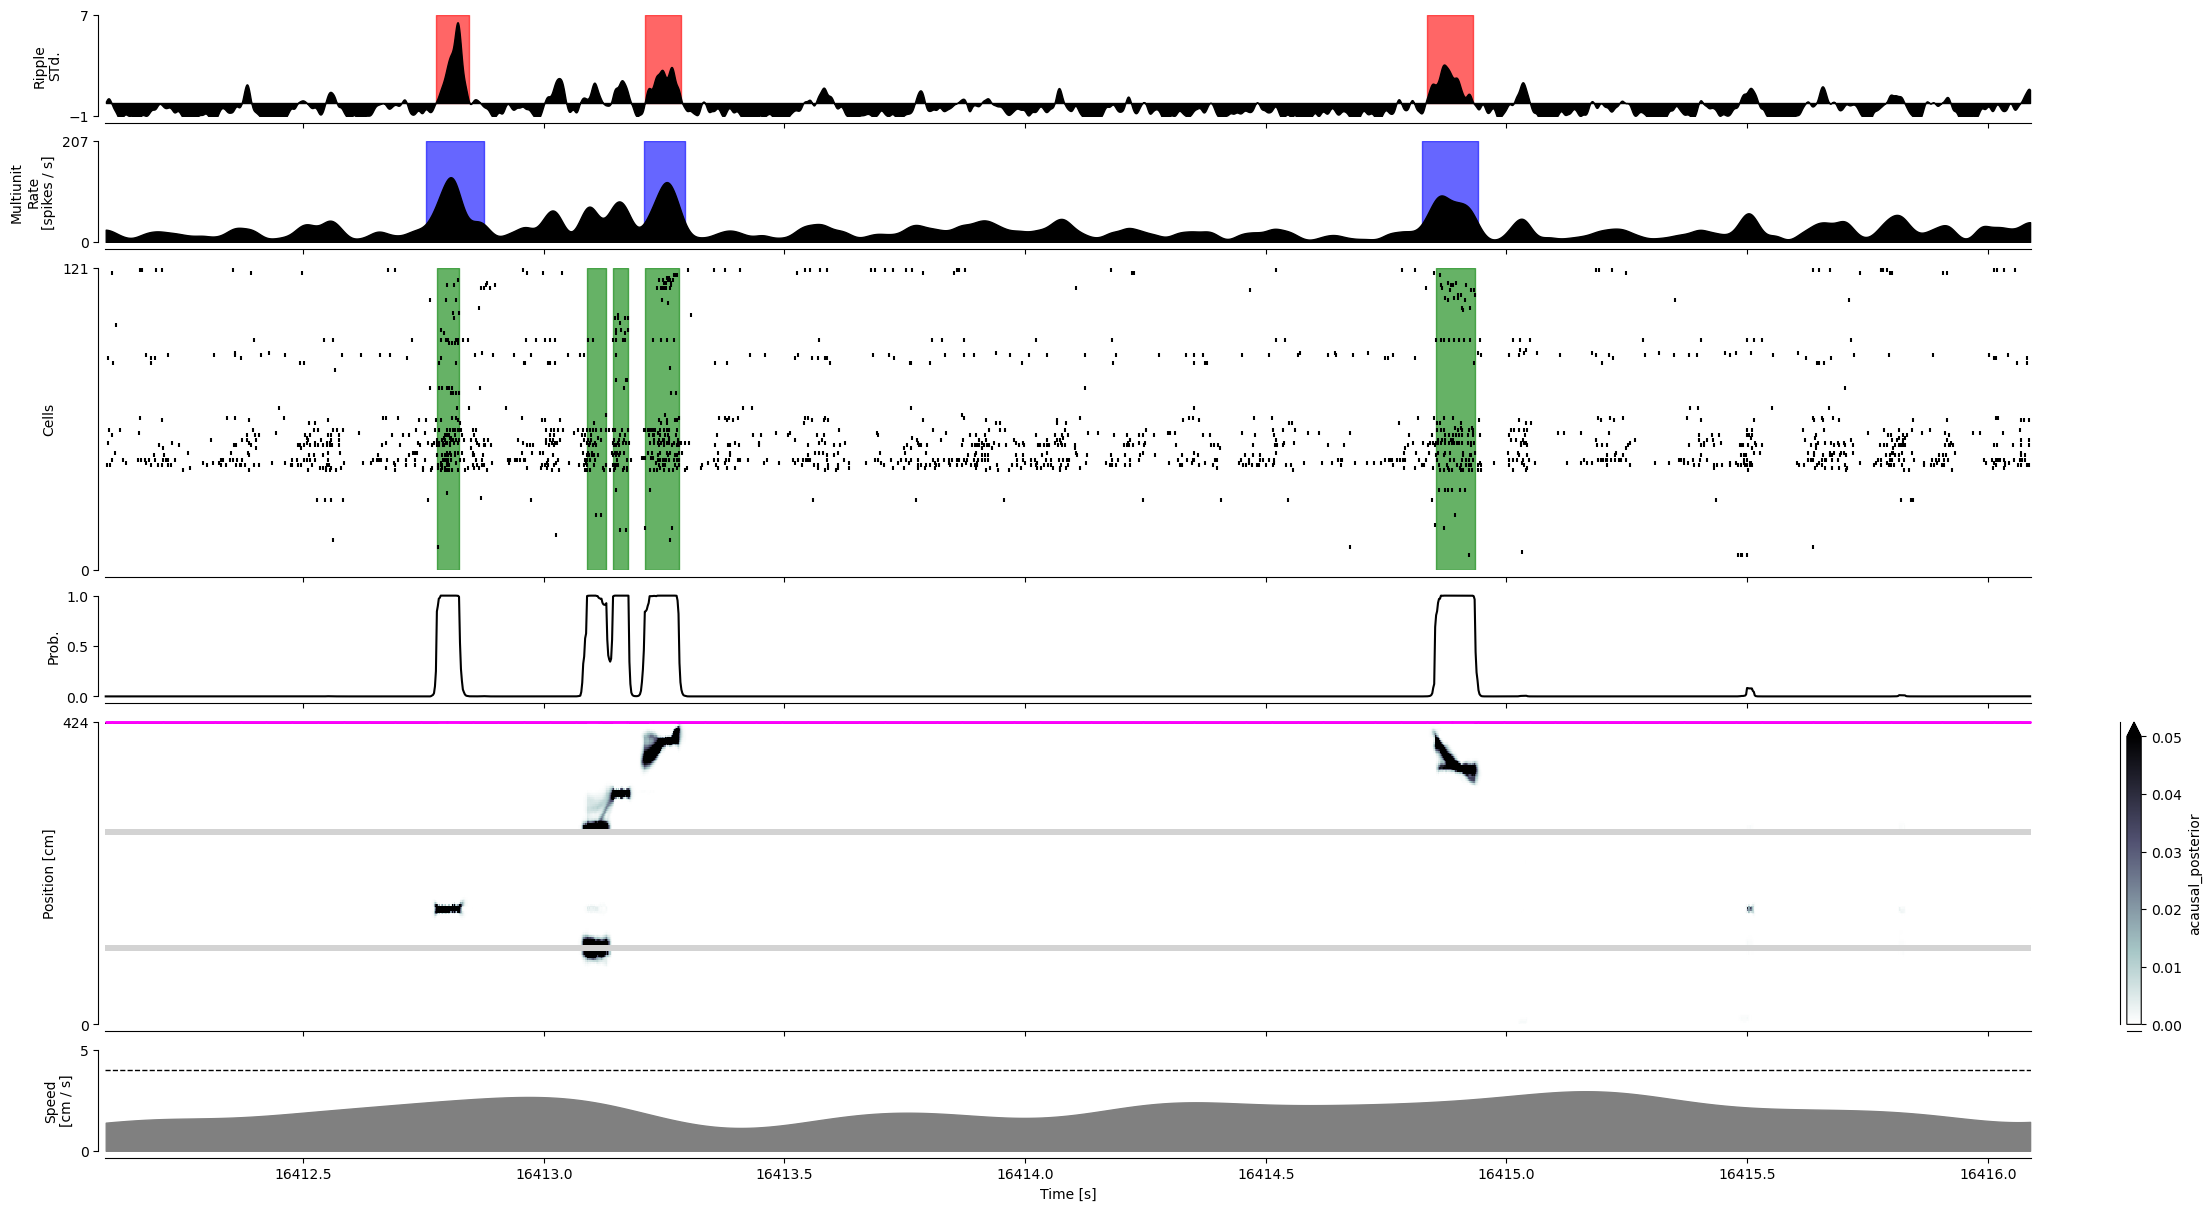

In [293]:
time_slice = slice(22_000, 24_000)
plot_detector(time_slice, data, detectors[0], results[0], figsize=(22, 12.0))